In [1]:
import sys ; sys.path.insert(0, '../')
from notebook_tools import *
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
%matplotlib inline
from scipy.interpolate import interp1d

In [46]:
figures_path = '/Users/erezcohen/Desktop/Projects/2NSRC/InternalReport/Figures/'

In [2]:
def plot_needed_for_A_depdendence_sigma_t(ax=None,figsize=(16,15),s=30,
                                          xlim=(2.5,250), ylim=(0,200), #79
                                          labels=dict({'$^4$He':(3.5,122),
                                                '$^{12}$C':(9,165),
                                                '$^{27}$Al':(21,182),
                                                '$^{56}$Fe':(45,185),
                                                '$^{208}$Pb':(140,184),                                               
                                                      }),
                                          fontsize=55,
                                          do_Ciofi=True):
    from scipy.interpolate import interp1d

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    # for all plots
    plot_calculation_line( kind='slinear',data=ColleCalc, varx='A' , vary='allpairs',color='black' ,label='Colle et al., All pairs')
    plot_calculation_line( kind='slinear',data=ColleCalc, varx='A' ,linestyle='-',color='black', vary='nl00',label='Colle et al., $^1S_0$ pairs')
    if do_Ciofi: ax.errorbar(CiofiCalc.A, CiofiCalc.s_t,markeredgecolor='black',marker='*',ms=30,mfc='none',linewidth=0, markeredgewidth=2,label='Ciofi and Simula')
    plot_data( data=BNL_Data, ax=ax, Ashift=1 , color='blue', marker='s', label=None )
    plot_data( data=HallA_Data, ax=ax, Ashift=-1 , color='blue' , marker='s' , label='Hall-A/BNL' )
    plot_data( data=Korover_Data , ax=ax, marker='s' , color='blue', label=None )
    
    ax.set_xscale('log')
    set_axes(ax , 'A' , '$\sigma_{c.m.}$ [GeV/c]' , fontsize=fontsize 
             ,xticks=[4,12,27,56,208]
             ,yticks=[100,125,150,175,200])
    ax.grid(b=True, which='major', color='b', linestyle='--',alpha=0.25)    
    if xlim is not None:    ax.set_xlim(xlim);
    if ylim is not None:    ax.set_ylim(ylim);
    # target name labels
    for label in list(labels.keys()):
        ax.text(labels[label][0],labels[label][1],label,fontsize=35)
    return ax

def plot_A_depdendence_sigma_t(data=None,
                               figsize=(16,15),s=30,fontsize=55,
                               xlim=(2.5,250), ylim=(79,200),  #79
                               do_save_fig=True, filename='corrected_sigma_t_with_calculations',
                               labels=dict({'$^4$He':(3.5,122), '$^{12}$C':(9,165), '$^{27}$Al':(21,182),
                                            '$^{56}$Fe':(45,185), '$^{208}$Pb':(140,184), }),
                               do_Ciofi=True,do_measured=True,
                               do_stat_uncertainties=False,do_sys_uncertainties=False,do_tot_uncertainties=True):
    
    fig,ax = plt.subplots(figsize=figsize)
    ax=plot_needed_for_A_depdendence_sigma_t(ax=ax,figsize=figsize,fontsize=fontsize,s=s,xlim=xlim, ylim=ylim,labels=labels,do_Ciofi=do_Ciofi)
    # measured
    if do_measured: ax.plot(cm_pars['A'], 1000*cm_pars['sigma_t_before_acc_corr'] ,mec='red' , marker='^' ,mfc='none',lw = 2, mew = 2, ms = 20, linewidth=0, label='This work, no acceptance corr.')
    # corrected
    if do_tot_uncertainties:
        plot_data_assymetric( data=data, ax=ax, label='This work', markersize=20 ,color='red' , marker='o')
        
    # seperated statistical uncertainty
    if do_stat_uncertainties: 
        A,st,sterr = cm_pars['A'], 1000*data['sigma_t_final'], 1000*data['sigma_t_final_Err_stat']
        if do_tot_uncertainties:
            ax.errorbar(A,st,sterr ,ecolor='purple',elinewidth=2 , capsize=15, capthick=3 , linestyle='none'
                        ,linewidth=3, label='stat. uncertainties')
        else: 
            ax.errorbar(A,st,sterr ,ecolor='red',color='red', marker='o', markersize=20 ,elinewidth=2 , capsize=15, capthick=3 , linestyle='none'
                        ,linewidth=3, label='stat. uncertainties')

#     ax.legend(fontsize=25,loc='lower right')
    # add a band of systematical uncertaintes
    if do_sys_uncertainties:
        ax.fill_between(cm_pars['A']
                        , np.min(ax.get_ylim())
                        , np.min(ax.get_ylim()) + 1000*data['sigma_t_final_up_err_sys'] 
                        , color='purple' , alpha=0.5 ,  label='sys. uncertainties')
    ax.legend(fontsize=25,loc='upper left')

# generated vs. reconstructed in bins of generated

In [3]:
columns = ['Pmiss3Mag','pcmX','pcmY','pcmZ','rooWeight'] # ,'Mott','DipoleFF2'
data_allPmiss_PrecFid , data300Pmiss600_PrecFid = dict() , dict()
for target in ['C12','Al27','Fe56','Pb208']:
    data_allPmiss_PrecFid[target] = read_root( path+"/OrAnalysisTrees/AdjustedTrees/SRC_e2p_adjusted_300Pmiss600_%s_PrecFiducials.root"%target, columns=columns )
    data300Pmiss600_PrecFid[target] = data_allPmiss_PrecFid[target][data_allPmiss_PrecFid[target]['Pmiss3Mag']<0.6]

In [4]:
cm_parameters = dict()
cm_parameters_with_correction = dict()
for Fiducials in ["PrecFiducials"]:
    cm_pars = pd.read_csv('/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/300Pmiss600/alltargets_'+Fiducials+'_dataCMparameters.csv')
    cm_pars['sigma_x_before_acc_corr'] = np.sqrt(np.square(cm_pars['sigma_x_unweighted']) - np.square(0.02))
    cm_pars['sigma_x_before_acc_corr_err'] = cm_pars['sigma_xErr_unweighted']
    cm_pars['sigma_y_before_acc_corr'] = np.sqrt(np.square(cm_pars['sigma_y_unweighted']) - np.square(0.02))
    cm_pars['sigma_y_before_acc_corr_err'] = cm_pars['sigma_yErr_unweighted']
    
    
    # weighted average
    sigma_x, Dsigma_x = cm_pars['sigma_x_before_acc_corr'], cm_pars['sigma_x_before_acc_corr_err']
    sigma_y, Dsigma_y = cm_pars['sigma_y_before_acc_corr'], cm_pars['sigma_y_before_acc_corr_err']
    sigma_t = (sigma_x/np.square(Dsigma_x)+sigma_y/np.square(Dsigma_y))/( 1./np.square(Dsigma_x) + 1./np.square(Dsigma_y))
    cm_pars['sigma_t_before_acc_corr'] = sigma_t    
    Dsigma_t = np.sqrt(1./( 1./np.square(Dsigma_x) + 1./np.square(Dsigma_y) ))
    cm_pars['sigma_t_before_acc_corr_err'] = Dsigma_t
    cm_parameters[Fiducials] = cm_pars
    cm_parameters_with_correction[Fiducials] = cm_pars
cm_parameters[Fiducials]

Nevts  chi2red_x_unweighted  chi2red_y_unweighted  chi2red_z_unweighted  \
0    266              0.602767              0.407306              2.139232   
1     88              1.058674              0.542381              0.460758   
2    227              0.471936              0.458693              1.598486   
3     45              0.847317              0.596230              0.395723   

   mean_xErr_unweighted  mean_x_unweighted  mean_yErr_unweighted  \
0              0.009711          -0.026697              0.009910   
1              0.019329          -0.035170              0.017791   
2              0.011862          -0.027254              0.012322   
3              0.029217          -0.024147              0.024489   

   mean_y_unweighted  mean_zErr_unweighted  mean_z_unweighted  \
0          -0.005837              0.009028           0.106593   
1           0.017157              0.015036           0.118663   
2          -0.009223              0.009999           0.149765   
3           0.016012              0.025269           0.177513   

              ...              sigma_zErr_unweighted  sigma_z_unweighted  \
0             ...                           0.006384            0.147251   
1             ...                           0.010629            0.141058   
2             ...                           0.007069            0.150658   
3             ...                           0.017832            0.169545   

       target    A  sigma_x_before_acc_corr  sigma_x_before_acc_corr_err  \
0    $^{12}$C   12                 0.157110                     0.006865   
1   $^{27}$Al   27                 0.180235                     0.013666   
2   $^{56}$Fe   56                 0.177601                     0.008388   
3  $^{208}$Pb  208                 0.195017                     0.020634   

   sigma_y_before_acc_corr  sigma_y_before_acc_corr_err  \
0                 0.160396                     0.007007   
1                 0.165708                     0.012570   
2                 0.184577                     0.008706   
3                 0.163082                     0.017300   

   sigma_t_before_acc_corr sigma_t_before_acc_corr_err  
0                 0.158720                    0.004904  
1                 0.172366                    0.009252  
2                 0.180959                    0.006040  
3                 0.176265                    0.013257  

[4 rows x 27 columns]

## cm_parameters['PrecFiducials']

In [5]:
targets = ['C','Al','Fe','Pb']
target_names = [r'$^{12}$C',r'$^{27}$Al',r'$^{56}$Fe',r'$^{208}$Pb']
colors = ['red','blue','forestgreen','purple']
As = [12,27,56,208]
Neep = [7598,2573,8558,2635]
Neepp = [266,88,227,45]
simulation_results = dict()

In [6]:
for Fiducials in ["PrecFiducials"]:
    for A,target in zip(As,targets):
        test_name = "simulations_"+Fiducials+"_"+target
        simulation_results[test_name] = pd.read_csv("/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/final_simualtions_300Pmiss600/"+test_name+".csv")
        simulation_results[test_name].fillna(-1,inplace=True)
        print len(simulation_results[test_name]),'events in ',test_name

76800 events in  simulations_PrecFiducials_C
76557 events in  simulations_PrecFiducials_Al
75700 events in  simulations_PrecFiducials_Fe
55836 events in  simulations_PrecFiducials_Pb


In [7]:
def plot_cm_direction_binned(sims=None
                             ,Fiducials='PrecFiducials',extraname=""                              
                             ,ax=None,A=12,poly_degree=3
                             ,direction='x',colors=['blue','royalblue'],s=1
                             ,Nbins_st_rec=10 # GeV/c
                             ,do_add_1Ddist_in_slices=True
                             ,debug=0
                             ,do_zoom_in=False
                             ,do_add_legend=True):

        
    # measured \sigma_t (DATA)
    cm_pars = cm_parameters[Fiducials]        
    cm_tgt = cm_pars[cm_pars['A']==A]
    index = cm_pars[cm_pars['A']==A].index
    if debug>1: print cm_tgt
    sigma_meas = float(cm_tgt['sigma_'+direction+'_before_acc_corr'])
    sigma_meas_err = float(cm_tgt['sigma_'+direction+'_before_acc_corr_err'])
    
    title = cm_tgt['target'].to_string(index=False) + ', $'+direction+'-direction$'
    if debug: print title

    # region of interest: 2$\sigma$ around measured value
    roi_min = sigma_meas - 2*sigma_meas_err
    roi_max = sigma_meas + 2*sigma_meas_err
    roi_width = roi_max - roi_min
    if debug: print '\sigma_t roi: %.3f->%.3f GeV/c'%(roi_min,roi_max)
    # create bins in region of interest
    roi_sims = sims[(sims['rec_sigma_'+direction]>roi_min)&(sims['rec_sigma_'+direction]<roi_max)]
    
    
    gen,rec = sims['gen_Sigma_t'],sims['rec_sigma_'+direction]
#     plt.scatter(gen,rec,color=colors[1],label='generated vs. reconstructed',s=s)
    if do_zoom_in:
        bins = np.linspace( 0.1 , 0.26 , 50)
    else:
        bins=np.linspace( 0.02 , 0.3 , 50 )
    ax.hist2d(gen,rec,cmap=colors[2],label='generated vs. reconstructed',bins=bins)#,norm=LogNorm())


    # bin in rec. sigma_t
    rec_bins,rec_bins_err,gen_bins,gen_bins_err=[],[],[],[]    
    bin_st_rec_width = roi_width/Nbins_st_rec
    if debug:  print 'bin_st_rec_width:',bin_st_rec_width 
    if do_add_1Ddist_in_slices:
        fig_1Ddist_in_slices = plt.figure(figsize=(16,8))

    
    for i_bin in range(Nbins_st_rec):
        bin_st_rec_center = roi_min + bin_st_rec_width*(i_bin+0.5)
        bin_st_rec_dw = bin_st_rec_center - 0.5*bin_st_rec_width
        bin_st_rec_up = bin_st_rec_center + 0.5*bin_st_rec_width

        # Olympic method to remove extremists
        sims_bin = roi_sims[(roi_sims['rec_sigma_'+direction]>bin_st_rec_dw)
                            &(roi_sims['rec_sigma_'+direction]<bin_st_rec_up)]
        bin_st_gen_mean = np.mean(sims_bin['gen_Sigma_t'])
        bin_st_gen_std = np.std(sims_bin['gen_Sigma_t'])
        trim_up = bin_st_gen_mean+2*bin_st_gen_std
        trim_dw = bin_st_gen_mean-2*bin_st_gen_std
        # -->
        sims_bin_trimmed = sims_bin[(sims_bin['gen_Sigma_t']>trim_dw)&(sims_bin['gen_Sigma_t']<trim_up)]
        bin_st_gen_mean = np.mean(sims_bin_trimmed['gen_Sigma_t'])
        bin_st_gen_std = np.std(sims_bin_trimmed['gen_Sigma_t'])
        
        if debug>1: print 'bin in \sigma_t: (%.3f-%.3f)'%(bin_st_rec_dw,bin_st_rec_up)
        if debug>1: print 'gen \sigma_t: (%.3f-%.3f)'%(bin_st_gen_mean-bin_st_gen_std,bin_st_gen_mean+bin_st_gen_std)
            
        if do_add_1Ddist_in_slices:
            ax_1Ddist_in_slices = fig_1Ddist_in_slices.add_subplot(Nbins_st_rec/4+1,4,i_bin+1)
            ax_1Ddist_in_slices.hist( sims_bin['gen_Sigma_t'] , bins=30 , color=colors[1])
            set_axes(ax_1Ddist_in_slices,r'gen. $\sigma$ [GeV/c]' if i_bin>(Nbins_st_rec-5) else ''
                     ,title=r'$%.3f'%bin_st_rec_dw+'<\sigma_{'+direction+'}^{rec}<%.3f$'%bin_st_rec_up
                     ,xticks=np.linspace(np.min(sims_bin['gen_Sigma_t']),np.max(sims_bin['gen_Sigma_t']),3)
                     ,fontsize=20)
            ax_1Ddist_in_slices.plot( [bin_st_gen_mean,bin_st_gen_mean] , ax_1Ddist_in_slices.get_ylim() , '-' , color='black')
            ax_1Ddist_in_slices.plot( [bin_st_gen_mean-bin_st_gen_std,bin_st_gen_mean-bin_st_gen_std] , ax_1Ddist_in_slices.get_ylim() , '--' , color='black')
            ax_1Ddist_in_slices.plot( [bin_st_gen_mean+bin_st_gen_std,bin_st_gen_mean+bin_st_gen_std] , ax_1Ddist_in_slices.get_ylim() , '--' , color='black')
            ax_1Ddist_in_slices.yaxis.set_major_formatter(NullFormatter())
            # trimming lines
            ax_1Ddist_in_slices.plot( [trim_up,trim_up] , ax_1Ddist_in_slices.get_ylim() , '-' , color='red')
            ax_1Ddist_in_slices.plot( [trim_dw,trim_dw] , ax_1Ddist_in_slices.get_ylim() , '-' , color='red')



                                
        if bin_st_gen_mean is not np.nan:
            rec_bins.append(bin_st_rec_center)
            rec_bins_err.append(bin_st_rec_width)
            gen_bins.append(bin_st_gen_mean)
            gen_bins_err.append(bin_st_gen_std)
            
    if debug: print 'rec_bins_err:',rec_bins_err
    if debug: print 'gen_bins_err:',gen_bins_err

    rec_bins,rec_bins_err,gen_bins,gen_bins_err = np.array(rec_bins),np.array(rec_bins_err),np.array(gen_bins),np.array(gen_bins_err)
    ax.errorbar(x=gen_bins,xerr=gen_bins_err,y=rec_bins,yerr=0.5*rec_bins_err,fmt='o',color='black')
    if do_add_1Ddist_in_slices: 
        plt.tight_layout()
        plt.savefig(figures_path+'1Ddist_in_slices/'+'A_%d'%A+'_direction_'+direction+'_'+extraname+'.png')

    # fit a polynomial of order poly_degree
    if debug: print "gen_bins:",gen_bins,"\nrec_bins:",rec_bins

    popt,cov = np.polyfit( gen_bins , rec_bins , poly_degree , cov=True)
    perr = np.sqrt(np.diag(cov))
    if debug: print "popt:",popt,"\nperr:",perr
    
    x = np.linspace( np.min(gen_bins) , np.max(gen_bins) , 500)
    poly = np.poly1d(popt)
    ax.plot( x , poly(x),'-',color='black',linewidth=2,label='best fit')    

    y =  np.ones(len(x)) * sigma_meas
    yErr =  np.ones(len(x)) * sigma_meas_err

    # corrected value
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    corr_value =  find_x_poly(poly , sigma_meas)
    if debug: print 'sigma_meas:',sigma_meas
    if debug: print 'corr_value:',corr_value

    label_corr = '$%.3f$'%(corr_value)
    ax.plot( np.linspace(np.min(ax.get_xlim()),corr_value,len(x)) , y , color=colors[1],label='measured: $%.3f\\pm%.3f$'%(sigma_meas, sigma_meas_err))
    ax.plot( [corr_value,corr_value] , [np.min(ax.get_ylim()),sigma_meas] , color=colors[1])
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected'+extraname,corr_value) 
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 

    # only statistical uncertainty
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    x_poly_up_stat = find_x_poly(poly,sigma_meas+sigma_meas_err)
    x_poly_dw_stat = find_x_poly(poly,sigma_meas-sigma_meas_err)
    corr_val_up_err_stat = x_poly_up_stat - corr_value
    corr_val_dw_err_stat = corr_value - x_poly_dw_stat
    label_unc_stat = '$(^{+%.0f}_{-%.0f})_{stat.}$'%(1000*corr_val_up_err_stat,1000*corr_val_dw_err_stat)    
    # projection of the measured uncertainties
    ax.plot( np.linspace(np.min(ax.get_xlim()),x_poly_up_stat,len(x)) , y+yErr , color=colors[0],linestyle='-',alpha=0.35)
    ax.plot( np.linspace(np.min(ax.get_xlim()),x_poly_dw_stat,len(x)) , y-yErr , color=colors[0],linestyle='-',alpha=0.35)

    ax.plot( [x_poly_up_stat,x_poly_up_stat] , [np.min(ax.get_ylim()),sigma_meas+sigma_meas_err] , color='black' ,linestyle='--')
    ax.plot( [x_poly_dw_stat,x_poly_dw_stat] , [np.min(ax.get_ylim()),sigma_meas-sigma_meas_err] , color='black' ,linestyle='--' )
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_up_err_stat'+extraname,corr_val_up_err_stat)
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_dw_err_stat'+extraname,corr_val_dw_err_stat)
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    set_axes(ax,'gen. $\\sigma$ [GeV/c]','rec. $\\sigma_'+direction+'$ [GeV/c]'    
             , xticks=[0.05,0.1,0.15,0.2,0.25] , yticks=[0.05,0.1,0.15,0.2,0.25] , do_add_grid=True , xlim=(0.02,0.3), ylim=(0.02,0.3)
             ,title=title)
    plt.tight_layout() 
    if do_zoom_in:
        ax.set_xlim(find_x_poly(poly,sigma_meas - 3*sigma_meas_err),find_x_poly(poly,sigma_meas + 3*sigma_meas_err) ); 
        ax.xaxis.set_major_locator(LinearLocator(4)); ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
        ax.set_ylim(sigma_meas - 3*sigma_meas_err,sigma_meas +3*sigma_meas_err);
        ax.yaxis.set_major_locator(LinearLocator(4)); ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

    # systematical uncertainty
    # by creating a bin from the rec. around the measured data,
    # and asking what is the 1\sigma width of the generated in this bin
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    #     sims_bin_meas = roi_sims[(roi_sims['rec_sigma_'+direction]>(sigma_meas - sigma_meas_err))
    #                              &(roi_sims['rec_sigma_'+direction]<(sigma_meas + sigma_meas_err))]        
    sims_bin_meas = roi_sims[(roi_sims['rec_sigma_'+direction]>(sigma_meas - 0.5*bin_st_rec_width))
                             &(roi_sims['rec_sigma_'+direction]<(sigma_meas + 0.5*bin_st_rec_width))]        
    bin_st_gen_mean = np.mean(sims_bin_meas['gen_Sigma_t'])
    bin_st_gen_std = np.std(sims_bin_meas['gen_Sigma_t'])
    # -->
    sims_bin_meas_trimmed = sims_bin_meas[(sims_bin_meas['gen_Sigma_t']>bin_st_gen_mean-2*bin_st_gen_std)                                  
                                          &(sims_bin_meas['gen_Sigma_t']<bin_st_gen_mean+2*bin_st_gen_std)]
    bin_st_gen_mean = np.mean(sims_bin_meas_trimmed['gen_Sigma_t'])
    bin_st_gen_std = np.std(sims_bin_meas_trimmed['gen_Sigma_t'])
    ax.errorbar(x=[corr_value],xerr=[bin_st_gen_std]
                ,y=[sigma_meas-0.015],yerr=[0.5*bin_st_rec_width],fmt='o',color='grey',linewidth=3,capthick=3)


    corr_val_err_sys = bin_st_gen_std 
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_err_sys'+extraname,corr_val_err_sys)
    label_unc_sys = '$(\\pm %.0f)_{sys.}$'%(1000*corr_val_err_sys)

    # projection of the systematical uncertainties
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    ax.plot( [corr_value+corr_val_err_sys,corr_value+corr_val_err_sys] , [np.min(ax.get_ylim()),sigma_meas] , color='grey' ,linestyle='-')
    ax.plot( [corr_value-corr_val_err_sys,corr_value-corr_val_err_sys] , [np.min(ax.get_ylim()),sigma_meas] , color='grey' ,linestyle='-' )
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    
    # total uncertainty
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    corr_val_up_err_tot = np.sqrt(np.square(corr_val_up_err_stat) + np.square(corr_val_err_sys))
    corr_val_dw_err_tot = np.sqrt(np.square(corr_val_dw_err_stat) + np.square(corr_val_err_sys))
    # --- - - -- -- - -- - -- -- - -- -- -- - -- ---         

    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_up_err_tot'+extraname,corr_val_up_err_tot)
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_dw_err_tot'+extraname,corr_val_dw_err_tot)             
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_err_tot'+extraname,0.5*(corr_val_dw_err_tot+corr_val_up_err_tot))

    
    ax.plot( [0,0] , [0,0] , color=colors[0], linewidth=3,label='corrected:'+label_corr+label_unc_stat+label_unc_sys)
    if do_add_legend: ax.legend(loc='upper left',fontsize=20,scatterpoints=3,markerscale=2)
    return corr_value, corr_val_up_err_tot , corr_val_dw_err_tot

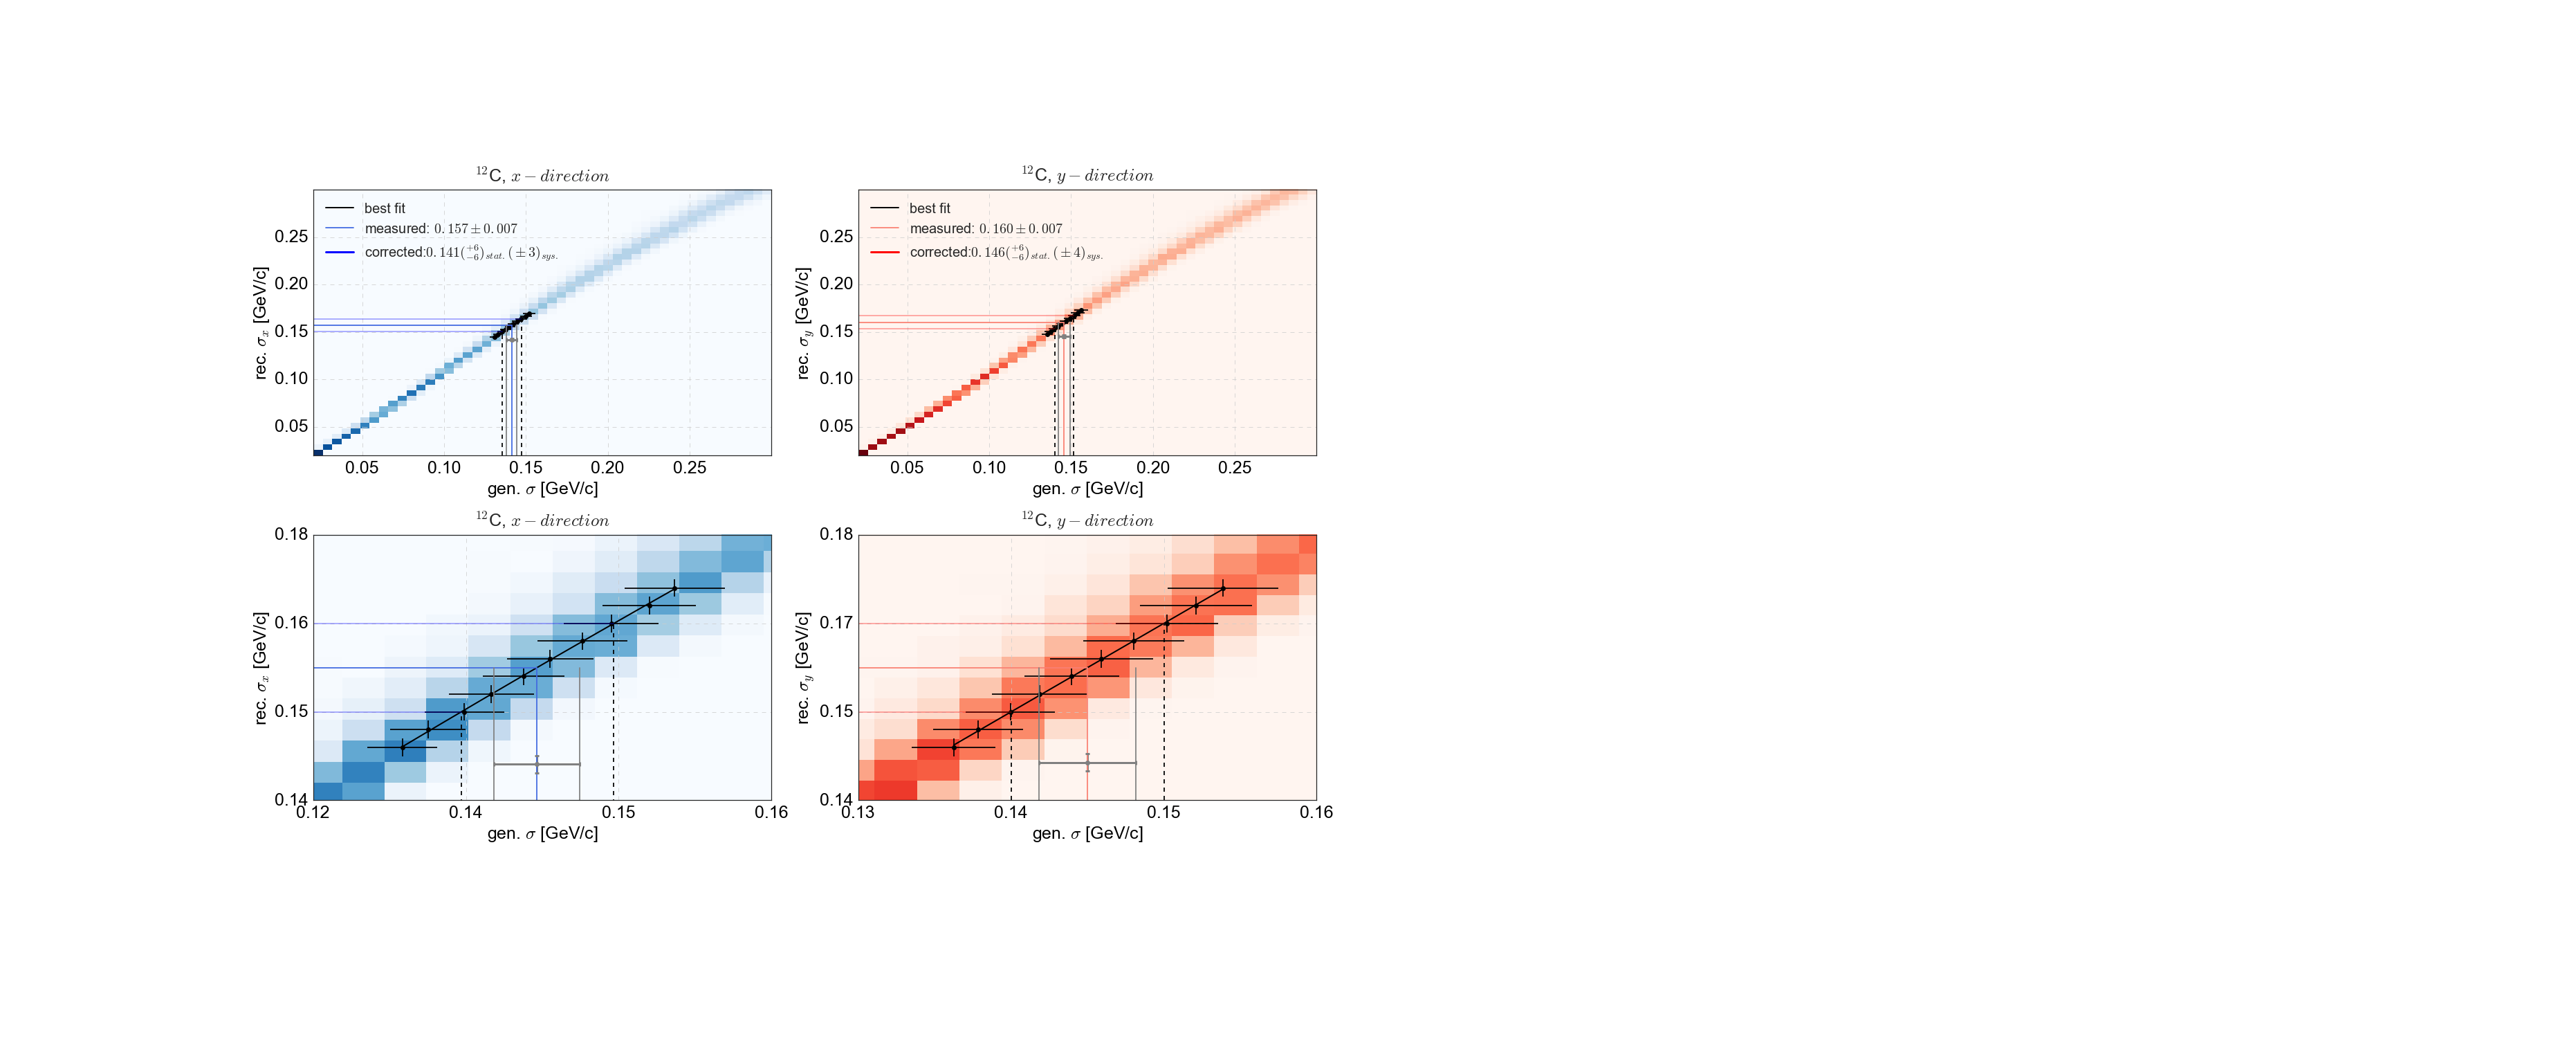

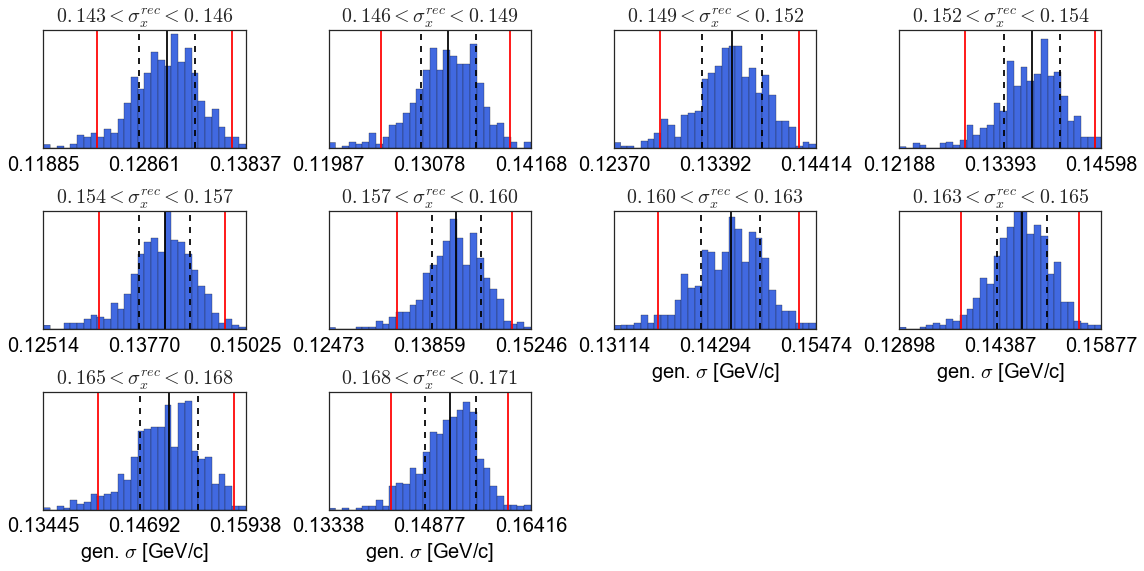

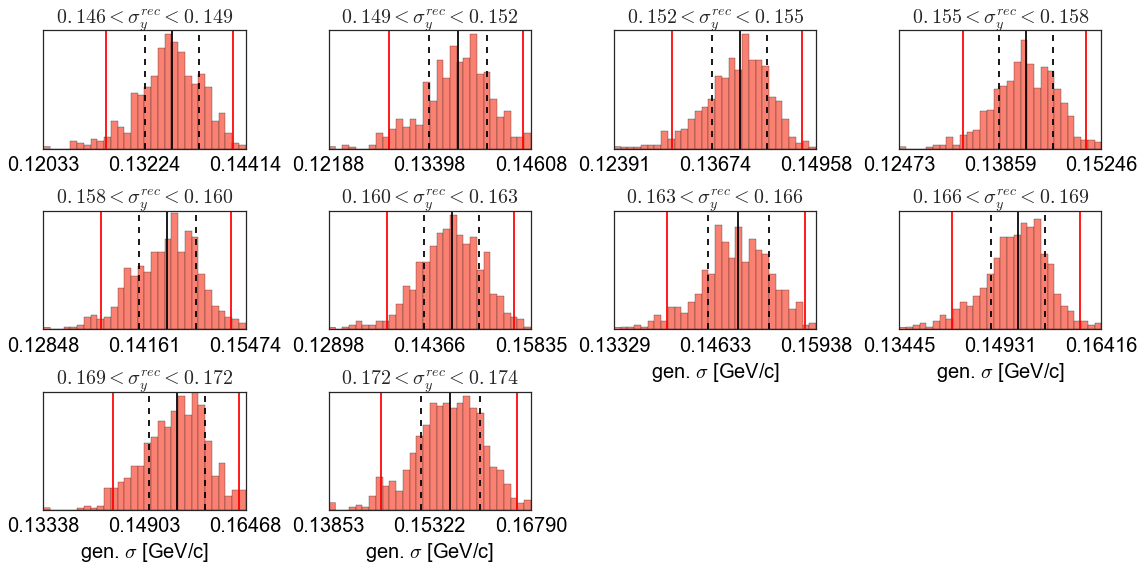

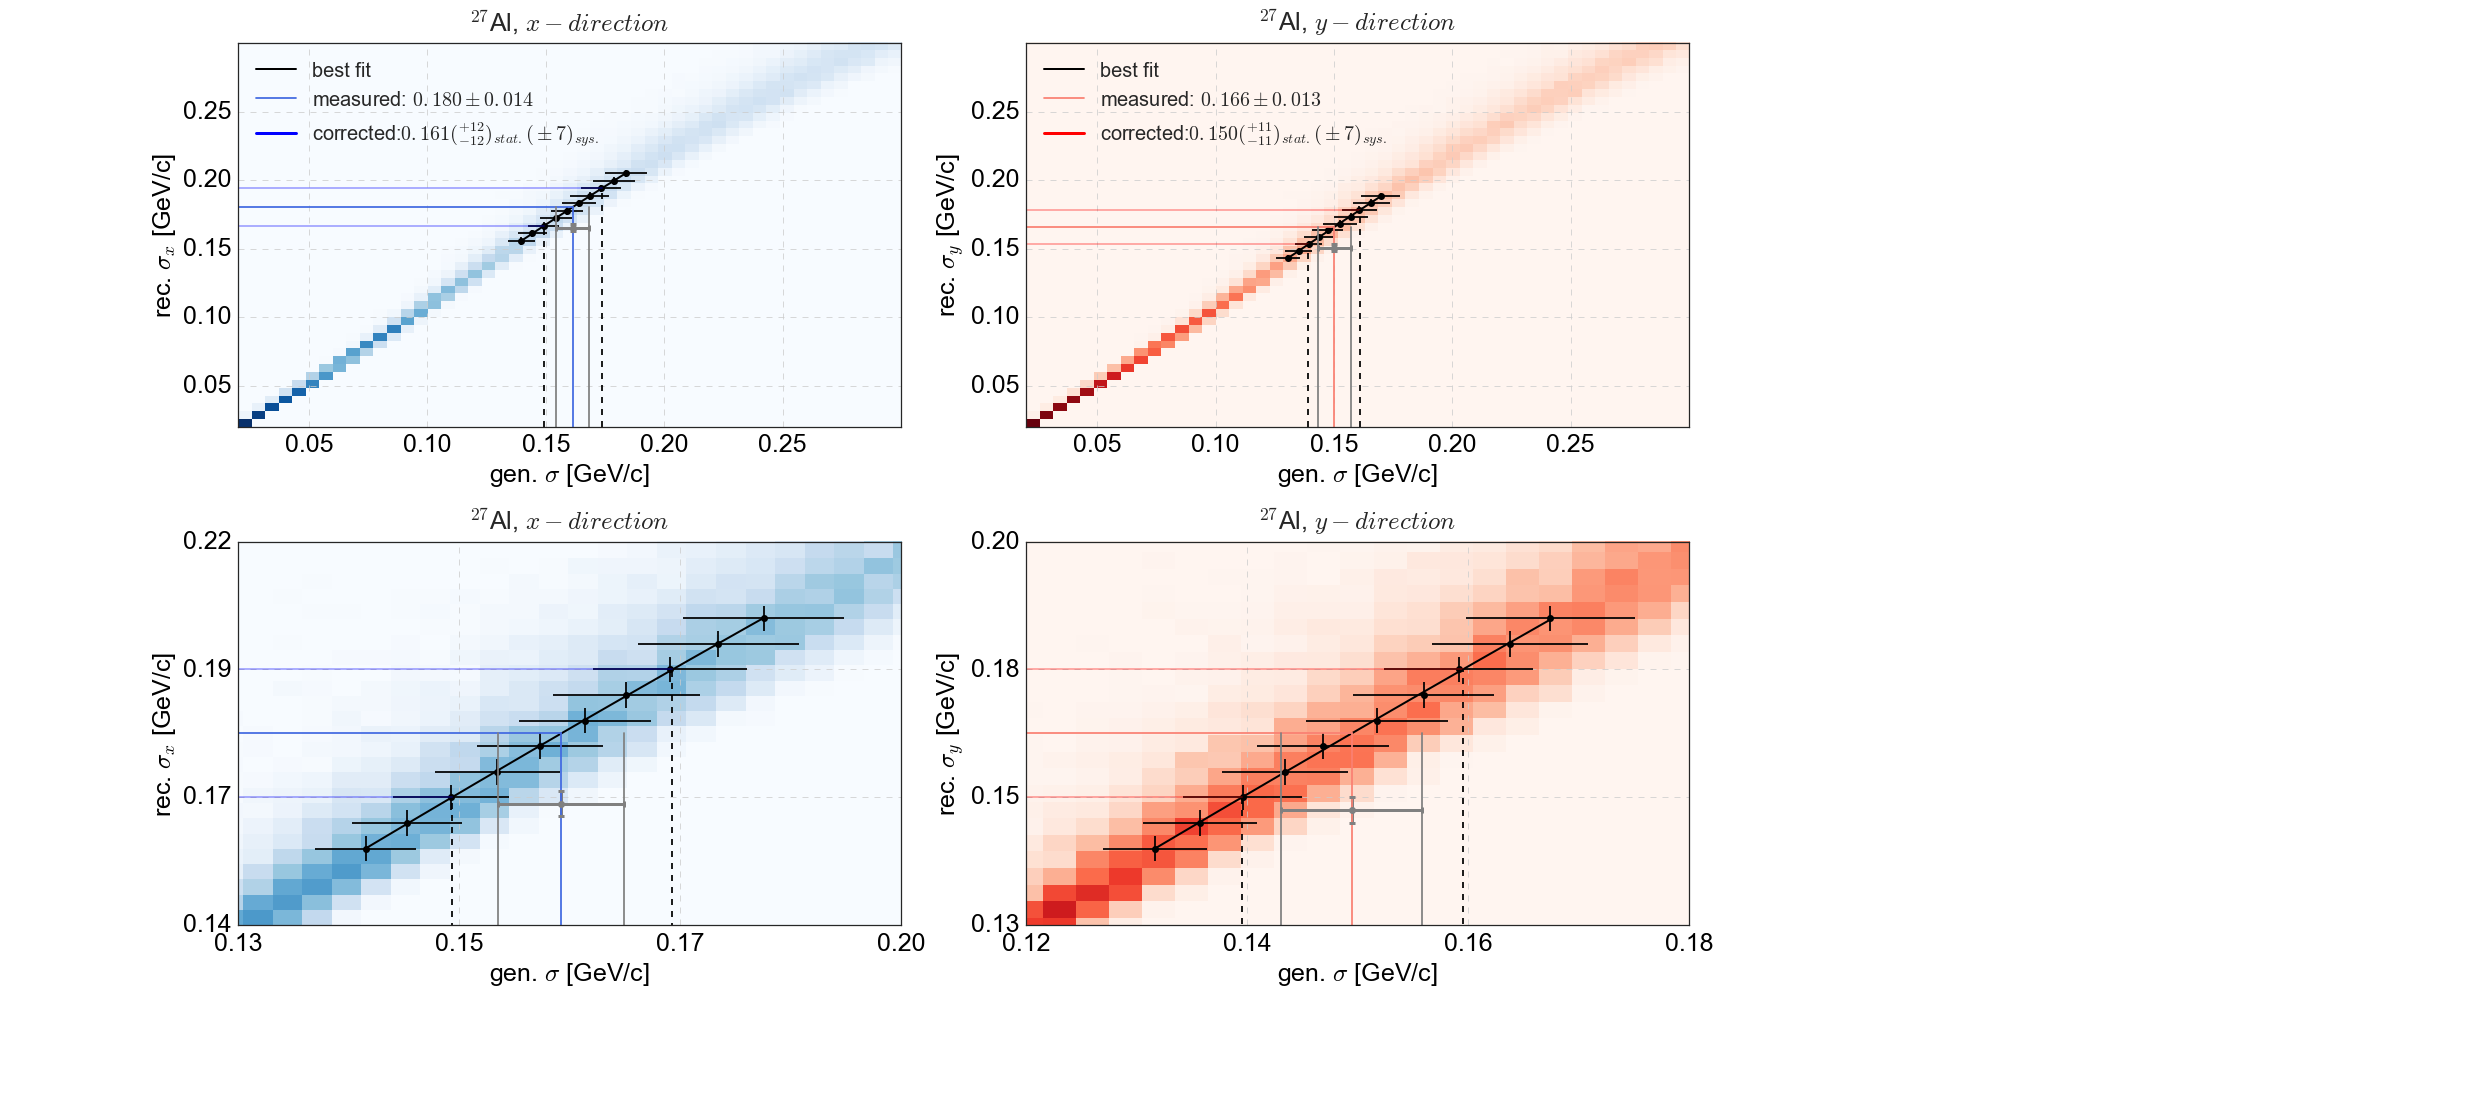

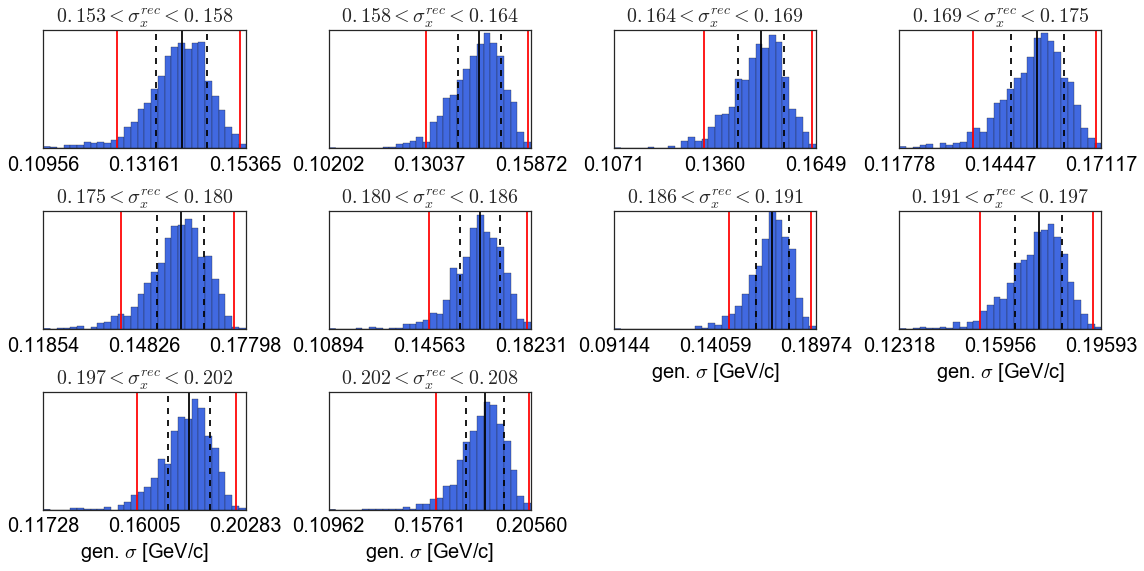

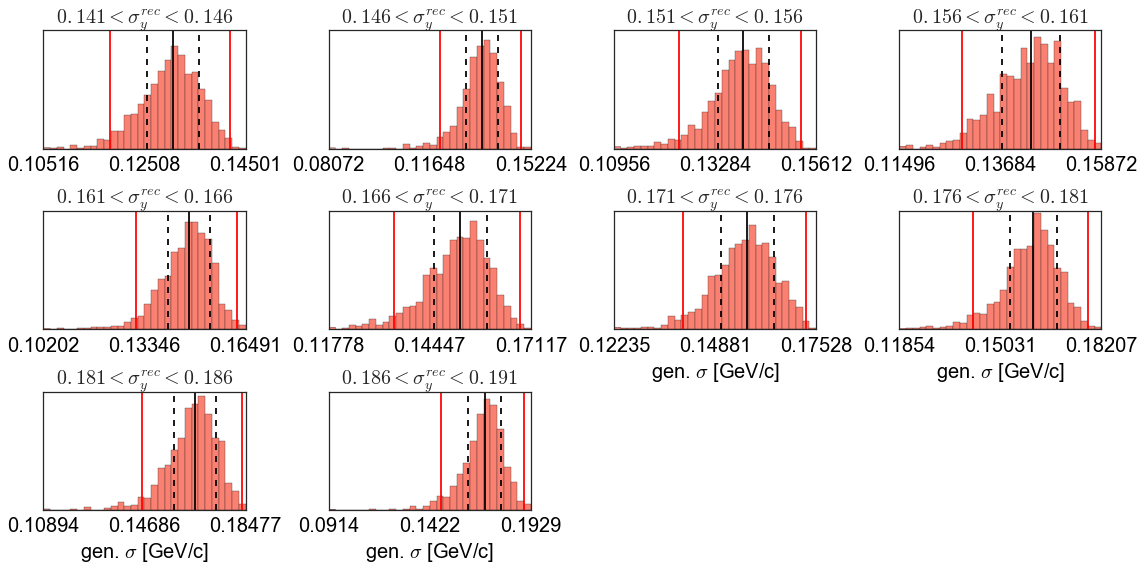

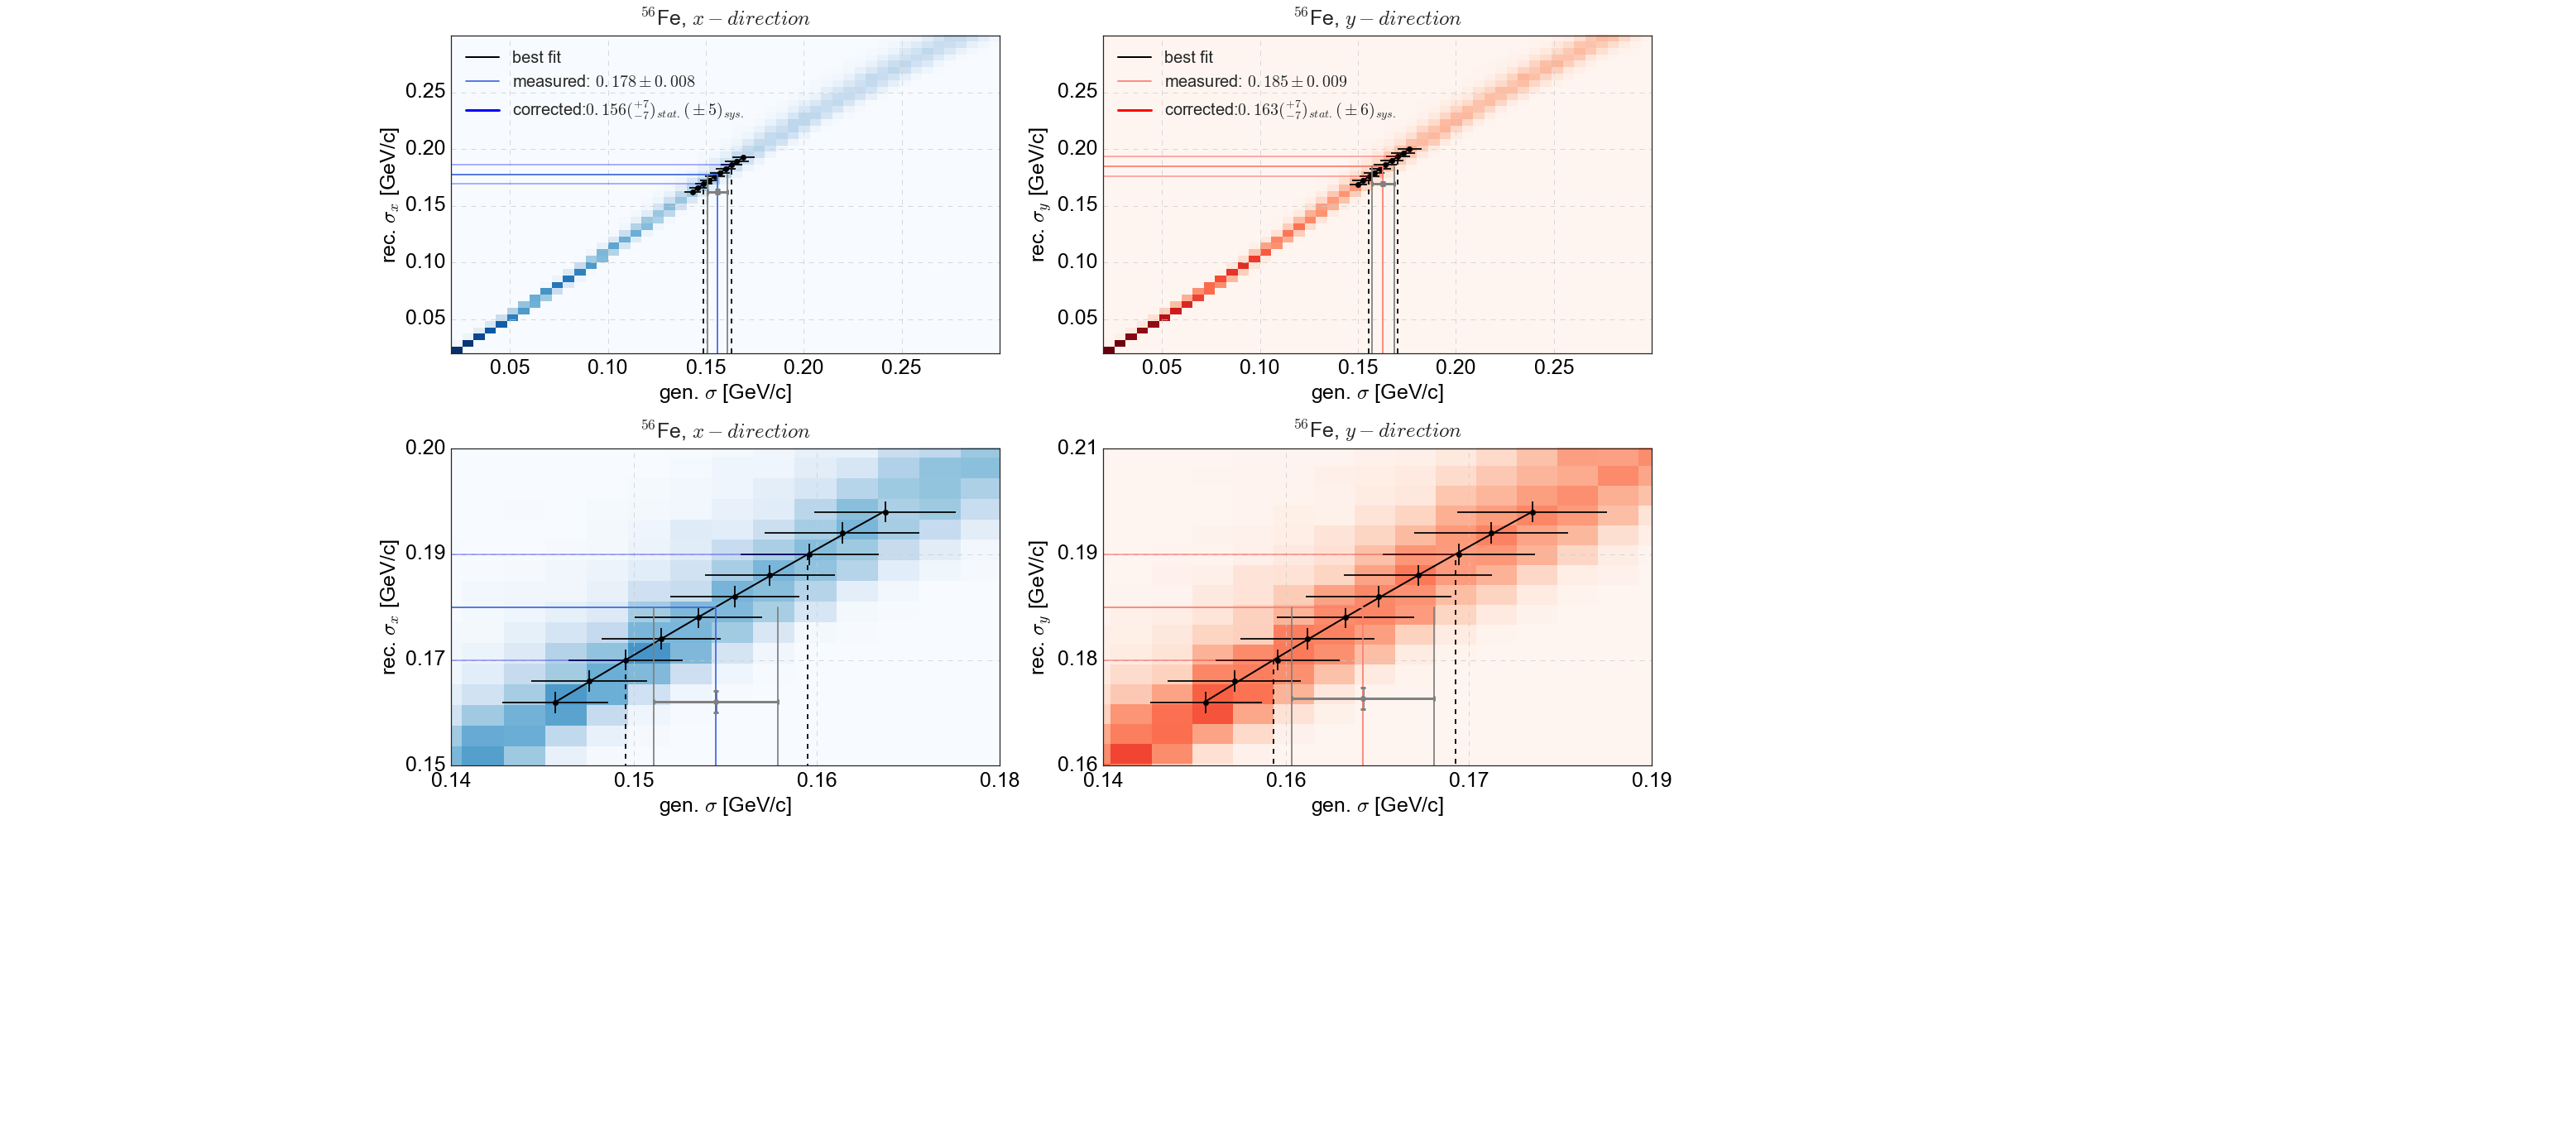

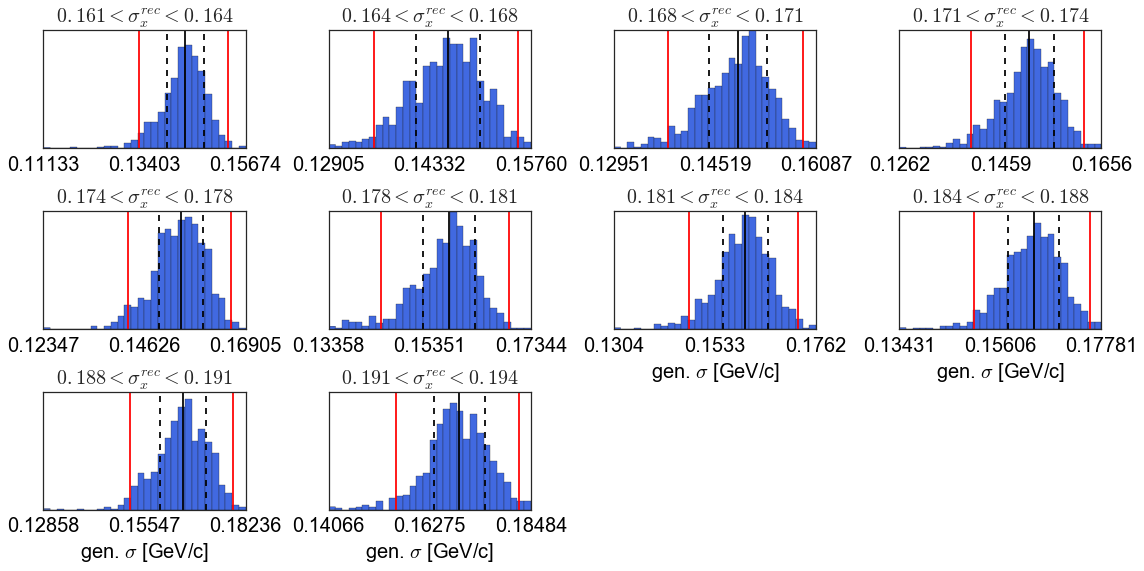

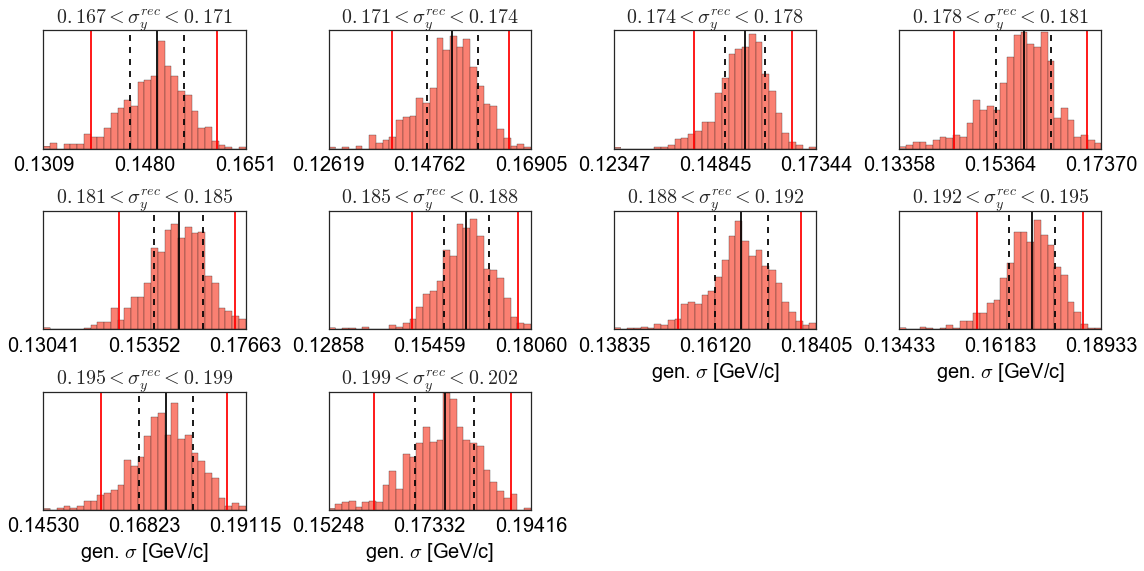

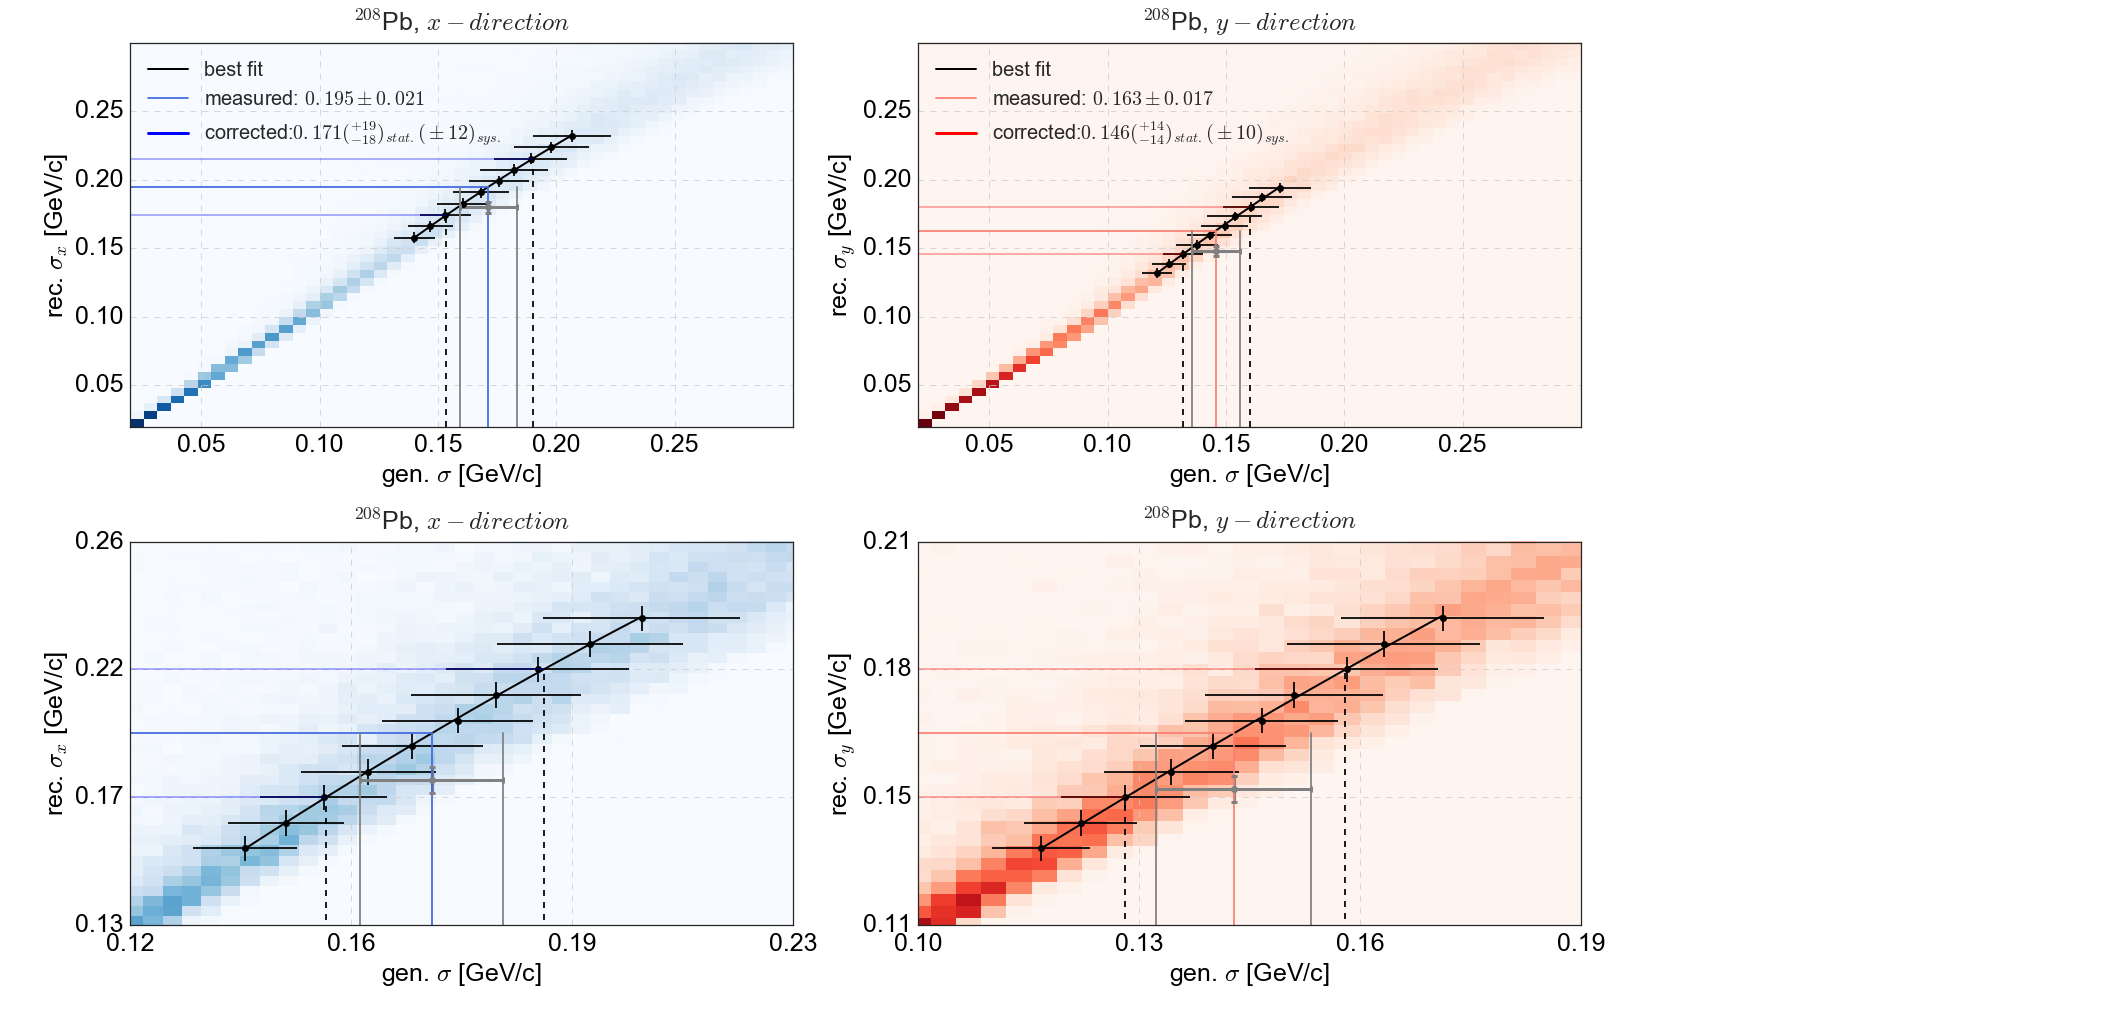

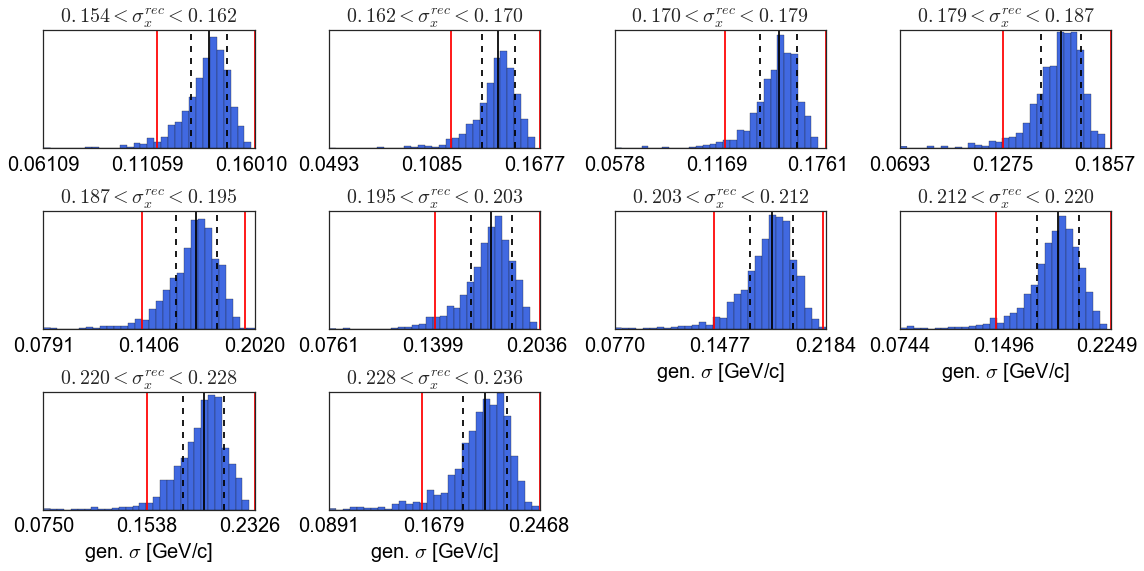

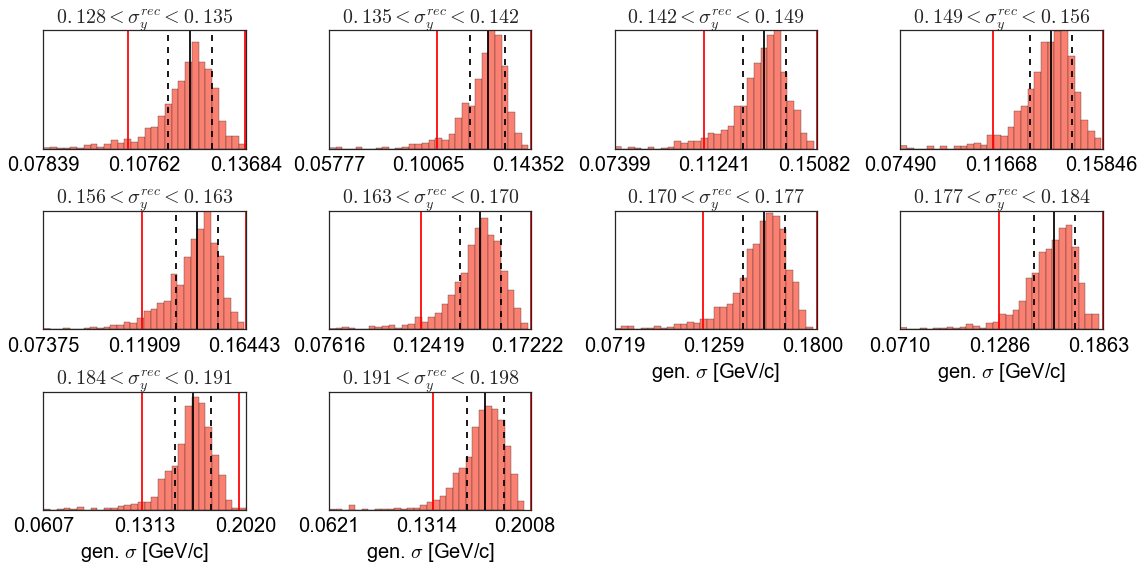

In [8]:
poly_degree = 2 # fit polynomial degree
extraname=''
for i,(A,target) in enumerate(zip(As[0:],targets[0:])):
    test_name = "simulations_"+Fiducials+"_"+target
    sims=simulation_results[test_name]        
    good_results = sims[
            (sims['gen_SigmaZ']>0)&(sims['rec_sigma_x']>0)&(sims['rec_sigma_y']>0)&(sims['rec_sigma_z']>0)
            &(sims['rec_mean_x']>-0.9)&(sims['rec_mean_y']>-0.9)&(sims['rec_mean_x']>-0.9)]
    fig=plt.figure(figsize=(22,14))
    ax=fig.add_subplot(2,2,1)    
    plot_cm_direction_binned(sims=good_results, ax=ax,s=3,extraname=extraname
                                    ,poly_degree=poly_degree
                                    ,A=A,direction='x'
                                    ,colors=['blue','royalblue','Blues'],debug=0,do_add_1Ddist_in_slices=True)
    ax=fig.add_subplot(2,2,3)    
    plot_cm_direction_binned(sims=good_results, ax=ax,s=3,extraname=extraname
                                    ,poly_degree=poly_degree
                                    ,A=A,direction='x'
                                    ,colors=['blue','royalblue','Blues'],debug=0
                             ,do_zoom_in=True ,do_add_1Ddist_in_slices=False,do_add_legend=False)

    ax=fig.add_subplot(2,2,2)
    plot_cm_direction_binned(sims=good_results, ax=ax,s=3,extraname=extraname
                                    ,poly_degree=poly_degree if A!=12 else 1
                                    ,A=A,direction='y'
                                    ,colors=['red','salmon','Reds'],debug=0,do_add_1Ddist_in_slices=True)
    ax=fig.add_subplot(2,2,4)
    plot_cm_direction_binned(sims=good_results, ax=ax,s=3,extraname=extraname
                                    ,poly_degree=poly_degree if A!=12 else 1
                                    ,A=A,direction='y'
                                    ,colors=['red','salmon','Reds'],debug=0
                             ,do_zoom_in=True ,do_add_1Ddist_in_slices=False,do_add_legend=False)

    fig.subplots_adjust(bottom=-0.5,left=-0.2)
    fig.tight_layout() 
    filename = figures_path+'St_gen_rec_'+target+'.png' if extraname=='' else figures_path+'St_gen_rec_'+target+'_'+extraname+'.png'    
    fig.savefig( filename )

In [9]:
def compute_sys_uncertainty(sims=None
                             ,Fiducials='PrecFiducials',extraname=""                              
                             ,A=12
                             ,direction='x'
                             ,Nbins_st_rec=10 # GeV/c
                             ,debug=0):
    '''
    return:
            bin width (in \sigma_rec)
            systematical uncertainty
    '''
    
    # measured \sigma_t (DATA)
    cm_pars = cm_parameters[Fiducials]        
    cm_tgt = cm_pars[cm_pars['A']==A]
    sigma_meas = float(cm_tgt['sigma_'+direction+'_before_acc_corr'])
    sigma_meas_err = float(cm_tgt['sigma_'+direction+'_before_acc_corr_err'])

    # region of interest: 2$\sigma$ around measured value
    roi_min = sigma_meas - 2*sigma_meas_err
    roi_max = sigma_meas + 2*sigma_meas_err
    roi_width = roi_max - roi_min
    # create bins in region of interest
    roi_sims = sims[(sims['rec_sigma_'+direction]>roi_min)&(sims['rec_sigma_'+direction]<roi_max)]    

    bin_st_rec_width = roi_width/Nbins_st_rec
    sims_bin_meas = roi_sims[(roi_sims['rec_sigma_'+direction]>(sigma_meas - 0.5*bin_st_rec_width))
                             &(roi_sims['rec_sigma_'+direction]<(sigma_meas + 0.5*bin_st_rec_width))]        
    bin_st_gen_mean = np.mean(sims_bin_meas['gen_Sigma_t'])
    bin_st_gen_std = np.std(sims_bin_meas['gen_Sigma_t'])
    # -->
    sims_bin_meas_trimmed = sims_bin_meas[(sims_bin_meas['gen_Sigma_t']>bin_st_gen_mean-2*bin_st_gen_std)                                  
                                          &(sims_bin_meas['gen_Sigma_t']<bin_st_gen_mean+2*bin_st_gen_std)]
    bin_st_gen_mean = np.mean(sims_bin_meas_trimmed['gen_Sigma_t'])
    bin_st_gen_std = np.std(sims_bin_meas_trimmed['gen_Sigma_t'])
    corr_val_err_sys = bin_st_gen_std 
    
    return bin_st_rec_width , corr_val_err_sys

target: C
target: Al
target: Fe
target: Pb


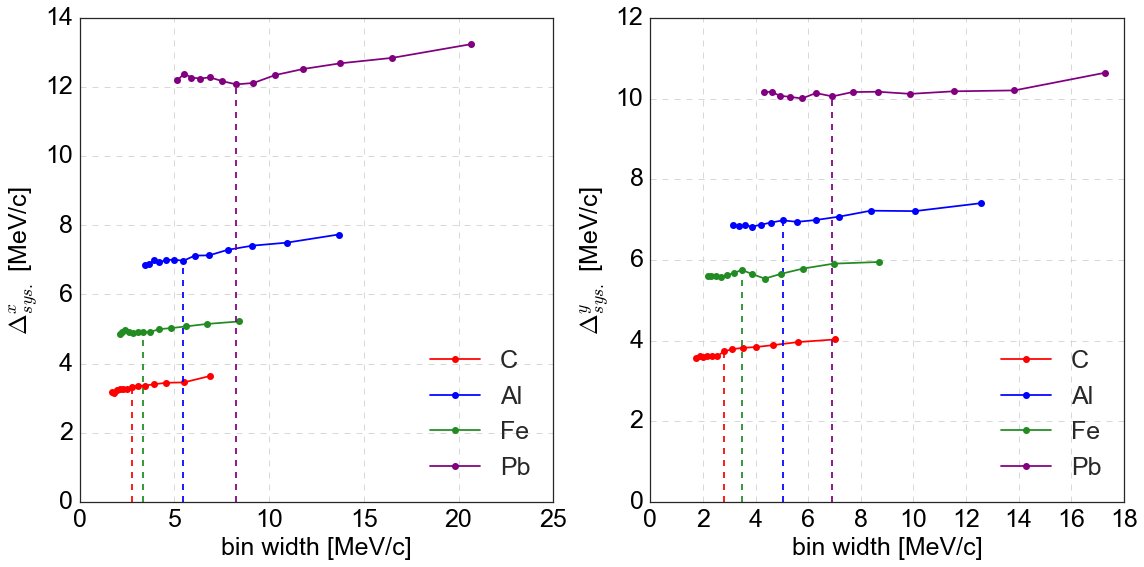

In [10]:
bin_width_x = dict()
sys_unc_x = dict()

bin_width_y = dict()
sys_unc_y = dict()

fig = plt.figure(figsize=(16,8))

for i,(A,target,color) in enumerate(zip(As[0:],targets[0:],colors[0:])):
    print 'target:',target
#     test_name = "ModifiedNrand_"+target
    test_name = "simulations_"+Fiducials+"_"+target
    sims=simulation_results[test_name]        
    good_results = sims[
            (sims['gen_SigmaZ']>0)&(sims['rec_sigma_x']>0)&(sims['rec_sigma_y']>0)&(sims['rec_sigma_z']>0)
            &(sims['rec_mean_x']>-0.9)&(sims['rec_mean_y']>-0.9)&(sims['rec_mean_x']>-0.9)]

    bin_width_x[target] = []
    sys_unc_x[target] = []
    bin_width_y[target] = []
    sys_unc_y[target] = []

    for Nbins_st_rec in [4,5,6,7,8,9,10,11,12,13,14,15,16]:
        bin_st_rec_width_x , corr_val_err_sys_x = compute_sys_uncertainty(sims=good_results
                                                                          ,A=A,direction='x',debug=0
                                                                          ,Nbins_st_rec=Nbins_st_rec)
        bin_width_x[target].append(bin_st_rec_width_x)
        sys_unc_x[target].append(corr_val_err_sys_x)
        
        bin_st_rec_width_y , corr_val_err_sys_y = compute_sys_uncertainty(sims=good_results
                                                                          ,A=A,direction='y',debug=0
                                                                          ,Nbins_st_rec=Nbins_st_rec)
        bin_width_y[target].append(bin_st_rec_width_y)
        sys_unc_y[target].append(corr_val_err_sys_y)
        
        if Nbins_st_rec==10:
            ax = fig.add_subplot(1,2,1)
            ax.plot([1000*bin_st_rec_width_x,1000*bin_st_rec_width_x],[0,1000*corr_val_err_sys_x],'--',color=color)
            ax = fig.add_subplot(1,2,2)
            ax.plot([1000*bin_st_rec_width_y,1000*bin_st_rec_width_y],[0,1000*corr_val_err_sys_y],'--',color=color)


        
    ax = fig.add_subplot(1,2,1)
    ax.plot(1000*np.array(bin_width_x[target]),1000*np.array(sys_unc_x[target]),'-o',label=target,color=color)
    ax = fig.add_subplot(1,2,2)
    ax.plot(1000*np.array(bin_width_y[target]),1000*np.array(sys_unc_y[target]),'-o',label=target,color=color)

ax = fig.add_subplot(1,2,1)
set_axes(ax,'bin width [MeV/c]',r'$\Delta_{sys.}^{x}$ [MeV/c]',do_add_legend=True,do_add_grid=True)
ax = fig.add_subplot(1,2,2)
set_axes(ax,'bin width [MeV/c]',r'$\Delta_{sys.}^{y}$ [MeV/c]',do_add_legend=True,do_add_grid=True)

plt.tight_layout()
plt.savefig(figures_path + 'Delta_sys_vs_bin_width.pdf')

# Compute the final $\sigma_t$

In [50]:
sample = cm_parameters_with_correction['PrecFiducials']
extraname = ''

for direction in ['x','y']:
    sample['sigma_'+direction+extraname+'_final'] = sample['sigma_'+direction+'_corrected'+extraname]
    for updw in ['up','dw']:
        sample['sigma_'+direction+extraname+'_final_'+updw+'_err'] = sample['sigma_'+direction+'_corrected_'+updw+'_err_tot'+extraname]

corr_x = sample['sigma_x_corrected'+extraname]
Dcorr_x = sample['sigma_x_corrected_err_tot'+extraname]
sample['sigma_x_final_Err'+extraname] = sample['sigma_x_corrected_err_tot'+extraname]

corr_y = sample['sigma_y_corrected'+extraname]
Dcorr_y = sample['sigma_y_corrected_err_tot'+extraname]
sample['sigma_y_final_Err'+extraname] = sample['sigma_y_corrected_err_tot'+extraname]


# weighted average
corr_t = (corr_x/np.square(Dcorr_x)+corr_y/np.square(Dcorr_y))/( 1./np.square(Dcorr_x) + 1./np.square(Dcorr_y))
sample['sigma_t'+extraname+'_final'] = corr_t
    
Dsys_x = sample['sigma_x_corrected_err_sys'+extraname]
Dsys_y = sample['sigma_y_corrected_err_sys'+extraname]
Dsys_t = 0.5*( Dsys_x + Dsys_y )
# Dsys_t = np.sqrt(1./( 1./np.square(Dsys_x) + 1./np.square(Dsys_y) ))
sample['sigma_t'+extraname+'_final_err_sys'] = Dsys_t


for updw in ['up','dw']:            
    Dstat_x = sample['sigma_x_corrected_'+updw+'_err_stat'+extraname]
    Dstat_y = sample['sigma_y_corrected_'+updw+'_err_stat'+extraname]
    #     Dstat_t = 0.5*np.sqrt( np.square(Dstat_x) + np.square(Dstat_y) )
    Dstat_t = np.sqrt(1./( 1./np.square(Dstat_x) + 1./np.square(Dstat_y) ))
    sample['sigma_t'+extraname+'_final_'+updw+'_err_stat'] = Dstat_t

    Dtot_t = np.sqrt( np.square(Dstat_t) + np.square(Dsys_t) )
    sample['sigma_t'+extraname+'_final_'+updw+'_err_tot'] = Dtot_t
    sample['sigma_t'+extraname+'_final_'+updw+'_err'] = Dtot_t


sample['sigma_t_final'] = corr_t
sample['sigma_t_final_err_sys'] = sample['sigma_t_final_err_sys']

In [51]:
cm_parameters_with_correction['PrecFiducials'][['sigma_t_before_acc_corr','sigma_t_before_acc_corr_err'
                                                ,'sigma_t_final'
                                                ,'sigma_t_final_up_err','sigma_t_final_dw_err']].astype(float)

sigma_t_before_acc_corr  sigma_t_before_acc_corr_err  sigma_t_final  \
0                 0.158720                     0.004904       0.143455   
1                 0.172366                     0.009252       0.155257   
2                 0.180959                     0.006040       0.159052   
3                 0.176265                     0.013257       0.155679   

   sigma_t_final_up_err  sigma_t_final_dw_err  
0              0.005478              0.005453  
1              0.010765              0.010678  
2              0.007448              0.007344  
3              0.015949              0.015610

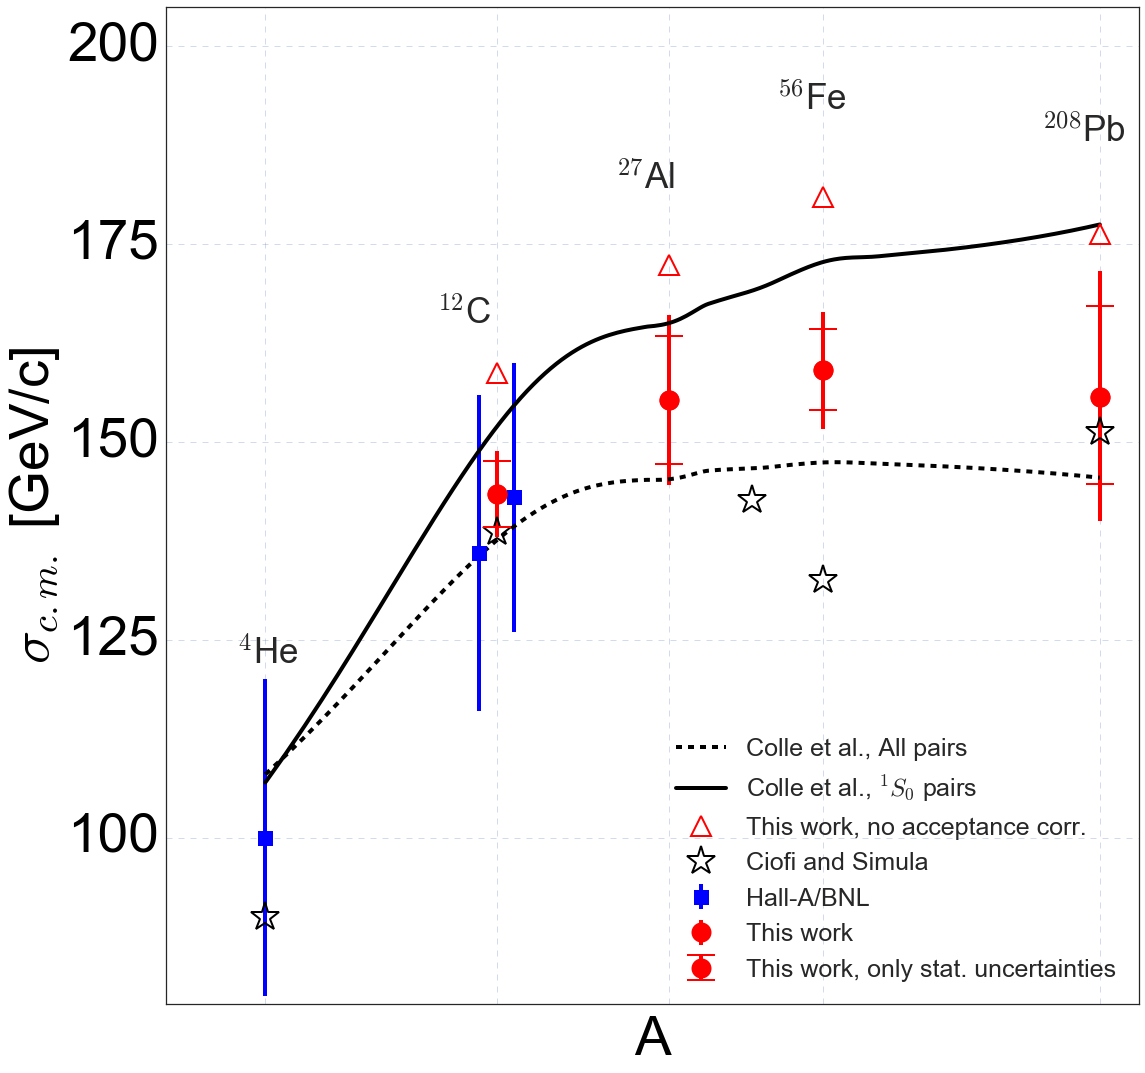

In [53]:
extraname=''
ax = plot_needed_for_A_depdendence_sigma_t(ylim=(79,205),labels=dict({'$^4$He':(3.5,122),
                                            '$^{12}$C':(9,165), '$^{27}$Al':(21,182),
                                            '$^{56}$Fe':(45,192), '$^{208}$Pb':(158,188), }),do_Ciofi=True)

plot_data_assymetric( data=cm_parameters_with_correction['PrecFiducials'],direction='t',ax=ax, label="This work" , marker='o', markersize=20 )
plt.legend(fontsize=20,loc='upper left')
# measured
ax.plot(cm_pars['A'], 1000*cm_pars['sigma_t_before_acc_corr'] ,mec='red' , marker='^' ,mfc='none',lw = 2, mew = 2, ms = 20, linewidth=0, label='This work, no acceptance corr.')
plot_data_assymetric( data=cm_parameters_with_correction['PrecFiducials'] ,direction='t', unc_name='stat' , ax=ax, label="This work, only stat. uncertainties" , marker='o', markersize=20 , capthick=2 , capsize=14)

ax.legend(fontsize=25,loc='lower right')
plt.tight_layout()
plt.savefig(figures_path +'results.pdf')    

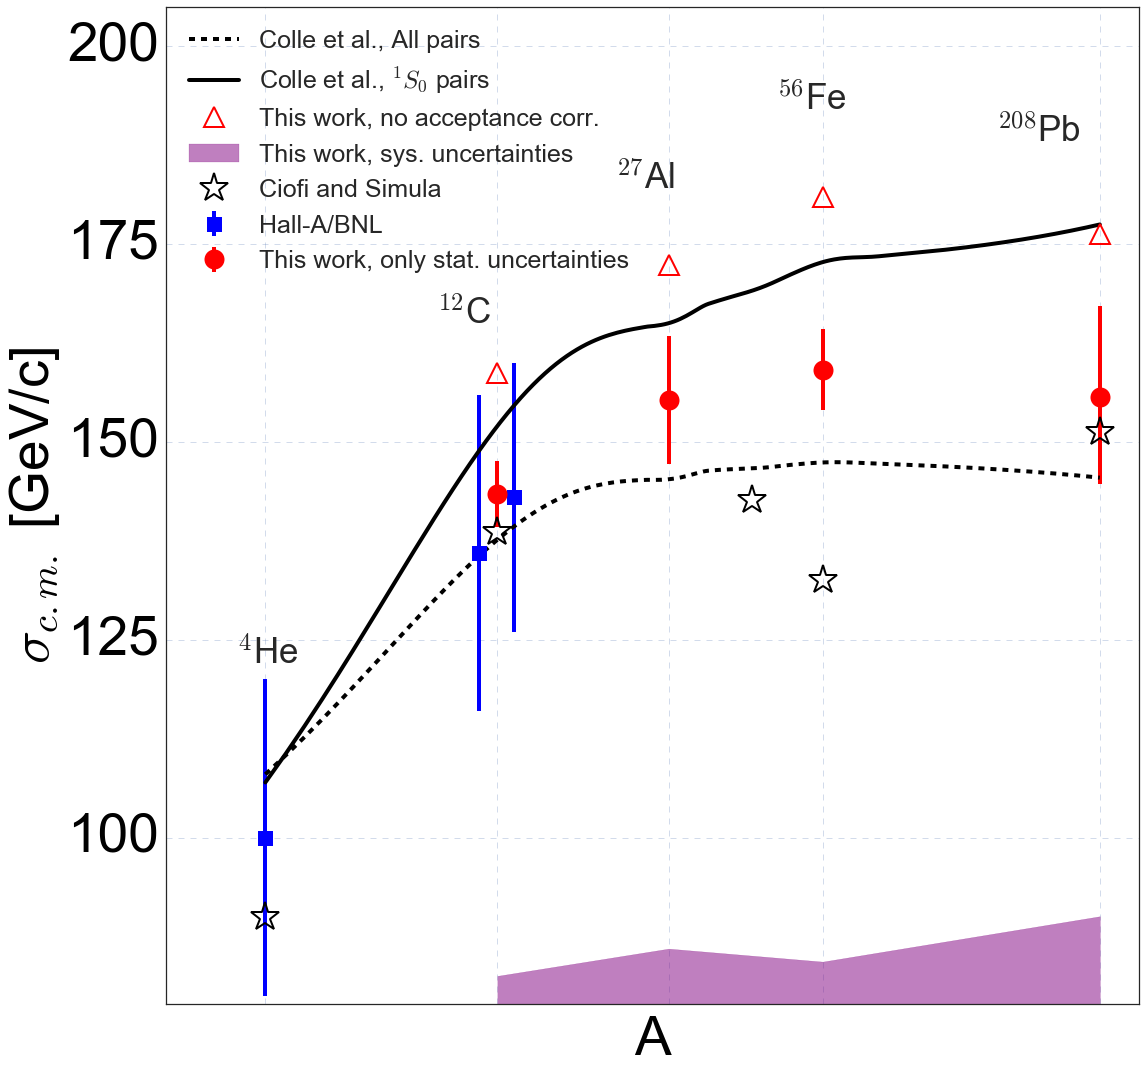

In [14]:
# separate sys. unc. as a band along the abscissa
ax = plot_needed_for_A_depdendence_sigma_t(ylim=(79,205),labels=dict({'$^4$He':(3.5,122),
                                            '$^{12}$C':(9,165), '$^{27}$Al':(21,182),
                                            '$^{56}$Fe':(45,192), '$^{208}$Pb':(128,188), }),do_Ciofi=True)
data=cm_parameters_with_correction['PrecFiducials']
plot_data_assymetric( data=cm_parameters_with_correction['PrecFiducials'] ,direction='t', unc_name='stat' , ax=ax, label="This work, only stat. uncertainties" , marker='o', markersize=20 )
plt.legend(fontsize=20,loc='upper left')
# measured
ax.plot(cm_pars['A'], 1000*cm_pars['sigma_t_before_acc_corr'] ,mec='red' , marker='^' ,mfc='none',lw = 2, mew = 2, ms = 20, linewidth=0, label='This work, no acceptance corr.')
[]
# add a band of systematical uncertaintes
ax.fill_between(cm_pars['A']
                , np.min(ax.get_ylim()), np.min(ax.get_ylim()) + 1000*data['sigma_t_final_err_sys'] 
                , color='purple' , alpha=0.5 ,  label='This work, sys. uncertainties')

ax.legend(fontsize=25,loc='upper left')
plt.tight_layout()
plt.savefig(figures_path+'results_sys_band.pdf')    

# $x$ and $y$ directions seperately

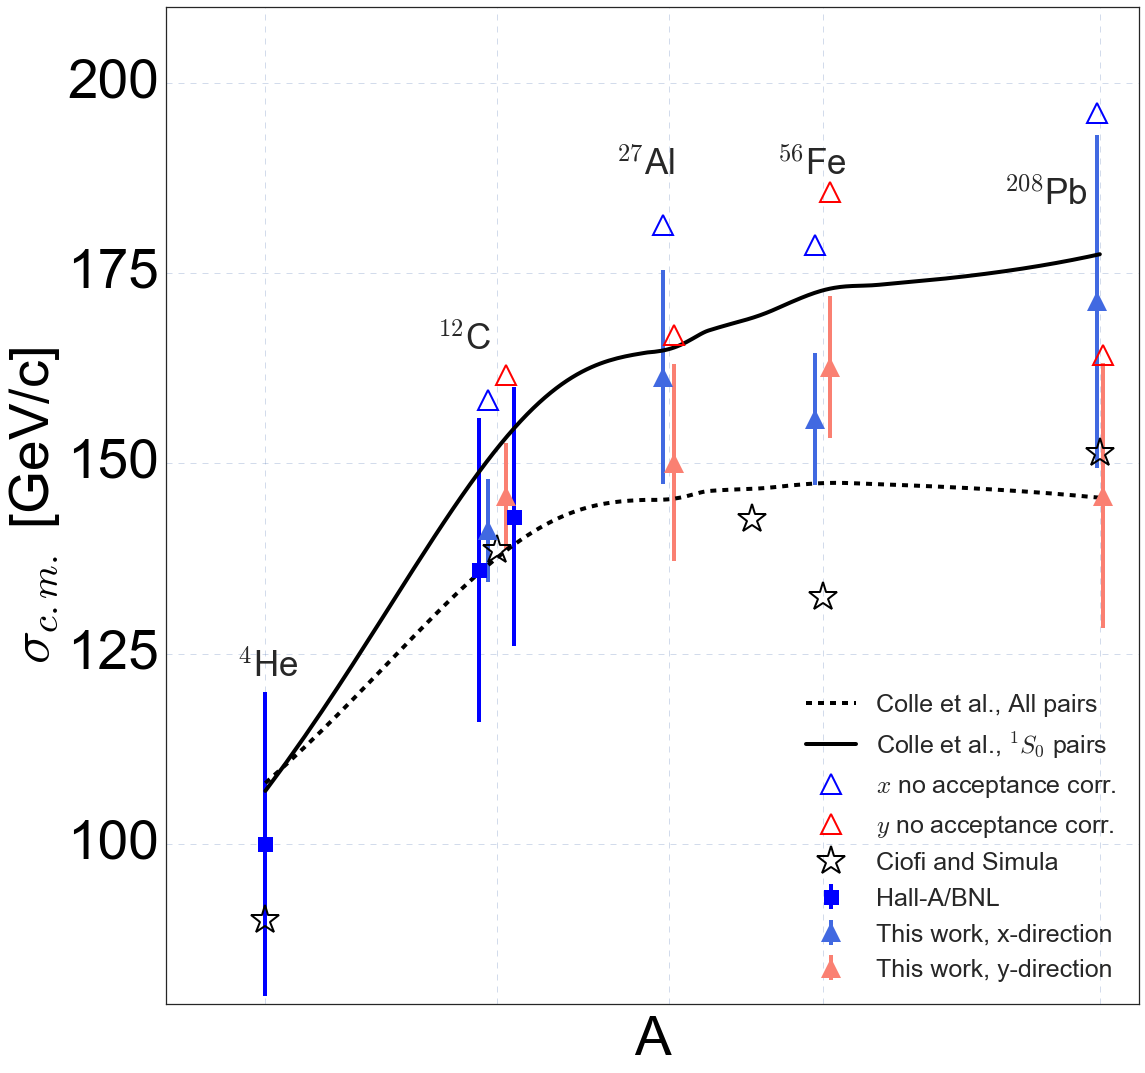

In [47]:
ax = plot_needed_for_A_depdendence_sigma_t(ylim=(79,210),labels=dict({'$^4$He':(3.5,122),
                                            '$^{12}$C':(9,165),
                                            '$^{27}$Al':(21,188),
                                            '$^{56}$Fe':(45,188),
                                            '$^{208}$Pb':(132,184),
                                           }))
ax.plot(cm_pars['A']+[-0.5,-0.7,-2,-3], 1000*cm_pars['sigma_x_unweighted'] ,mec='blue' , marker='^' ,mfc='none',lw = 2, mew = 2, ms = 20, linewidth=0, label='$x$ no acceptance corr.')
plot_data( data=cm_parameters_with_correction['PrecFiducials'], ax=ax, Ashift=[-0.5,-0.7,-2,-3] , direction='x', label='This work, x-direction', color='royalblue',markersize=20 )
ax.plot(cm_pars['A']+[0.5,0.7,2,3], 1000*cm_pars['sigma_y_unweighted'] ,mec='red' , marker='^' ,mfc='none',lw = 2, mew = 2, ms = 20, linewidth=0, label='$y$ no acceptance corr.')
plot_data( data=cm_parameters_with_correction['PrecFiducials'], ax=ax, Ashift=[0.5,0.7,2,3] ,direction='y', label='This work, y-direction', color='salmon', markersize=20 )
ax.legend(fontsize=25,loc='lower right')
plt.tight_layout()
plt.savefig( figures_path + 'corrected_sigma_xy_with_calculations.pdf')

# compare with previous results presented in WI

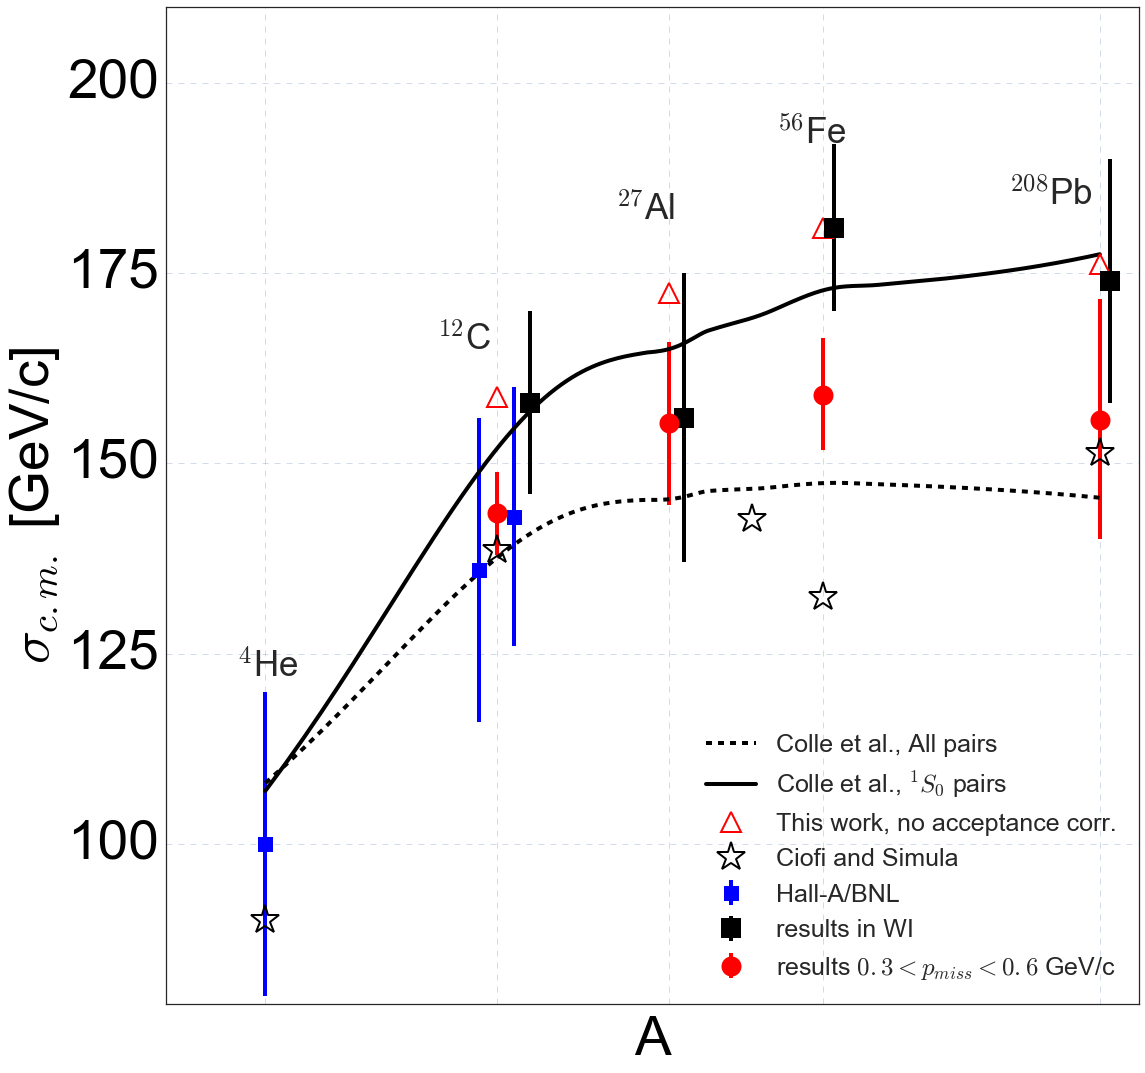

In [56]:
ax = plot_needed_for_A_depdendence_sigma_t(ylim=(79,210),labels=dict({'$^4$He':(3.5,122),
                                            '$^{12}$C':(9,165), '$^{27}$Al':(21,182),
                                            '$^{56}$Fe':(45,192), '$^{208}$Pb':(135,184), }))
ax.plot(cm_pars['A'], 1000*cm_pars['sigma_t_before_acc_corr'] ,mec='red' , marker='^' ,mfc='none',lw = 2, mew = 2, ms = 20, linewidth=0, label='This work, no acceptance corr.')
plot_data( data=WI_Data, ax=ax,label='results in WI',Ashift=[2,2,3,10],  markersize=20 , marker='s', color='black')
plot_data_assymetric( data=cm_parameters_with_correction['PrecFiducials'],ax=ax, label='results $0.3<p_{miss}<0.6$ GeV/c', marker='o', markersize=20 )
ax.legend(fontsize=25, loc='lower right')
plt.tight_layout()
plt.savefig( figures_path + 'corrected_sigma_t_vs_WI_results.pdf')

# Fiducial cuts vs. no Fiducial cuts

# compare constant band around mean(z) & \sigma(z) with 5  ×Δmeasured 

# compare mean(z) linear in $p_{miss}$ (slope$\times(p_{miss}-0.3)$) with 5 $\times \Delta_{measured}$

# compare with a method that looks for the minimal window with 68% confidence integral in each bin
The quasi-data point would be the mean value of $\sigma_{gen}$ in this bin,
and the uncertaintly would be the distance from the right and left sides of the 68% interval

In [15]:
def interval_68_from_start_point( a=None, start_x = -np.inf, dx=0.001 , debug=0):
    '''
    return the end point of the 68% interval starting at start_x
    '''
    end_x = start_x
    frac = 0
    N_tot = len(a[a<np.inf])
    step = 0
    while( frac < 0.68 ):#{
        end_x = end_x + dx
        N_start_end = len(a[(a>start_x)&(a<end_x)])
        frac = float(N_start_end)/N_tot
        step += 1
        if step>1000: break
    #}
    if debug: print 'frac:',frac
    return end_x

def find_smallest_interval( a=None, dx=0.001 ):
    l_interval = 10000
    for start_x in np.arange(np.min(a),np.mean(a)+np.std(a),dx):
        # print 'start_x:',start_x
        end_x = interval_68_from_start_point(start_x=start_x,a=a,dx=dx)
        if ((end_x-start_x) < l_interval):
            l_interval = end_x-start_x
            interval = [start_x,end_x]
    return interval

In [16]:
def plot_cm_direction_binned_confidence68(sims=None
                             ,Fiducials='PrecFiducials',extraname=""                              
                             ,ax=None,A=12,poly_degree=3
                             ,direction='x',colors=['blue','royalblue'],s=1
                             ,Nbins_st_rec=10 # GeV/c
                             ,do_add_1Ddist_in_slices=True
                             ,debug=0
                             ,do_zoom_in=False
                             ,do_add_legend=True):

        
    # measured \sigma_t (DATA)
    cm_pars = cm_parameters[Fiducials]        
    cm_tgt = cm_pars[cm_pars['A']==A]
    index = cm_pars[cm_pars['A']==A].index
    if debug>1: print cm_tgt
    sigma_meas = float(cm_tgt['sigma_'+direction+'_before_acc_corr'])
    sigma_meas_err = float(cm_tgt['sigma_'+direction+'_before_acc_corr_err'])
    
    title = cm_tgt['target'].to_string(index=False) + ', $'+direction+'-direction$'
    if debug: print title

    # region of interest: 2$\sigma$ around measured value
    roi_min = sigma_meas - 2*sigma_meas_err
    roi_max = sigma_meas + 2*sigma_meas_err
    roi_width = roi_max - roi_min
    if debug: print '\sigma_t roi: %.3f->%.3f GeV/c'%(roi_min,roi_max)
    # create bins in region of interest
    roi_sims = sims[(sims['rec_sigma_'+direction]>roi_min)&(sims['rec_sigma_'+direction]<roi_max)]
    
    
    gen,rec = sims['gen_Sigma_t'],sims['rec_sigma_'+direction]
#     plt.scatter(gen,rec,color=colors[1],label='generated vs. reconstructed',s=s)
    if do_zoom_in:
        bins = np.linspace( 0.1 , 0.26 , 50)
    else:
        bins=np.linspace( 0.02 , 0.3 , 50 )
    ax.hist2d(gen,rec,cmap=colors[2],label='generated vs. reconstructed',bins=bins)#,norm=LogNorm())


    # bin in rec. sigma_t
    rec_bins,rec_bins_err,gen_bins,gen_bins_err_dw,gen_bins_err_up=[],[],[],[],[]
    bin_st_rec_width = roi_width/Nbins_st_rec
    if debug:  print 'bin_st_rec_width:',bin_st_rec_width 
    if do_add_1Ddist_in_slices:
        fig_1Ddist_in_slices = plt.figure(figsize=(16,8))

    
    for i_bin in range(Nbins_st_rec):
        if debug: print 'i_bin in reconstructed sigma(t):',i_bin
        bin_st_rec_center = roi_min + bin_st_rec_width*(i_bin+0.5)
        bin_st_rec_dw = bin_st_rec_center - 0.5*bin_st_rec_width
        bin_st_rec_up = bin_st_rec_center + 0.5*bin_st_rec_width

        sims_bin = roi_sims[(roi_sims['rec_sigma_'+direction]>bin_st_rec_dw)
                            &(roi_sims['rec_sigma_'+direction]<bin_st_rec_up)]
        # find the narrowest window with 68% interval
        interval = find_smallest_interval(a=sims_bin['gen_Sigma_t'],dx=0.001)
        sims_in_interval = sims_bin['gen_Sigma_t'][(sims_bin['gen_Sigma_t']>interval[0])&(sims_bin['gen_Sigma_t']<interval[1])]
        bin_st_gen_mean = np.mean(sims_in_interval)
        bin_st_gen_err_up = interval[1] - bin_st_gen_mean
        bin_st_gen_err_dw = bin_st_gen_mean - interval[0]
        
        if debug>1: print 'bin in \sigma_t: (%.3f-%.3f)'%(bin_st_rec_dw,bin_st_rec_up)
        if debug>1: print 'gen \sigma_t: (%.3f-%.3f)'%(bin_st_gen_err_dw,bin_st_gen_err_up)
            
        if do_add_1Ddist_in_slices:
            ax_1Ddist_in_slices = fig_1Ddist_in_slices.add_subplot(Nbins_st_rec/4+1,4,i_bin+1)
            ax_1Ddist_in_slices.hist( sims_bin['gen_Sigma_t'] , bins=30 , color=colors[1])
            set_axes(ax_1Ddist_in_slices,r'gen. $\sigma$ [GeV/c]' if i_bin>(Nbins_st_rec-5) else ''
                     ,title=r'$%.3f'%bin_st_rec_dw+'<\sigma_{'+direction+'}^{rec}<%.3f$'%bin_st_rec_up
                     ,xticks=np.linspace(np.min(sims_bin['gen_Sigma_t']),np.max(sims_bin['gen_Sigma_t']),3)
                     ,fontsize=20)
            ax_1Ddist_in_slices.plot( [bin_st_gen_mean,bin_st_gen_mean] , ax_1Ddist_in_slices.get_ylim() , '-' , color='black')
            ax_1Ddist_in_slices.plot( [interval[0],interval[0]] , ax_1Ddist_in_slices.get_ylim() , '--' , color='black')
            ax_1Ddist_in_slices.plot( [interval[1],interval[1]] , ax_1Ddist_in_slices.get_ylim() , '--' , color='black')
            ax_1Ddist_in_slices.yaxis.set_major_formatter(NullFormatter())
                                
        if bin_st_gen_mean is not np.nan:
            rec_bins.append(bin_st_rec_center)
            rec_bins_err.append(bin_st_rec_width)
            gen_bins.append(bin_st_gen_mean)
            gen_bins_err_dw.append(bin_st_gen_err_dw)
            gen_bins_err_up.append(bin_st_gen_err_up)
            
    if debug: print 'rec_bins_err:',rec_bins_err
    if debug: print 'gen_bins_err_dw:',gen_bins_err_dw,'gen_bins_err_up:',gen_bins_err_up

    rec_bins,rec_bins_err,gen_bins,gen_bins_err_dw,gen_bins_err_up = np.array(rec_bins),np.array(rec_bins_err),np.array(gen_bins),np.array(gen_bins_err_dw),np.array(gen_bins_err_up)
    ax.errorbar(x=gen_bins,xerr=[gen_bins_err_dw,gen_bins_err_up],y=rec_bins,yerr=0.5*rec_bins_err,fmt='o',color='black')
    if do_add_1Ddist_in_slices: 
        plt.tight_layout()
        plt.savefig(figures_path+'1Ddist_in_slices/'+'A_%d'%A+'_direction_'+direction+'_'+extraname+'.png')

    # fit a polynomial of order poly_degree
    if debug: print "gen_bins:",gen_bins,"\nrec_bins:",rec_bins

    popt,cov = np.polyfit( gen_bins , rec_bins , poly_degree , cov=True)
    perr = np.sqrt(np.diag(cov))
    if debug: print "popt:",popt,"\nperr:",perr
    
    x = np.linspace( np.min(gen_bins) , np.max(gen_bins) , 500)
    poly = np.poly1d(popt)
    ax.plot( x , poly(x),'-',color='black',linewidth=2,label='best fit')    

    y =  np.ones(len(x)) * sigma_meas
    yErr =  np.ones(len(x)) * sigma_meas_err

    # corrected value
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    corr_value =  find_x_poly(poly , sigma_meas)
    if debug: print 'sigma_meas:',sigma_meas
    if debug: print 'corr_value:',corr_value

    label_corr = '$%.3f$'%(corr_value)
    ax.plot( np.linspace(np.min(ax.get_xlim()),corr_value,len(x)) , y , color=colors[1],label='measured: $%.3f\\pm%.3f$'%(sigma_meas, sigma_meas_err))
    ax.plot( [corr_value,corr_value] , [np.min(ax.get_ylim()),sigma_meas] , color=colors[1])
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected'+extraname,corr_value) 
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 

    # only statistical uncertainty
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    x_poly_up_stat = find_x_poly(poly,sigma_meas+sigma_meas_err)
    x_poly_dw_stat = find_x_poly(poly,sigma_meas-sigma_meas_err)
    corr_val_up_err_stat = x_poly_up_stat - corr_value
    corr_val_dw_err_stat = corr_value - x_poly_dw_stat
    label_unc_stat = '$(^{+%.0f}_{-%.0f})_{stat.}$'%(1000*corr_val_up_err_stat,1000*corr_val_dw_err_stat)    
    # projection of the measured uncertainties
    ax.plot( np.linspace(np.min(ax.get_xlim()),x_poly_up_stat,len(x)) , y+yErr , color=colors[0],linestyle='-',alpha=0.35)
    ax.plot( np.linspace(np.min(ax.get_xlim()),x_poly_dw_stat,len(x)) , y-yErr , color=colors[0],linestyle='-',alpha=0.35)

    ax.plot( [x_poly_up_stat,x_poly_up_stat] , [np.min(ax.get_ylim()),sigma_meas+sigma_meas_err] , color='black' ,linestyle='--')
    ax.plot( [x_poly_dw_stat,x_poly_dw_stat] , [np.min(ax.get_ylim()),sigma_meas-sigma_meas_err] , color='black' ,linestyle='--' )
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_up_err_stat'+extraname,corr_val_up_err_stat)
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_dw_err_stat'+extraname,corr_val_dw_err_stat)
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    set_axes(ax,'gen. $\\sigma$ [GeV/c]','rec. $\\sigma_'+direction+'$ [GeV/c]'    
             , xticks=[0.05,0.1,0.15,0.2,0.25] , yticks=[0.05,0.1,0.15,0.2,0.25] , do_add_grid=True , xlim=(0.02,0.3), ylim=(0.02,0.3)
             ,title=title)
    plt.tight_layout() 
    if do_zoom_in:
        ax.set_xlim(find_x_poly(poly,sigma_meas - 3*sigma_meas_err),find_x_poly(poly,sigma_meas + 3*sigma_meas_err) ); 
        ax.xaxis.set_major_locator(LinearLocator(4)); ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
        ax.set_ylim(sigma_meas - 3*sigma_meas_err,sigma_meas +3*sigma_meas_err);
        ax.yaxis.set_major_locator(LinearLocator(4)); ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

    # systematical uncertainty
    # by creating a bin from the rec. around the measured data,
    # and asking what is the 1\sigma width of the generated in this bin
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    #     sims_bin_meas = roi_sims[(roi_sims['rec_sigma_'+direction]>(sigma_meas - sigma_meas_err))
    #                              &(roi_sims['rec_sigma_'+direction]<(sigma_meas + sigma_meas_err))]        
    sims_bin_meas = roi_sims[(roi_sims['rec_sigma_'+direction]>(sigma_meas - 0.5*bin_st_rec_width))
                             &(roi_sims['rec_sigma_'+direction]<(sigma_meas + 0.5*bin_st_rec_width))]        
    bin_st_gen_mean = np.mean(sims_bin_meas['gen_Sigma_t'])
    bin_st_gen_std = np.std(sims_bin_meas['gen_Sigma_t'])
    # -->
    sims_bin_meas_trimmed = sims_bin_meas[(sims_bin_meas['gen_Sigma_t']>bin_st_gen_mean-2*bin_st_gen_std)                                  
                                          &(sims_bin_meas['gen_Sigma_t']<bin_st_gen_mean+2*bin_st_gen_std)]
    bin_st_gen_mean = np.mean(sims_bin_meas_trimmed['gen_Sigma_t'])
    bin_st_gen_std = np.std(sims_bin_meas_trimmed['gen_Sigma_t'])
    ax.errorbar(x=[corr_value],xerr=[bin_st_gen_std]
                ,y=[sigma_meas-0.015],yerr=[0.5*bin_st_rec_width],fmt='o',color='grey',linewidth=3,capthick=3)


    corr_val_err_sys = bin_st_gen_std 
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_err_sys'+extraname,corr_val_err_sys)
    label_unc_sys = '$(\\pm %.0f)_{sys.}$'%(1000*corr_val_err_sys)

    # projection of the systematical uncertainties
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    ax.plot( [corr_value+corr_val_err_sys,corr_value+corr_val_err_sys] , [np.min(ax.get_ylim()),sigma_meas] , color='grey' ,linestyle='-')
    ax.plot( [corr_value-corr_val_err_sys,corr_value-corr_val_err_sys] , [np.min(ax.get_ylim()),sigma_meas] , color='grey' ,linestyle='-' )
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    
    # total uncertainty
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    corr_val_up_err_tot = np.sqrt(np.square(corr_val_up_err_stat) + np.square(corr_val_err_sys))
    corr_val_dw_err_tot = np.sqrt(np.square(corr_val_dw_err_stat) + np.square(corr_val_err_sys))
    # --- - - -- -- - -- - -- -- - -- -- -- - -- ---         

    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_up_err_tot'+extraname,corr_val_up_err_tot)
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_dw_err_tot'+extraname,corr_val_dw_err_tot)             
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_err_tot'+extraname,0.5*(corr_val_dw_err_tot+corr_val_up_err_tot))

    
    ax.plot( [0,0] , [0,0] , color=colors[0], linewidth=3,label='corrected:'+label_corr+label_unc_stat+label_unc_sys)
    if do_add_legend: ax.legend(loc='upper left',fontsize=20,scatterpoints=3,markerscale=2)
    return corr_value, corr_val_up_err_tot , corr_val_dw_err_tot

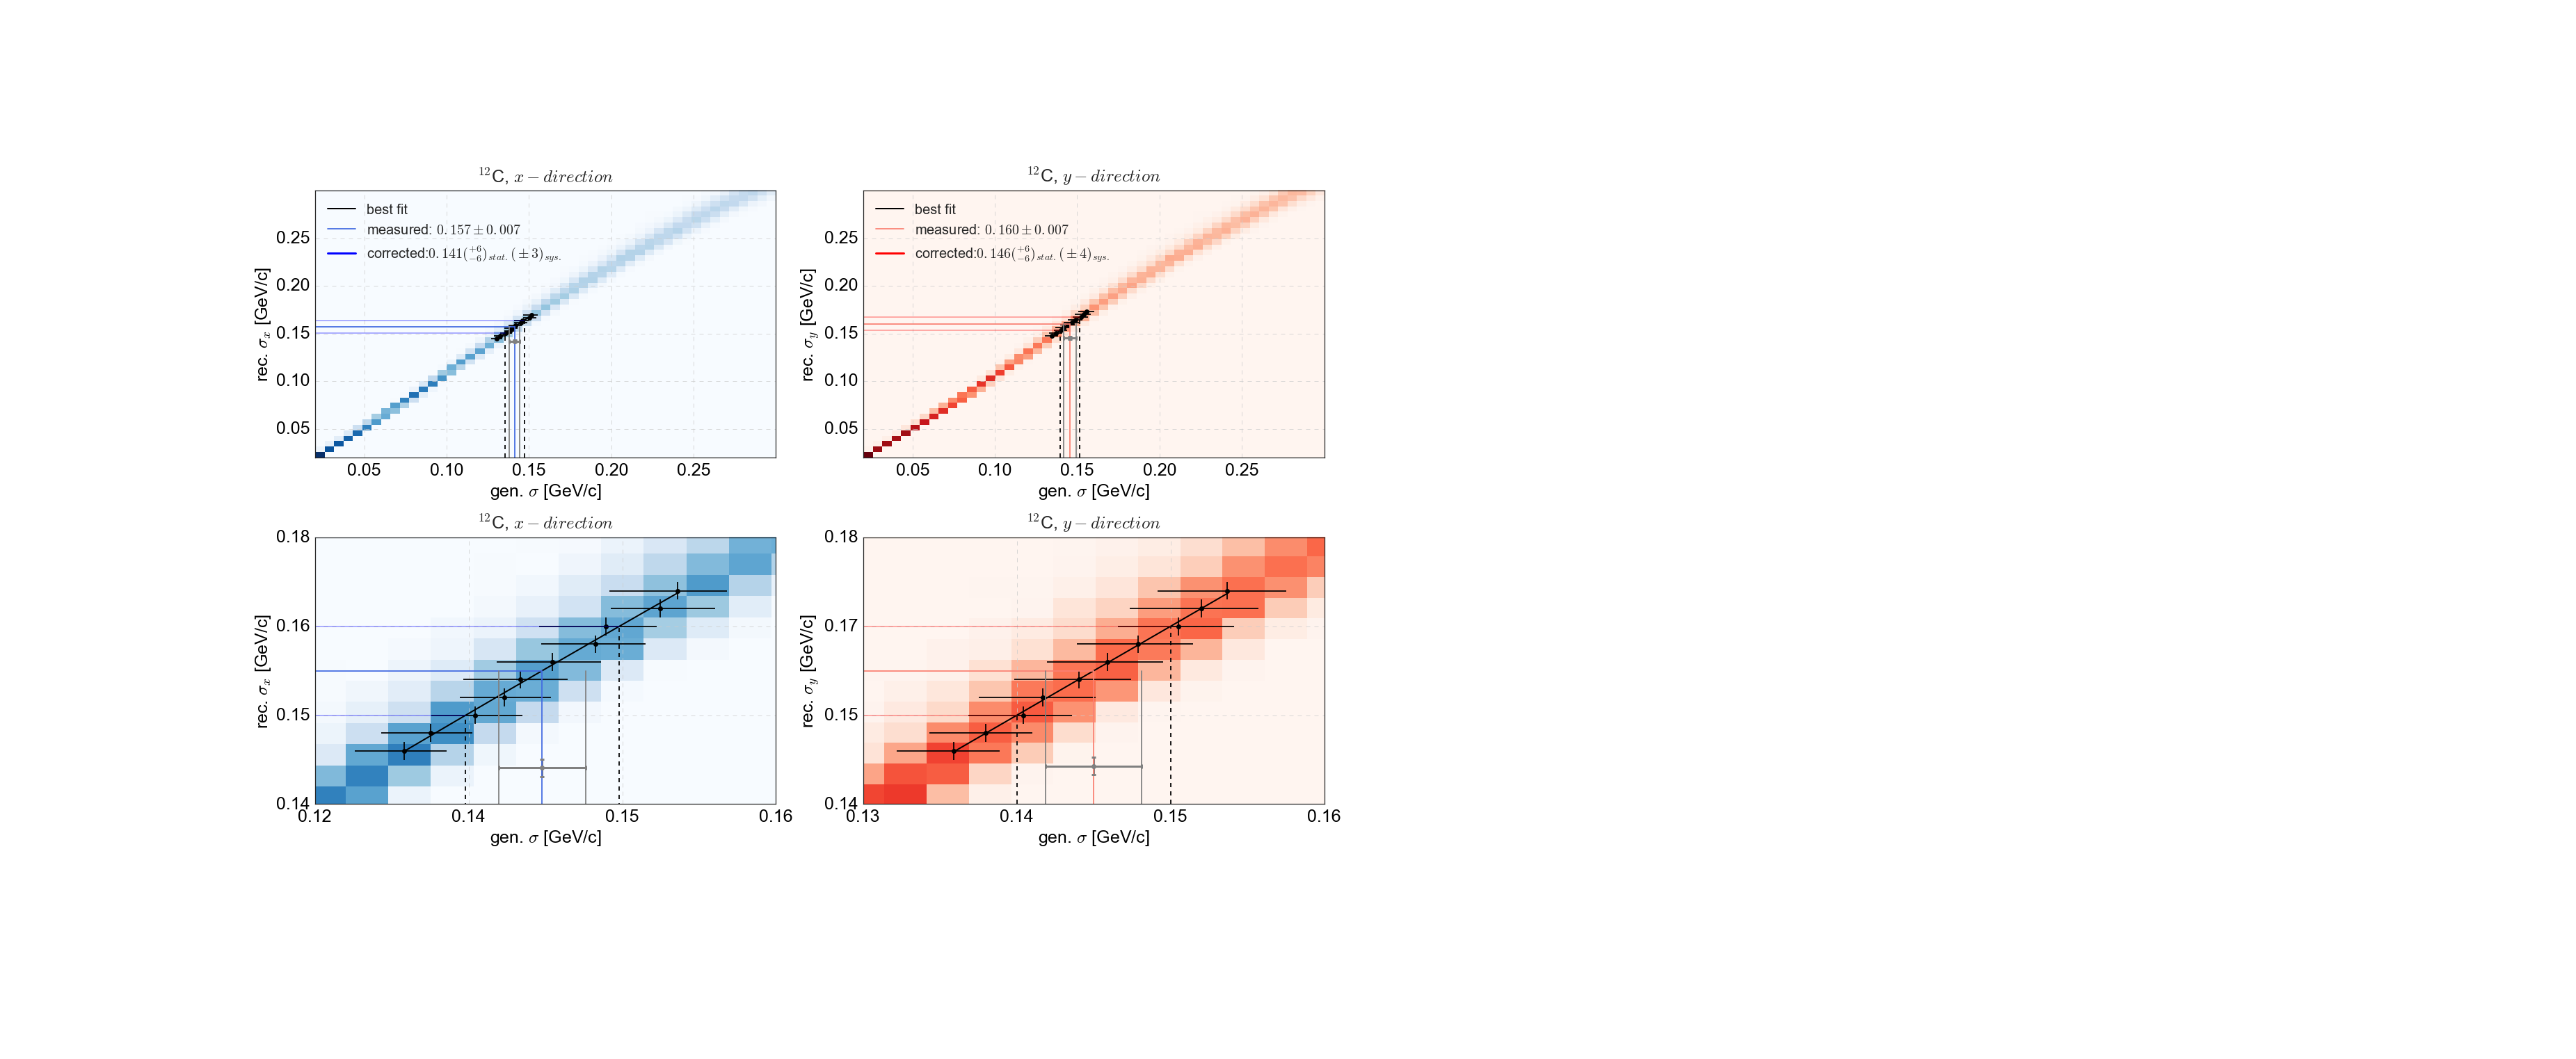

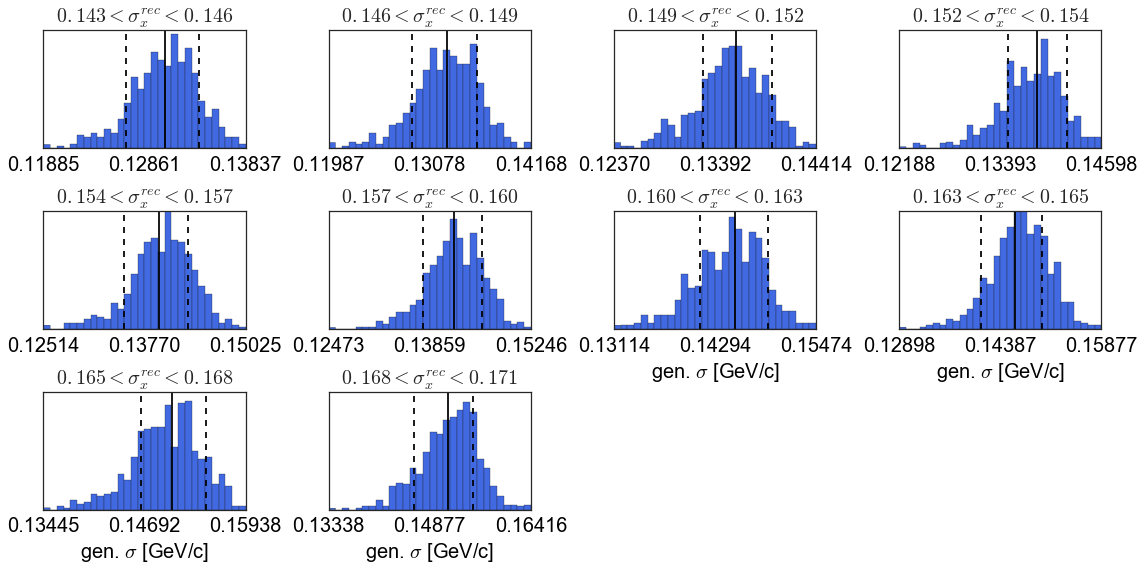

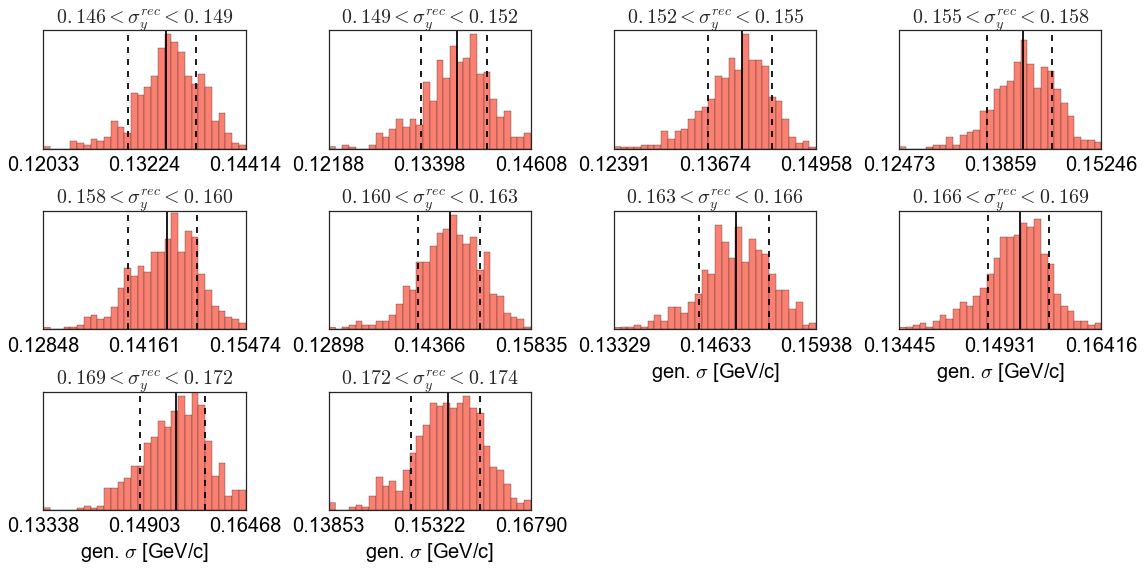

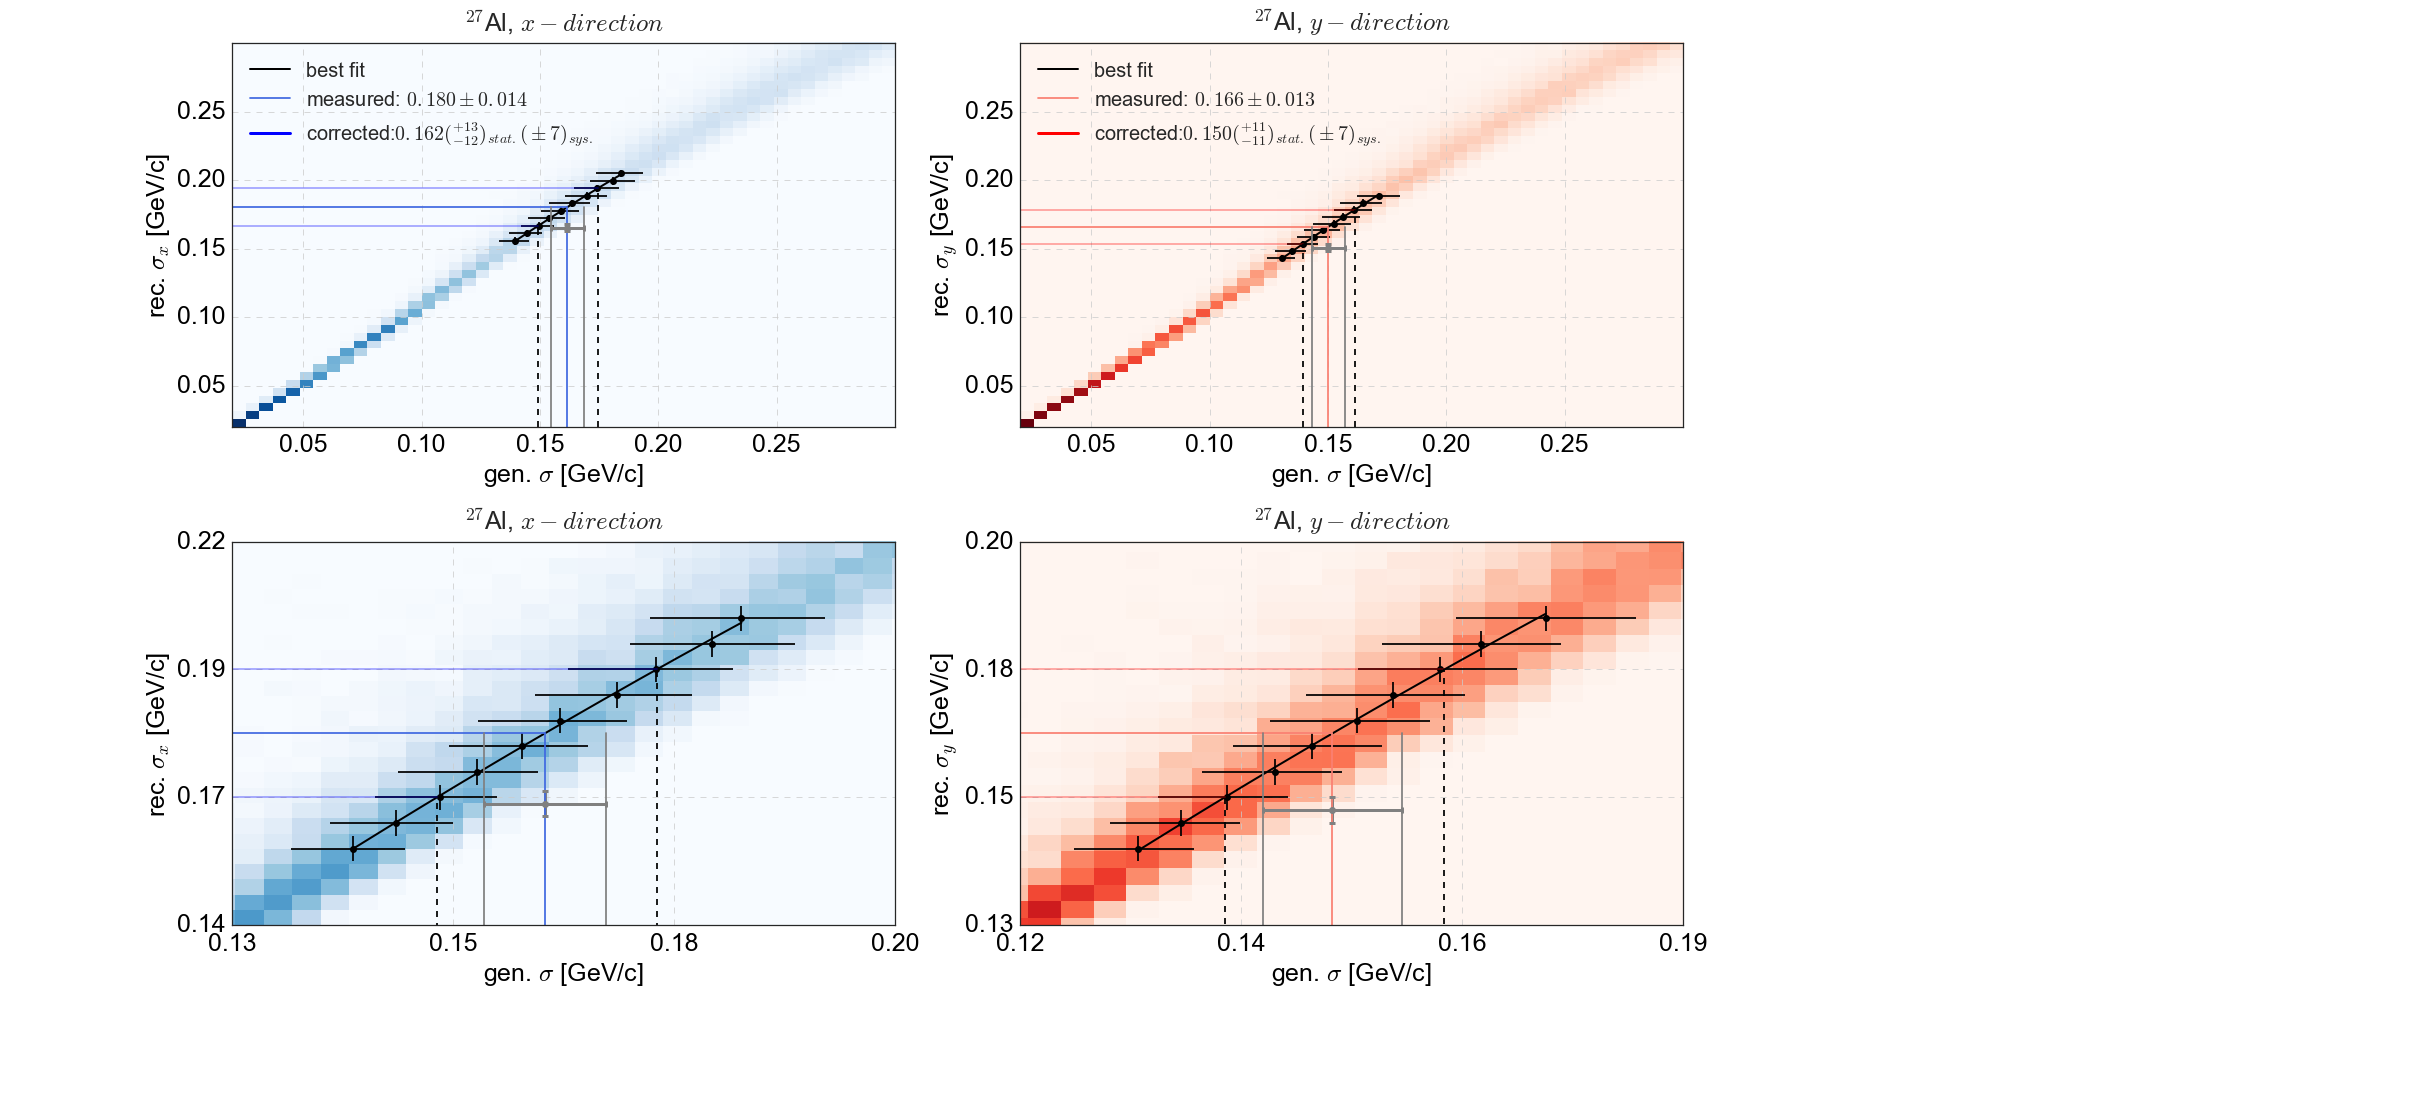

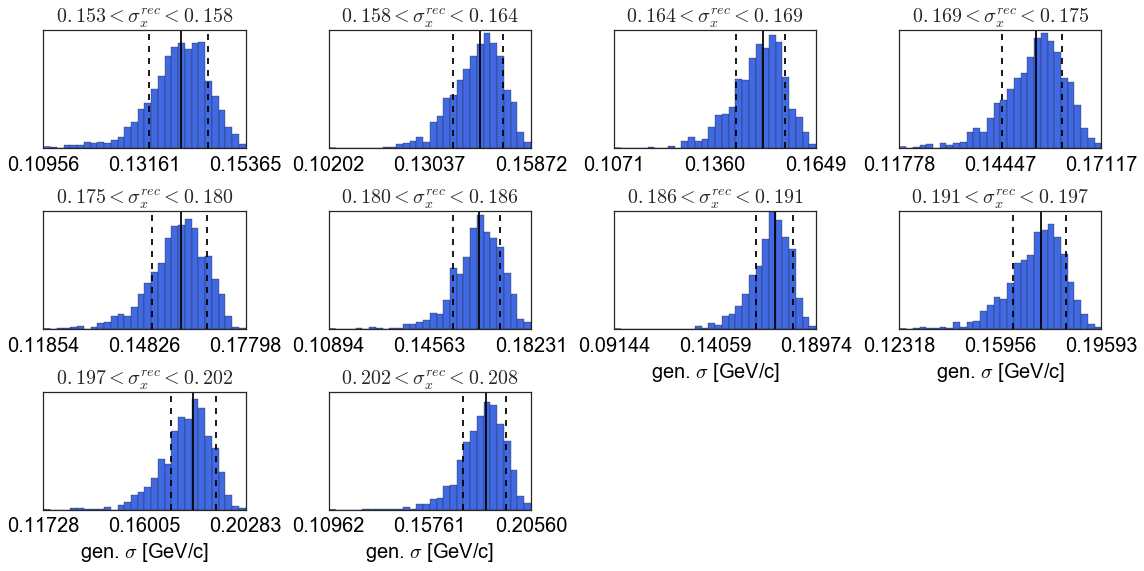

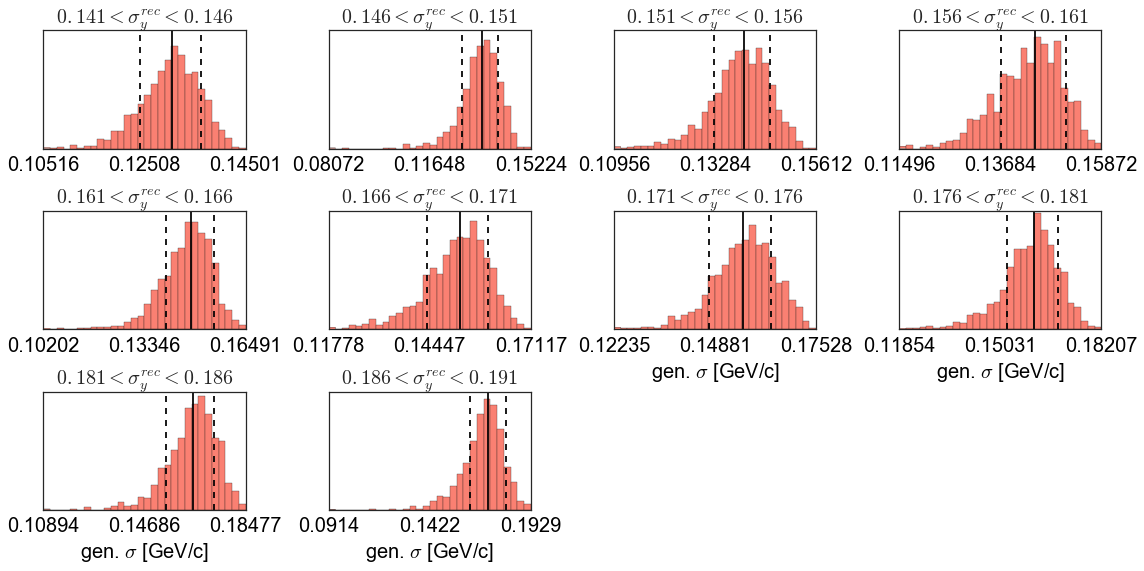

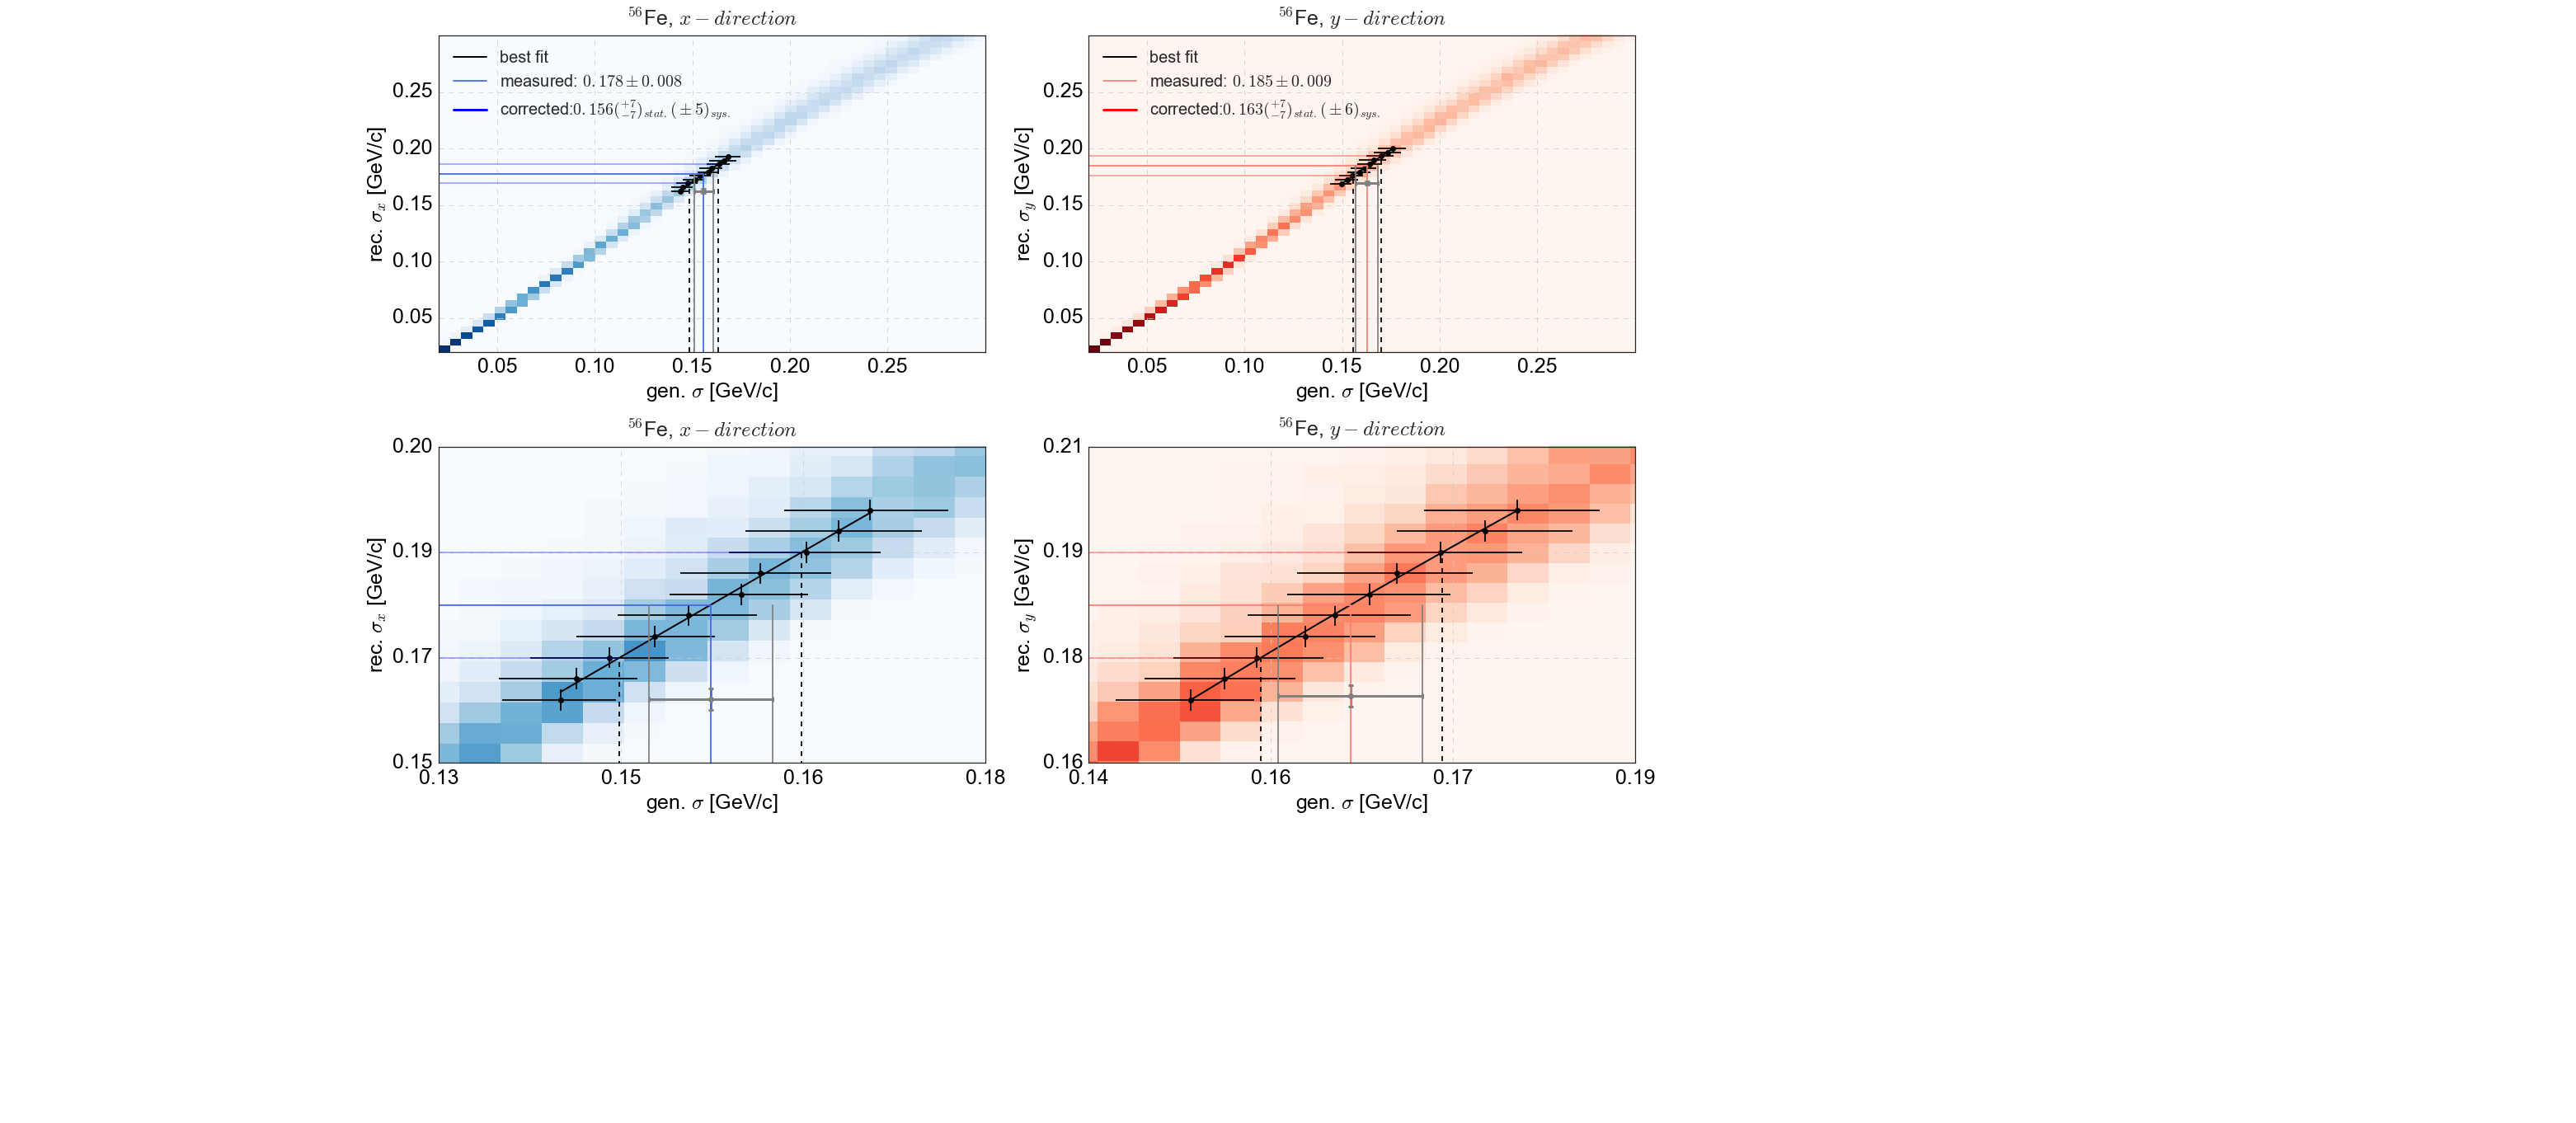

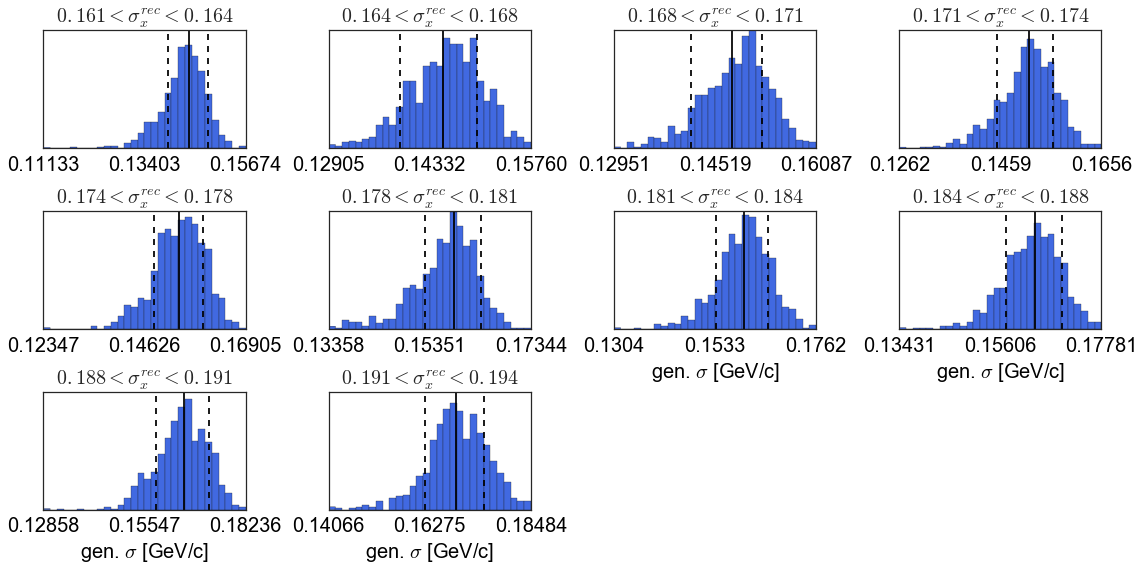

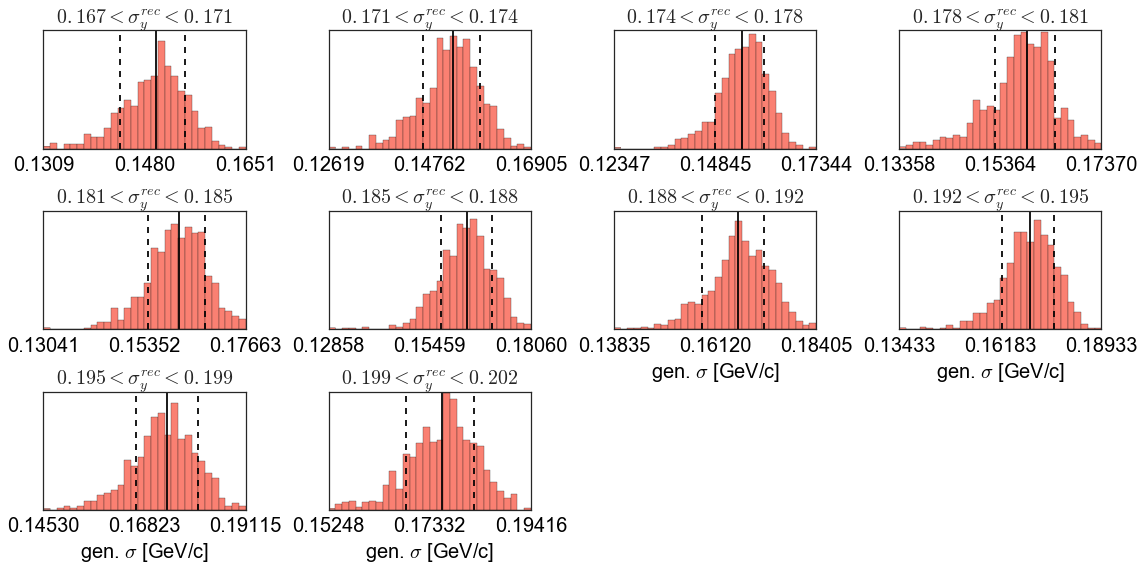

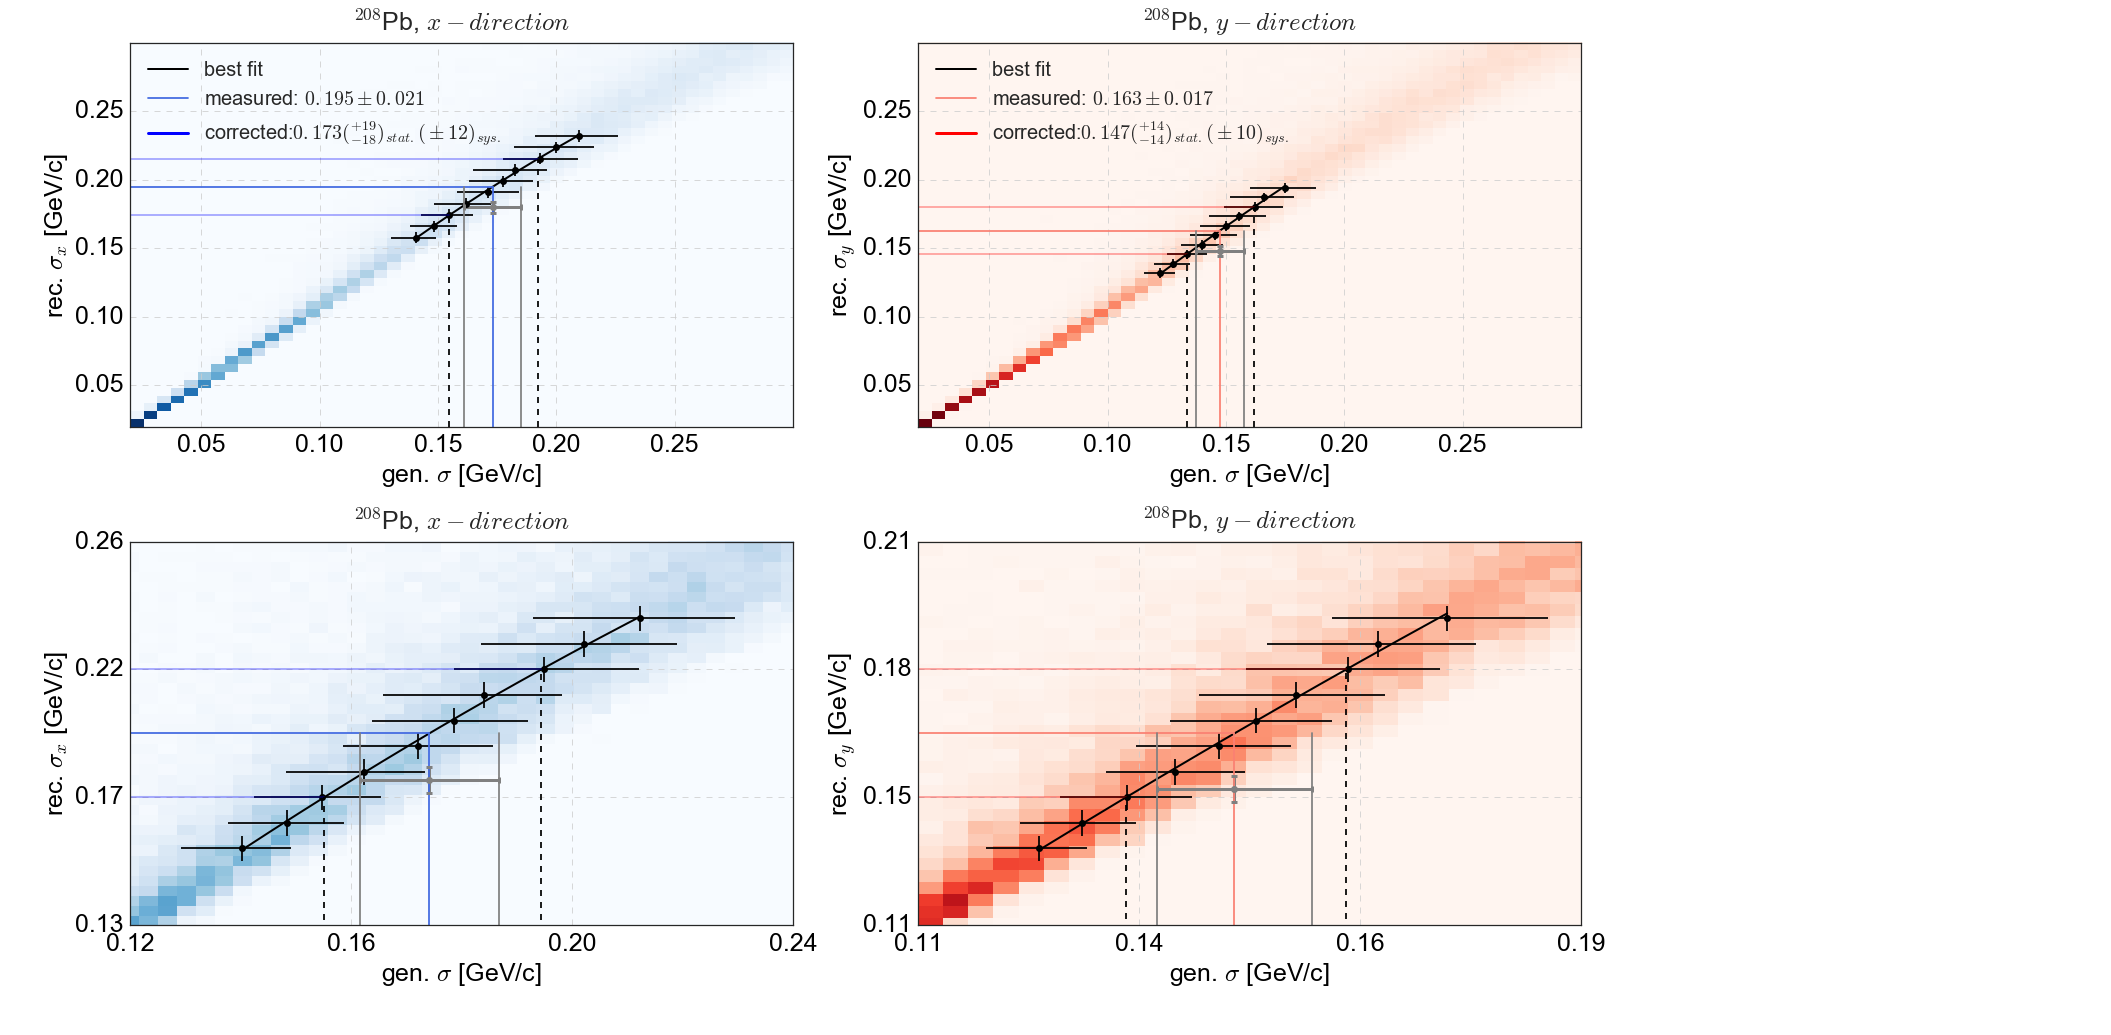

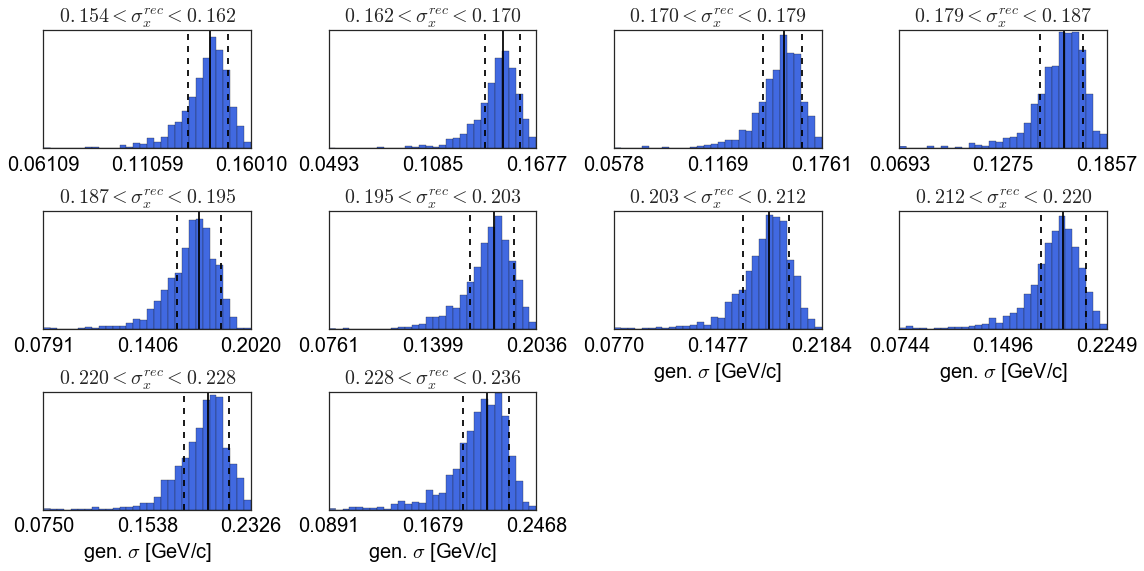

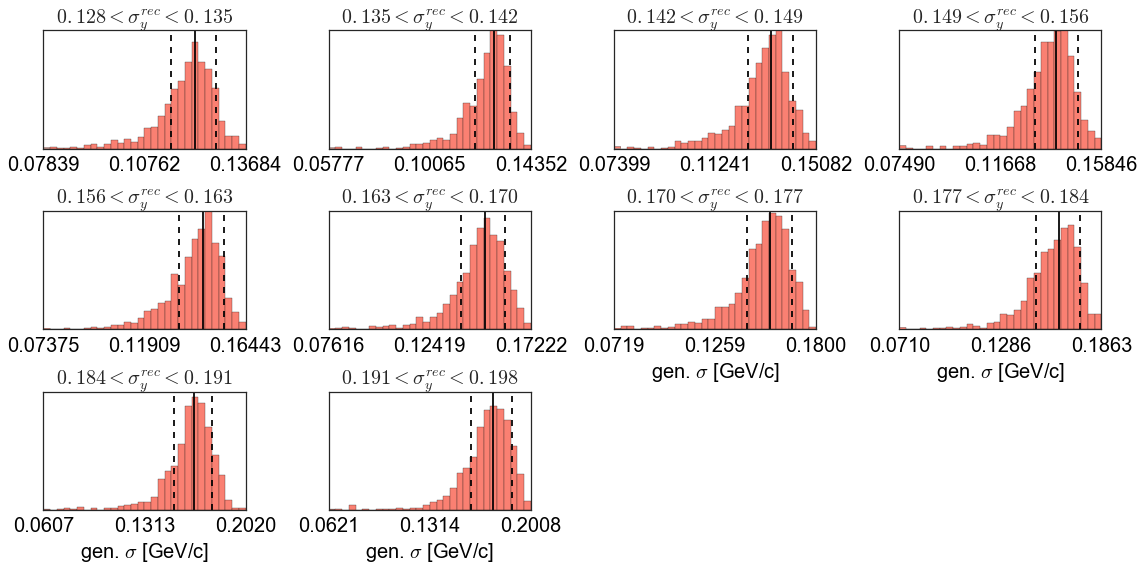

In [17]:
poly_degree = 2 # fit polynomial degree
extraname='confidence68'
for i,(A,target) in enumerate(zip(As[0:],targets[0:])):
    test_name = "simulations_"+Fiducials+"_"+target
    sims=simulation_results[test_name]        
    good_results = sims[
            (sims['gen_SigmaZ']>0)&(sims['rec_sigma_x']>0)&(sims['rec_sigma_y']>0)&(sims['rec_sigma_z']>0)
            &(sims['rec_mean_x']>-0.9)&(sims['rec_mean_y']>-0.9)&(sims['rec_mean_x']>-0.9)]
    fig=plt.figure(figsize=(22,14))
    ax=fig.add_subplot(2,2,1)    
    plot_cm_direction_binned_confidence68(sims=good_results, ax=ax,s=3,extraname=extraname
                                    ,poly_degree=poly_degree
                                    ,A=A,direction='x'
                                    ,colors=['blue','royalblue','Blues'],debug=0,do_add_1Ddist_in_slices=True)
    ax=fig.add_subplot(2,2,3)    
    plot_cm_direction_binned_confidence68(sims=good_results, ax=ax,s=3,extraname=extraname
                                    ,poly_degree=poly_degree
                                    ,A=A,direction='x'
                                    ,colors=['blue','royalblue','Blues'],debug=0
                             ,do_zoom_in=True ,do_add_1Ddist_in_slices=False,do_add_legend=False)

    ax=fig.add_subplot(2,2,2)
    plot_cm_direction_binned_confidence68(sims=good_results, ax=ax,s=3,extraname=extraname
                                    ,poly_degree=poly_degree if A!=12 else 1
                                    ,A=A,direction='y'
                                    ,colors=['red','salmon','Reds'],debug=0,do_add_1Ddist_in_slices=True)
    ax=fig.add_subplot(2,2,4)
    plot_cm_direction_binned_confidence68(sims=good_results, ax=ax,s=3,extraname=extraname
                                    ,poly_degree=poly_degree if A!=12 else 1
                                    ,A=A,direction='y'
                                    ,colors=['red','salmon','Reds'],debug=0
                             ,do_zoom_in=True ,do_add_1Ddist_in_slices=False,do_add_legend=False)

    fig.subplots_adjust(bottom=-0.5,left=-0.2)
    fig.tight_layout() 
    filename = figures_path+'St_gen_rec_'+target+'.png' if extraname=='' else figures_path+'St_gen_rec_'+target+'_'+extraname+'.png'    
    fig.savefig( filename )

In [36]:
sample = cm_parameters_with_correction['PrecFiducials']
extraname='confidence68'

for direction in ['x','y']:
    sample['sigma_'+direction+extraname+'_final'] = sample['sigma_'+direction+'_corrected'+extraname]
    for updw in ['up','dw']:
        sample['sigma_'+direction+extraname+'_final_'+updw+'_err'] = sample['sigma_'+direction+'_corrected_'+updw+'_err_tot'+extraname]

corr_x = sample['sigma_x_corrected'+extraname]
Dcorr_x = sample['sigma_x_corrected_err_tot'+extraname]

corr_y = sample['sigma_y_corrected'+extraname]
Dcorr_y = sample['sigma_y_corrected_err_tot'+extraname]

# weighted average
corr_t = (corr_x/np.square(Dcorr_x)+corr_y/np.square(Dcorr_y))/( 1./np.square(Dcorr_x) + 1./np.square(Dcorr_y))
sample['sigma_t'+extraname+'_final'] = corr_t
    
Dsys_x = sample['sigma_x_corrected_err_sys'+extraname]
Dsys_y = sample['sigma_y_corrected_err_sys'+extraname]
Dsys_t = 0.5*( Dsys_x + Dsys_y )
# Dsys_t = np.sqrt(1./( 1./np.square(Dsys_x) + 1./np.square(Dsys_y) ))
sample['sigma_t'+extraname+'_final_err_sys'] = Dsys_t


for updw in ['up','dw']:            
    Dstat_x = sample['sigma_x_corrected_'+updw+'_err_stat'+extraname]
    Dstat_y = sample['sigma_y_corrected_'+updw+'_err_stat'+extraname]
    #     Dstat_t = 0.5*np.sqrt( np.square(Dstat_x) + np.square(Dstat_y) )
    Dstat_t = np.sqrt(1./( 1./np.square(Dstat_x) + 1./np.square(Dstat_y) ))
    sample['sigma_t'+extraname+'_final_'+updw+'_err_stat'] = Dstat_t

    Dtot_t = np.sqrt( np.square(Dstat_t) + np.square(Dsys_t) )
    sample['sigma_t'+extraname+'_final_'+updw+'_err_tot'] = Dtot_t
    sample['sigma_t'+extraname+'_final_'+updw+'_err'] = Dtot_t

sample['sigma_t'+extraname+'_final_err_sys'] = sample['sigma_t_final_err_sys']

In [37]:
cm_parameters_with_correction['PrecFiducials'][['sigma_t_final'
                                                ,'sigma_t_final_up_err','sigma_t_final_dw_err'
                                                ,'sigma_t'+extraname+'_final'
                                                ,'sigma_t'+extraname+'_final_up_err','sigma_t'+extraname+'_final_dw_err']].astype(float)

sigma_t_final  sigma_t_final_up_err  sigma_t_final_dw_err  \
0       0.143455              0.005478              0.005453   
1       0.155257              0.010765              0.010678   
2       0.159052              0.007448              0.007344   
3       0.155679              0.015949              0.015610   

   sigma_tconfidence68_final  sigma_tconfidence68_final_up_err  \
0                   0.143316                          0.005485   
1                   0.155218                          0.010951   
2                   0.159014                          0.007414   
3                   0.157168                          0.016024   

   sigma_tconfidence68_final_dw_err  
0                          0.005469  
1                          0.010709  
2                          0.007359  
3                          0.015681

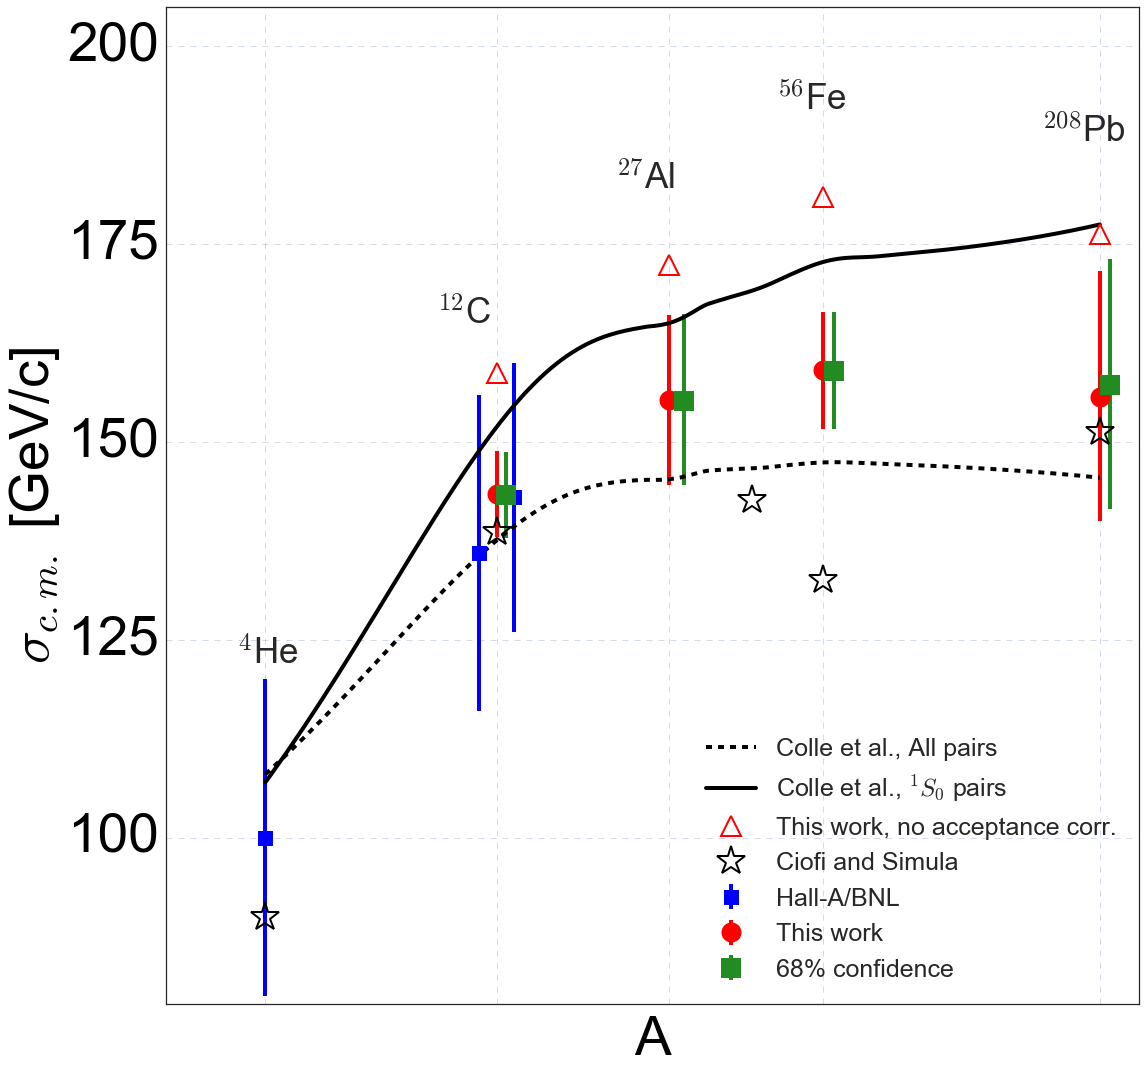

In [54]:
extraname='confidence68'
ax = plot_needed_for_A_depdendence_sigma_t(ylim=(79,205),labels=dict({'$^4$He':(3.5,122),
                                            '$^{12}$C':(9,165), '$^{27}$Al':(21,182),
                                            '$^{56}$Fe':(45,192), '$^{208}$Pb':(158,188), }),do_Ciofi=True)

plot_data_assymetric( data=cm_parameters_with_correction['PrecFiducials'],direction='t',ax=ax, label="This work" , marker='o', markersize=20 )
plot_data_assymetric( data=cm_parameters_with_correction['PrecFiducials'],Ashift=[0.5,2,3,10], direction='t'+extraname,ax=ax, label="68% confidence" , marker='s', markersize=20 , color='forestgreen')
plt.legend(fontsize=20,loc='upper left')
# measured
ax.plot(cm_pars['A'], 1000*cm_pars['sigma_t_before_acc_corr'] ,mec='red' , marker='^' ,mfc='none',lw = 2, mew = 2, ms = 20, linewidth=0, label='This work, no acceptance corr.')

ax.legend(fontsize=25,loc='lower right')
plt.tight_layout()
plt.savefig(figures_path +'results_compare_confidence68.pdf')

# What is the Pvalue for consistency of the points with the "all-pairs" line?

# chi2 comparison of the points to a line:
## $\chi^2_{red} = \frac{1}{N_{points}-1} \sum_i \left(\frac{\left(y_i - f(x_i)\right)^2}{\Delta y_i^2} \right)$
where $f(x_i)$ is the value of the function at point x_i

chi2/ndf: 3.79839645865 /3


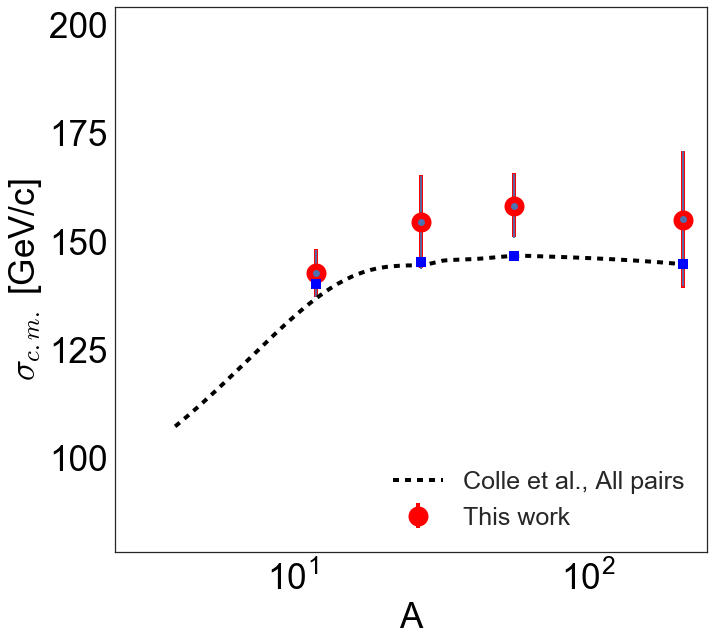

In [18]:
data=cm_parameters_with_correction['PrecFiducials']
fig, ax = plt.subplots(figsize=(10,9))
f_all = plot_calculation_line( kind='slinear',data=ColleCalc, varx='A' , vary='allpairs',color='black' ,label='Colle et al., All pairs')
plot_data_assymetric( data=data,direction='t',ax=ax, label="This work" , marker='o', markersize=20 )
ax.legend(fontsize=25,loc='lower right')
set_axes(ax , 'A' , '$\sigma_{c.m.}$ [GeV/c]' , fontsize=35 
             ,xticks=[4,12,27,56,208],xlim=(2.5,250)
             ,yticks=[100,125,150,175,200], ylim=(79,205)
        )
ax.set_xscale('log')

x = data['A'] 
y = np.array([143.36 , 155.2 , 159.0 , 156.0 ])
yerr = np.array([5.4 , 10.7 , 7.4 , 15.6])
f_00 = np.array([157,166,173.,177.5])
f_all = np.array([141,146,147.5,145.5])
f = f_all
chi2 = np.sum( np.square(y - f) / np.square(yerr) )
chi2red = chi2/3

plt.errorbar(x,y,yerr,fmt='o')
plt.errorbar(x,f,fmt='s',color='blue',markersize=10)

plt.tight_layout()
print 'chi2/ndf:',chi2,'/3'

# Can we apply a cut on $p_{val}$ of KS-test or $\chi^2$-test to reject unreasonable solutions?

In [19]:
for Fiducials in ["PrecFiducials"]:
    for A,target in zip(As,targets):#{
            test_name = "chi2red_"+target
            simulation_results[test_name] = pd.concat([
                    pd.read_csv("/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/simulation_300Pmiss600/"+test_name+".csv")
                    ])
            simulation_results[test_name].fillna(-1,inplace=True)
            print len(simulation_results[test_name]),'events in ',test_name            

19200 events in  chi2red_C
18938 events in  chi2red_Al
18900 events in  chi2red_Fe
13097 events in  chi2red_Pb


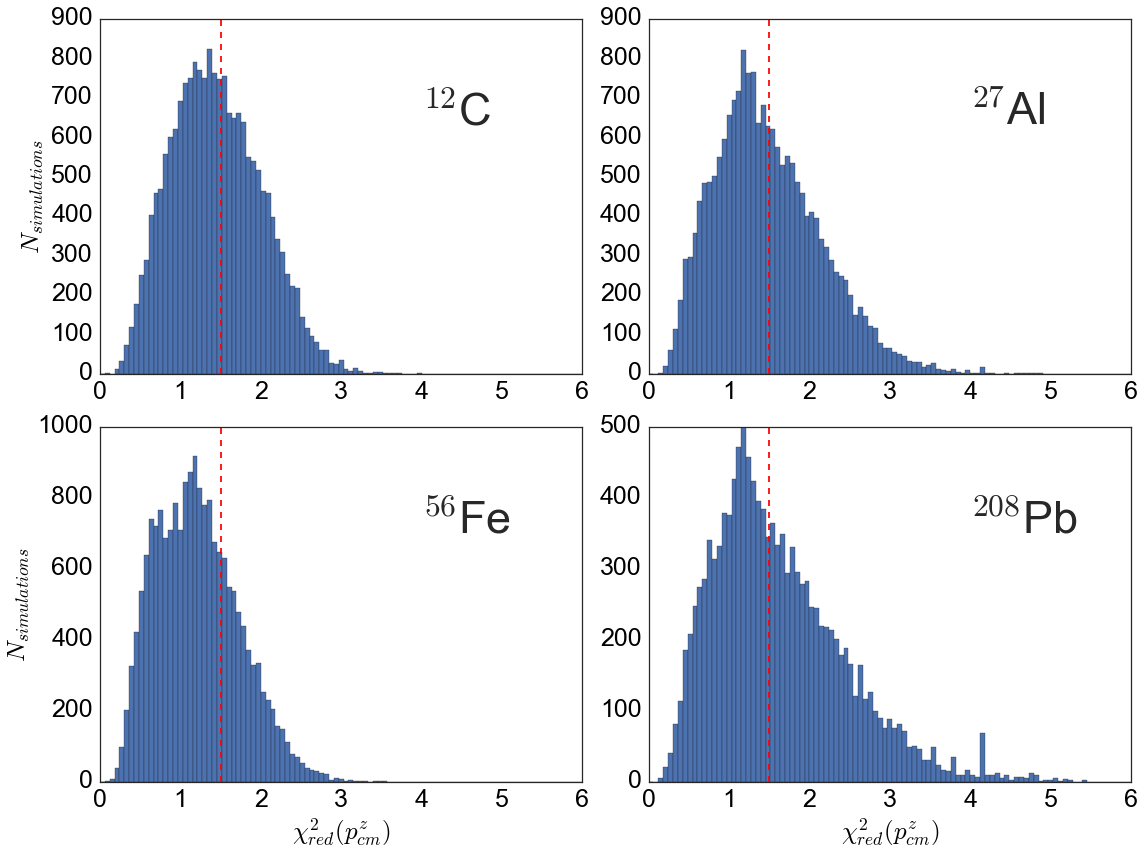

In [20]:
cut_chi2_z = 1.5
fig=plt.figure(figsize=(16,12))
for i,(A,target,target_name) in enumerate(zip(As[0:],targets[0:],target_names[0:])):
    test_name = "chi2red_"+target
    sims=simulation_results[test_name]        
    good_results = sims[
            (sims['gen_SigmaZ']>0)&(sims['rec_sigma_x']>0)&(sims['rec_sigma_y']>0)&(sims['rec_sigma_z']>0)
            &(sims['rec_mean_x']>-0.9)&(sims['rec_mean_y']>-0.9)&(sims['rec_mean_x']>-0.9)]
    ax=fig.add_subplot(2,2,i+1)    
    plt.hist(good_results['chi2red_data_sim_z'],bins=np.linspace(0,6,100))
    set_axes(ax
             ,x_label=r'$\chi^2_{red}(p_{cm}^{z})$' if i>1 else ''
             ,y_label=r'$N_{simulations}$' if i==0 or i==2 else ''
            )
    plt.plot([cut_chi2_z,cut_chi2_z],ax.get_ylim(),'--',color='red')
    plt.text(4,0.7*np.max(ax.get_ylim()),target_name,fontsize=45)
plt.tight_layout()
plt.savefig(figures_path+'chi2red_data_sim_z'+'.pdf')

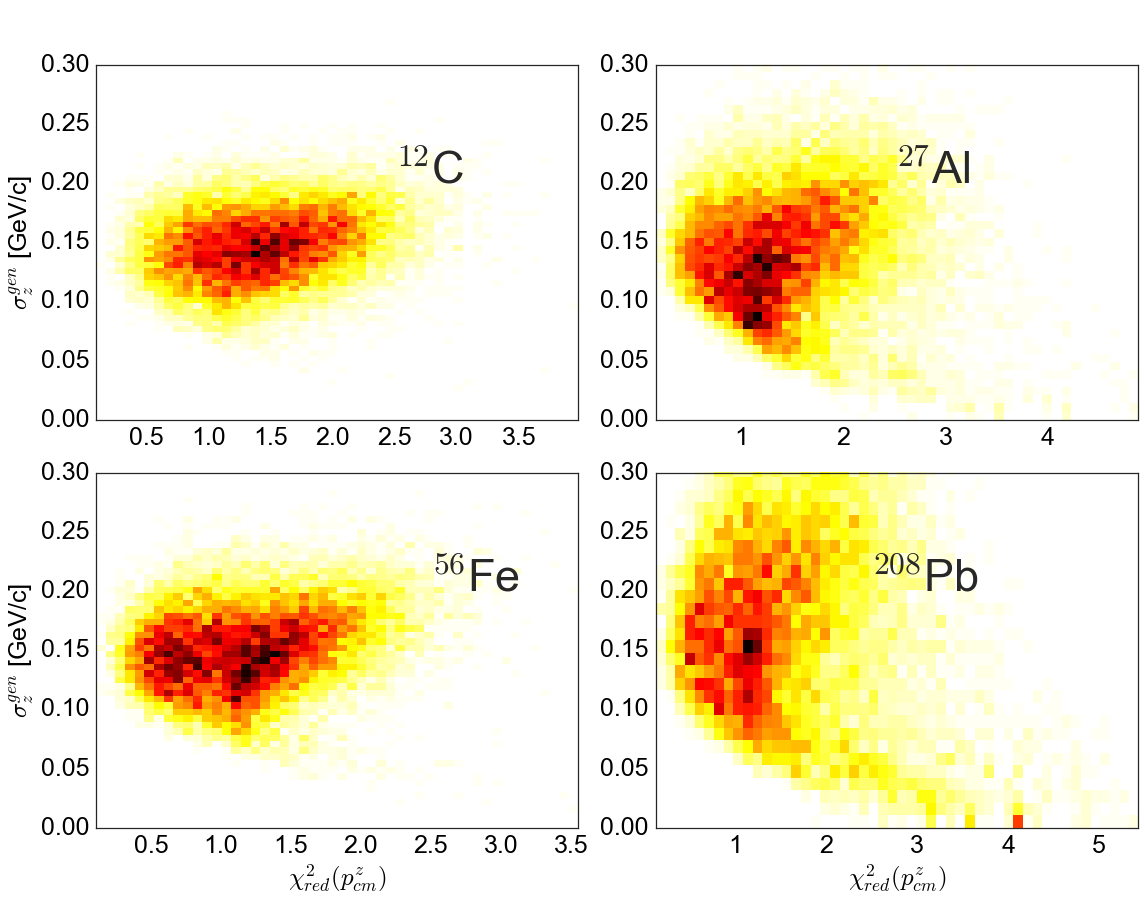

In [21]:
fig=plt.figure(figsize=(16,12))
for i,(A,target,target_name) in enumerate(zip(As[0:],targets[0:],target_names[0:])):
    test_name = "chi2red_"+target
    sims=simulation_results[test_name]        
    good_results = sims[
            (sims['gen_SigmaZ']>0)&(sims['rec_sigma_x']>0)&(sims['rec_sigma_y']>0)&(sims['rec_sigma_z']>0)
            &(sims['rec_mean_x']>-0.9)&(sims['rec_mean_y']>-0.9)&(sims['rec_mean_x']>-0.9)]
    ax=fig.add_subplot(2,2,i+1)    
#     plt.scatter(good_results['chi2red_data_sim_x'],good_results['gen_Sigma_t'])
    plot_2d_hist(good_results['chi2red_data_sim_z'],good_results['gen_SigmaZ'],bins=50,ax=ax)

    set_axes(ax
             ,x_label=r'$\chi^2_{red}(p_{cm}^{z})$' if i>1 else ''
             ,y_label=r'$\sigma_{z}^{gen}$ [GeV/c]' if i==0 or i==2 else '',ylim=(0,0.3)
            )
    plt.text(2.5,0.2,target_name,fontsize=45)
plt.tight_layout()
plt.savefig(figures_path+'chi2red_data_sim_z_vs_gen_SigmaZ'+'.pdf')

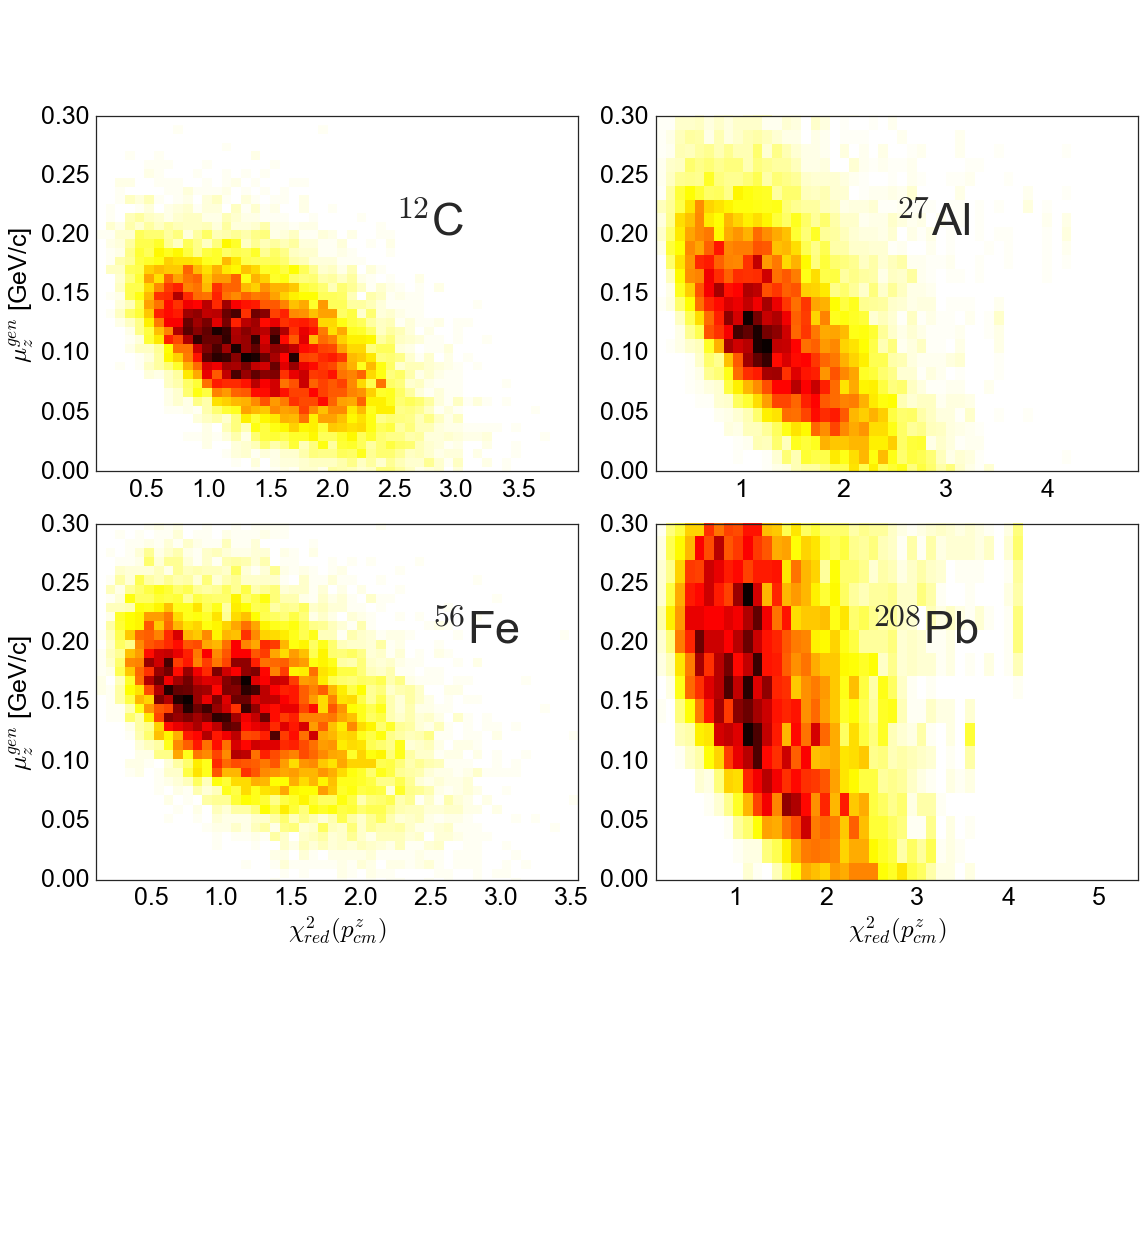

In [22]:
fig=plt.figure(figsize=(16,12))
for i,(A,target,target_name) in enumerate(zip(As[0:],targets[0:],target_names[0:])):
    test_name = "chi2red_"+target
    sims=simulation_results[test_name]        
    good_results = sims[
            (sims['gen_SigmaZ']>0)&(sims['rec_sigma_x']>0)&(sims['rec_sigma_y']>0)&(sims['rec_sigma_z']>0)
            &(sims['rec_mean_x']>-0.9)&(sims['rec_mean_y']>-0.9)&(sims['rec_mean_x']>-0.9)]
    ax=fig.add_subplot(2,2,i+1)    
#     plt.scatter(good_results['chi2red_data_sim_x'],good_results['gen_Sigma_t'])
    plot_2d_hist(good_results['chi2red_data_sim_z'],good_results['gen_MeanZ'],bins=50,ax=ax)

    set_axes(ax
             ,x_label=r'$\chi^2_{red}(p_{cm}^{z})$' if i>1 else ''
             ,y_label=r'$\mu_{z}^{gen}$ [GeV/c]' if i==0 or i==2 else '',ylim=(0,0.3)
            )
    plt.text(2.5,0.2,target_name,fontsize=45)
plt.tight_layout()
plt.savefig(figures_path+'chi2red_data_sim_z_vs_gen_MeanZ'+'.pdf')

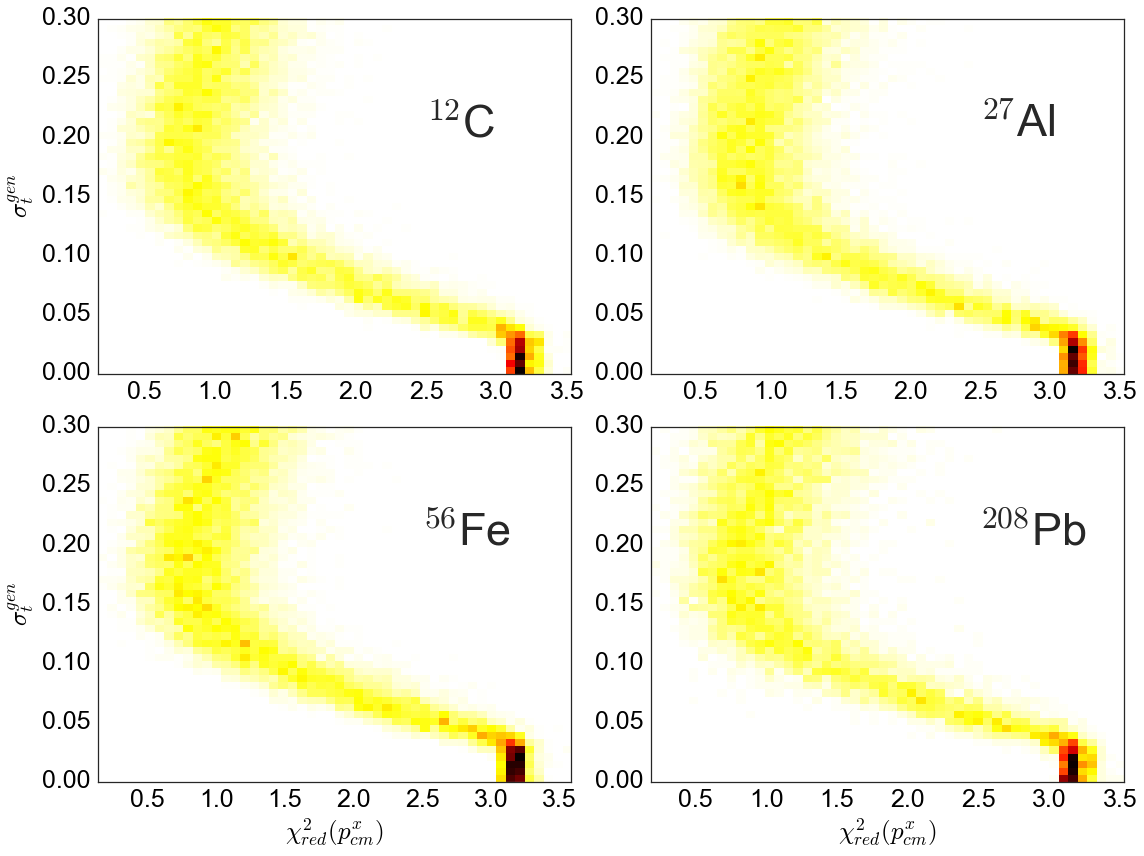

In [23]:
cut_chi2_x = 1.5
# fig=plt.figure(figsize=(16,12))
# for i,(A,target,target_name) in enumerate(zip(As[0:],targets[0:],target_names[0:])):
#     test_name = "chi2red_"+target
#     sims=simulation_results[test_name]        
#     good_results = sims[
#             (sims['gen_SigmaZ']>0)&(sims['rec_sigma_x']>0)&(sims['rec_sigma_y']>0)&(sims['rec_sigma_z']>0)
#             &(sims['rec_mean_x']>-0.9)&(sims['rec_mean_y']>-0.9)&(sims['rec_mean_x']>-0.9)]
#     ax=fig.add_subplot(2,2,i+1)    
#     plt.hist(good_results['chi2red_data_sim_x'],bins=np.linspace(0,6,100))
#     set_axes(ax
#              ,x_label=r'$\chi^2_{red}(p_{cm}^{x})$' if i>1 else ''
#              ,y_label=r'$N_{simulations}$' if i==0 or i==2 else ''
#             )
#     plt.plot([cut_chi2_z,cut_chi2_z],ax.get_ylim(),'--',color='red')
#     plt.text(4,0.7*np.max(ax.get_ylim()),target_name,fontsize=45)
# plt.tight_layout()
# plt.savefig(figures_path+'chi2red_data_sim_x'+'.pdf')


fig=plt.figure(figsize=(16,12))
for i,(A,target,target_name) in enumerate(zip(As[0:],targets[0:],target_names[0:])):
    test_name = "chi2red_"+target
    sims=simulation_results[test_name]        
    good_results = sims[
            (sims['gen_SigmaZ']>0)&(sims['rec_sigma_x']>0)&(sims['rec_sigma_y']>0)&(sims['rec_sigma_z']>0)
            &(sims['rec_mean_x']>-0.9)&(sims['rec_mean_y']>-0.9)&(sims['rec_mean_x']>-0.9)]
    ax=fig.add_subplot(2,2,i+1)    
#     plt.scatter(good_results['chi2red_data_sim_x'],good_results['gen_Sigma_t'])
    plot_2d_hist(good_results['chi2red_data_sim_x'],good_results['gen_Sigma_t'],bins=50,ax=ax)

    set_axes(ax
             ,x_label=r'$\chi^2_{red}(p_{cm}^{x})$' if i>1 else ''
             ,y_label=r'$\sigma_{t}^{gen}$' if i==0 or i==2 else '',ylim=(0,0.3)
            )
    plt.text(2.5,0.2,target_name,fontsize=45)
plt.tight_layout()
plt.savefig(figures_path+'chi2red_data_sim_x_vs_gen_Sigma_t'+'.pdf')

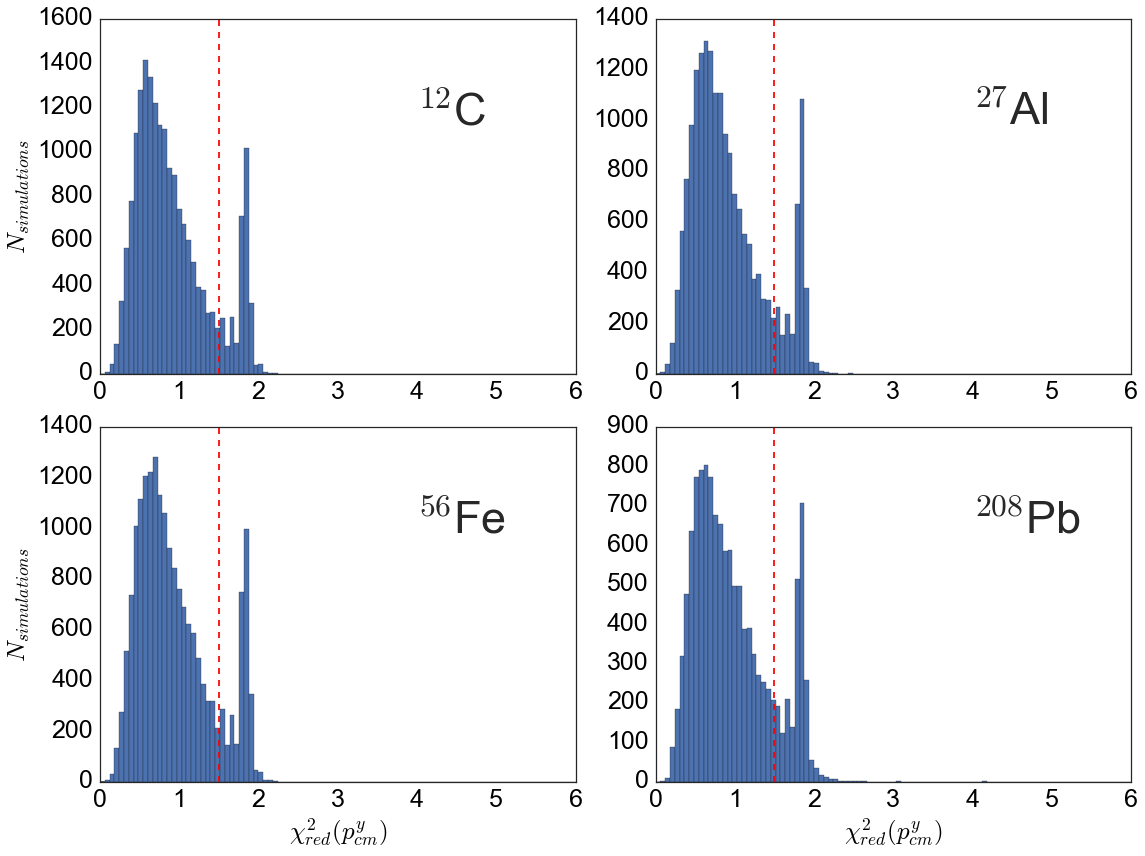

In [24]:

cut_chi2_y = 1.5
fig=plt.figure(figsize=(16,12))
for i,(A,target,target_name) in enumerate(zip(As[0:],targets[0:],target_names[0:])):
    test_name = "chi2red_"+target
    sims=simulation_results[test_name]        
    good_results = sims[
            (sims['gen_SigmaZ']>0)&(sims['rec_sigma_x']>0)&(sims['rec_sigma_y']>0)&(sims['rec_sigma_z']>0)
            &(sims['rec_mean_x']>-0.9)&(sims['rec_mean_y']>-0.9)&(sims['rec_mean_x']>-0.9)]
    ax=fig.add_subplot(2,2,i+1)    
    plt.hist(good_results['chi2red_data_sim_y'],bins=np.linspace(0,6,100))
    set_axes(ax
             ,x_label=r'$\chi^2_{red}(p_{cm}^{y})$' if i>1 else ''
             ,y_label=r'$N_{simulations}$' if i==0 or i==2 else ''
            )
    plt.plot([cut_chi2_z,cut_chi2_z],ax.get_ylim(),'--',color='red')
    plt.text(4,0.7*np.max(ax.get_ylim()),target_name,fontsize=45)
plt.tight_layout()
plt.savefig(figures_path+'chi2red_data_sim_y'+'.pdf')

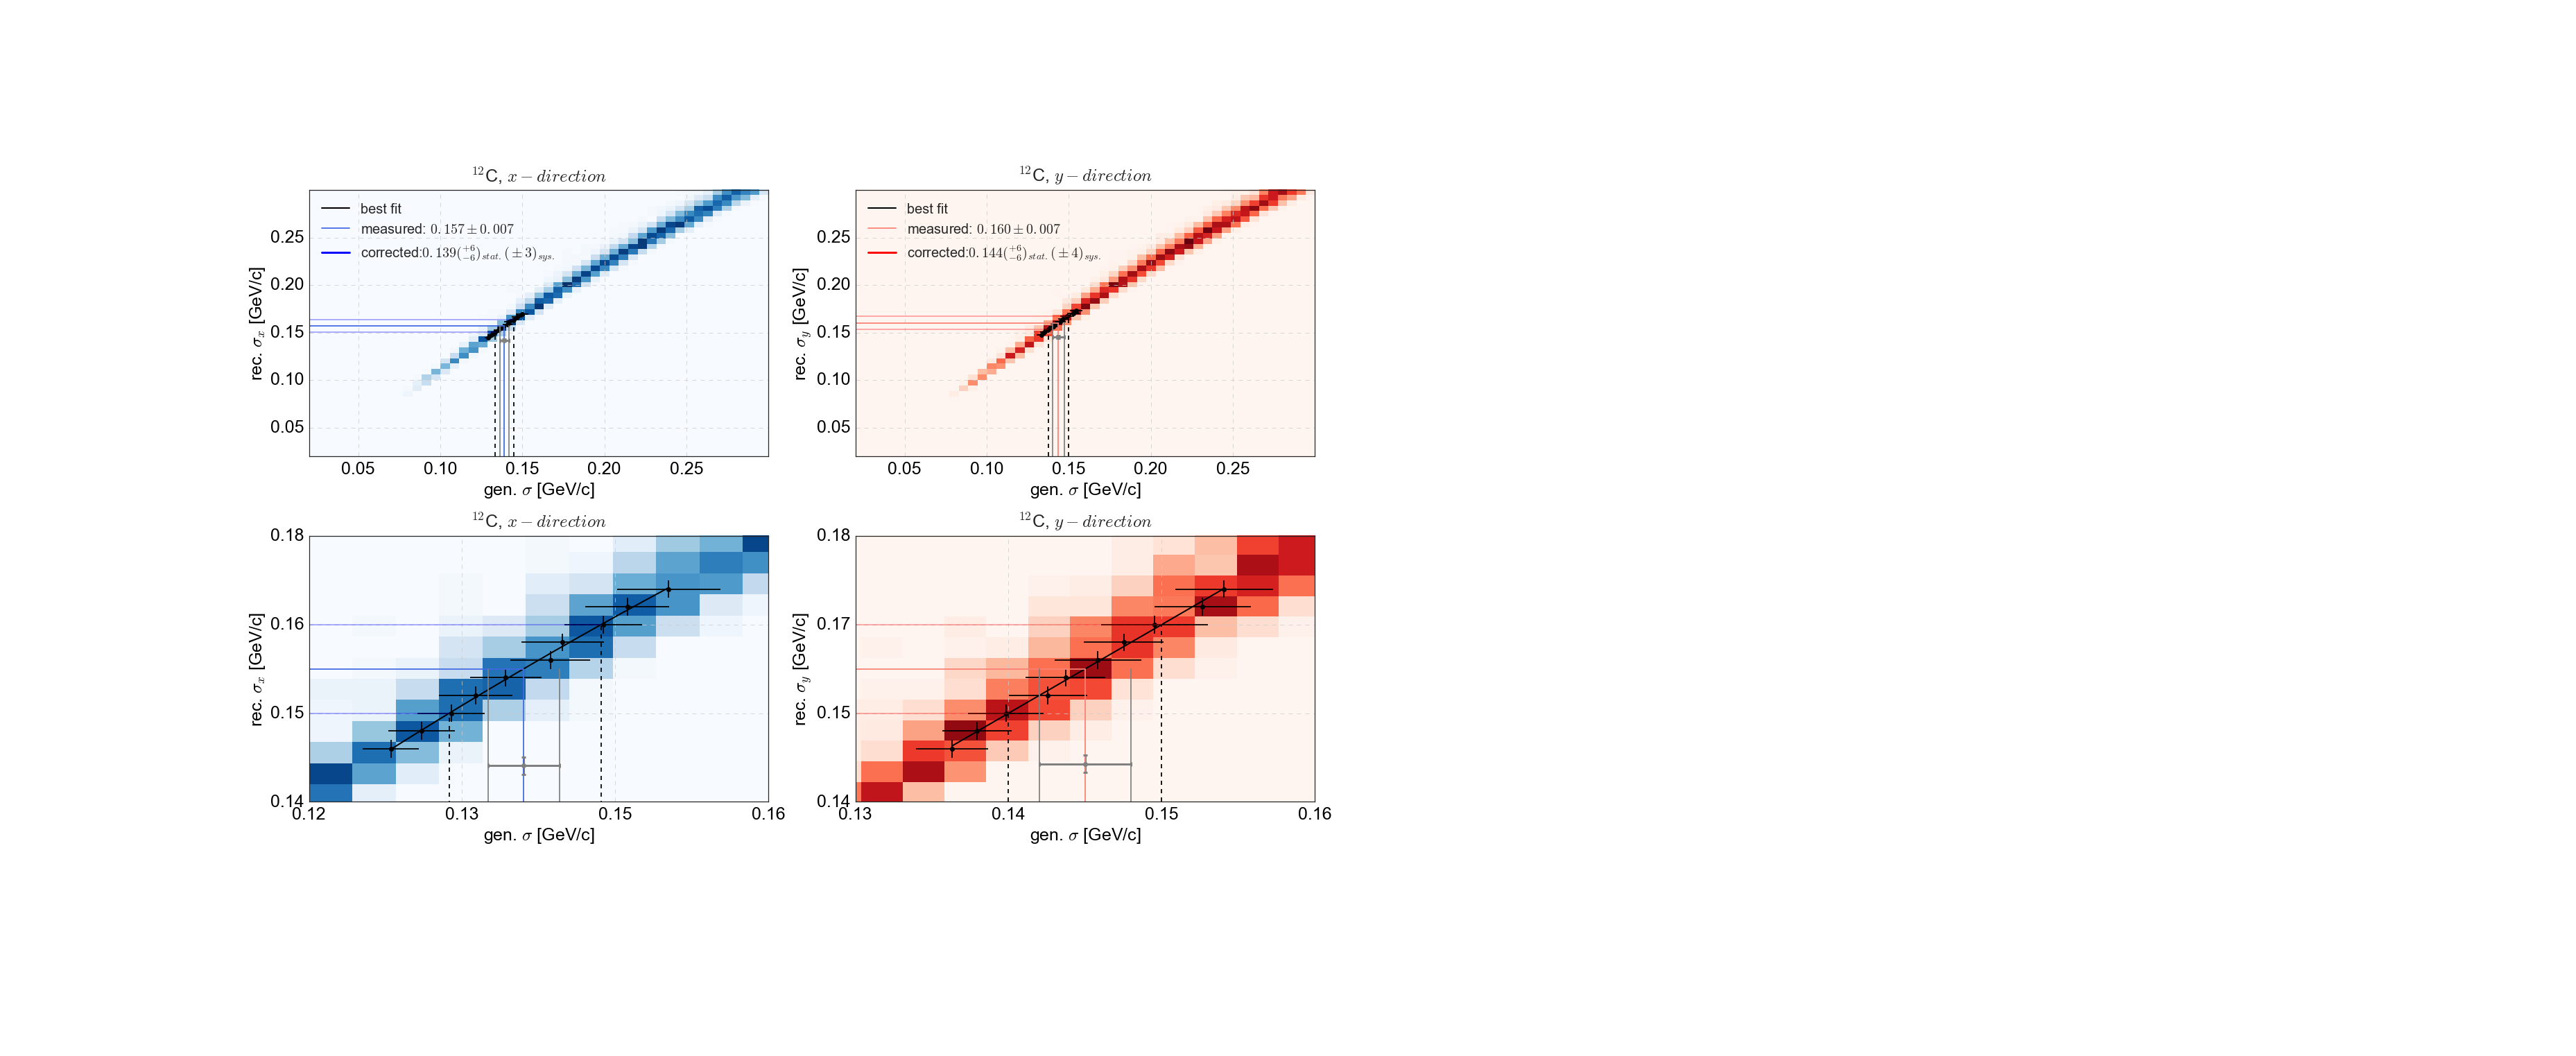

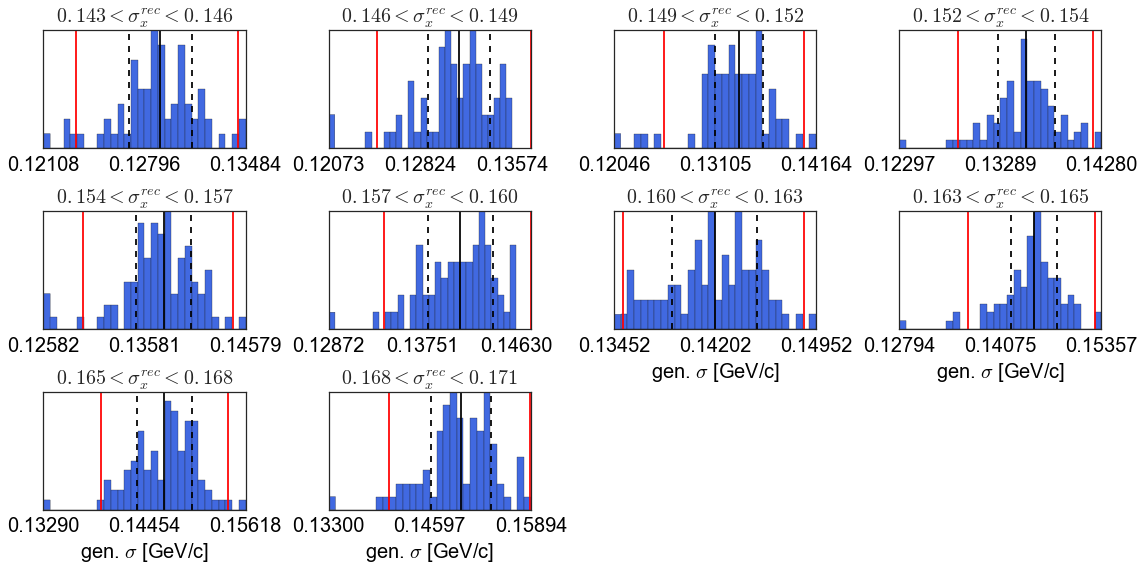

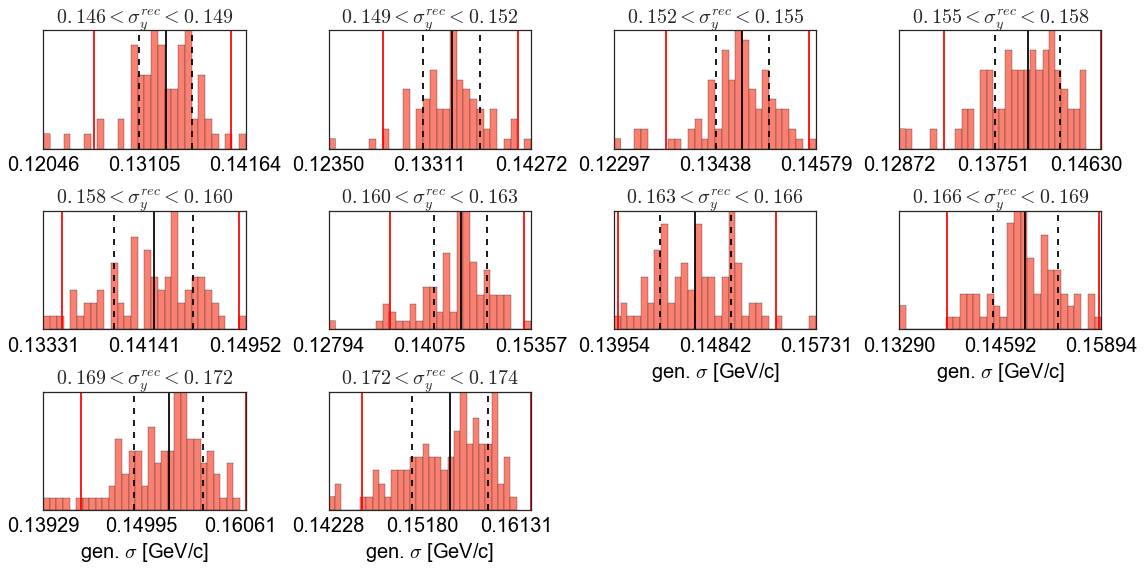

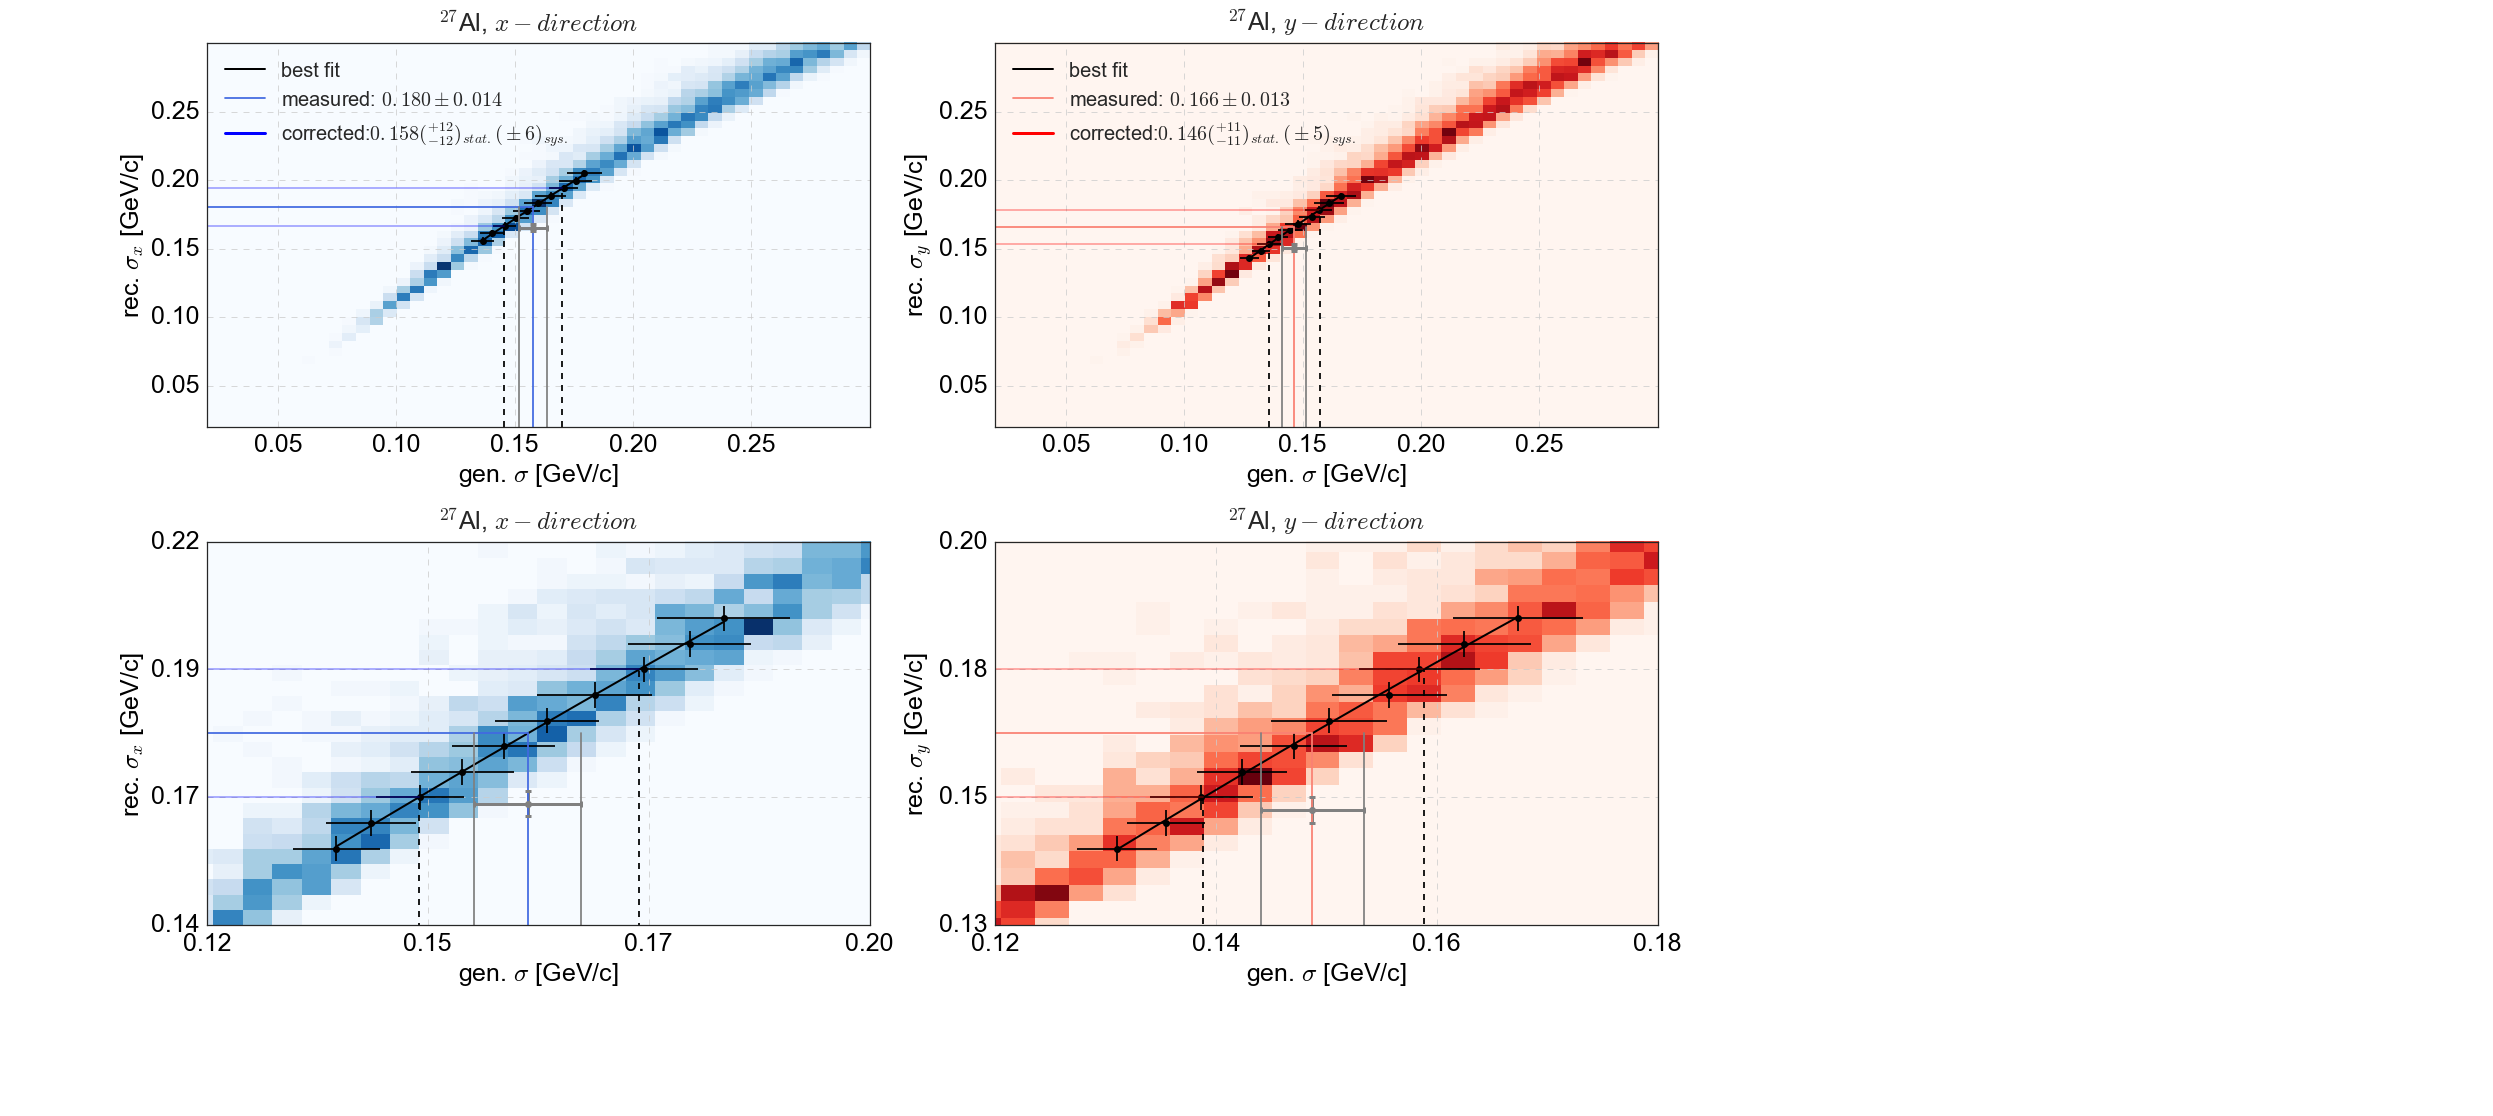

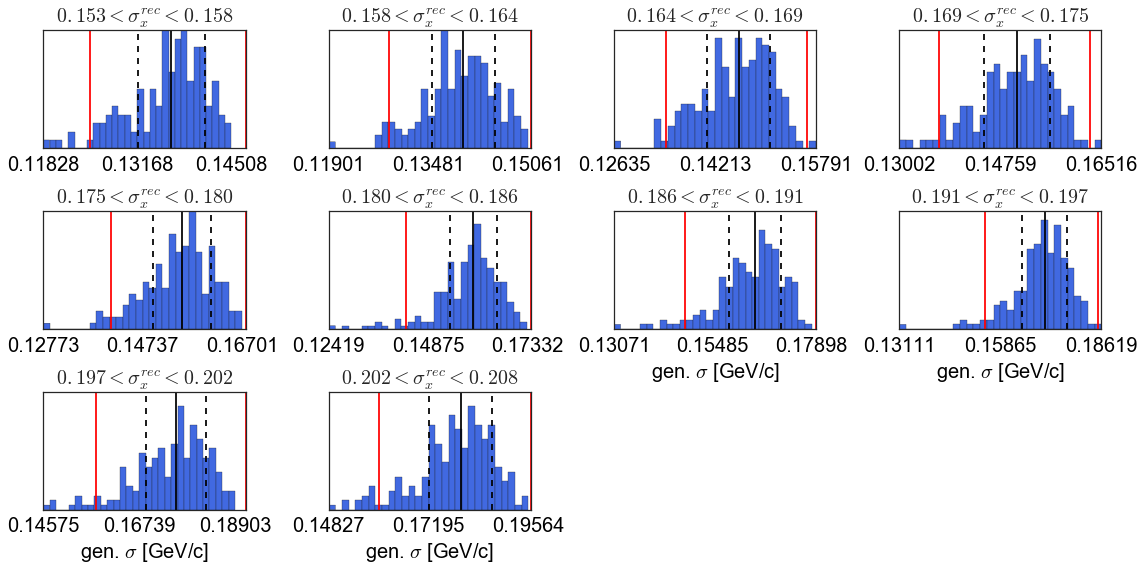

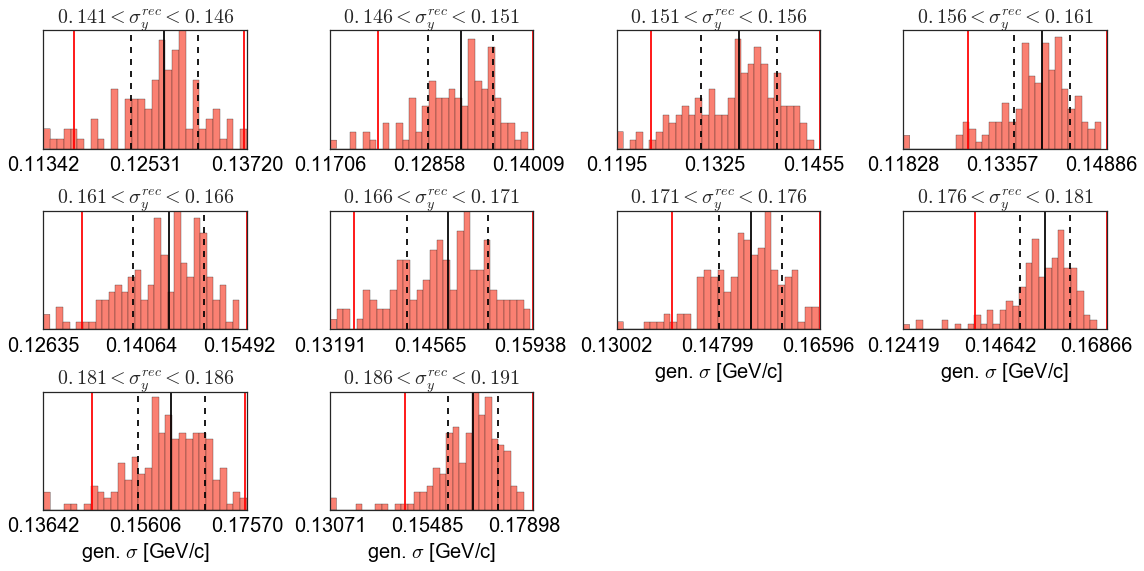

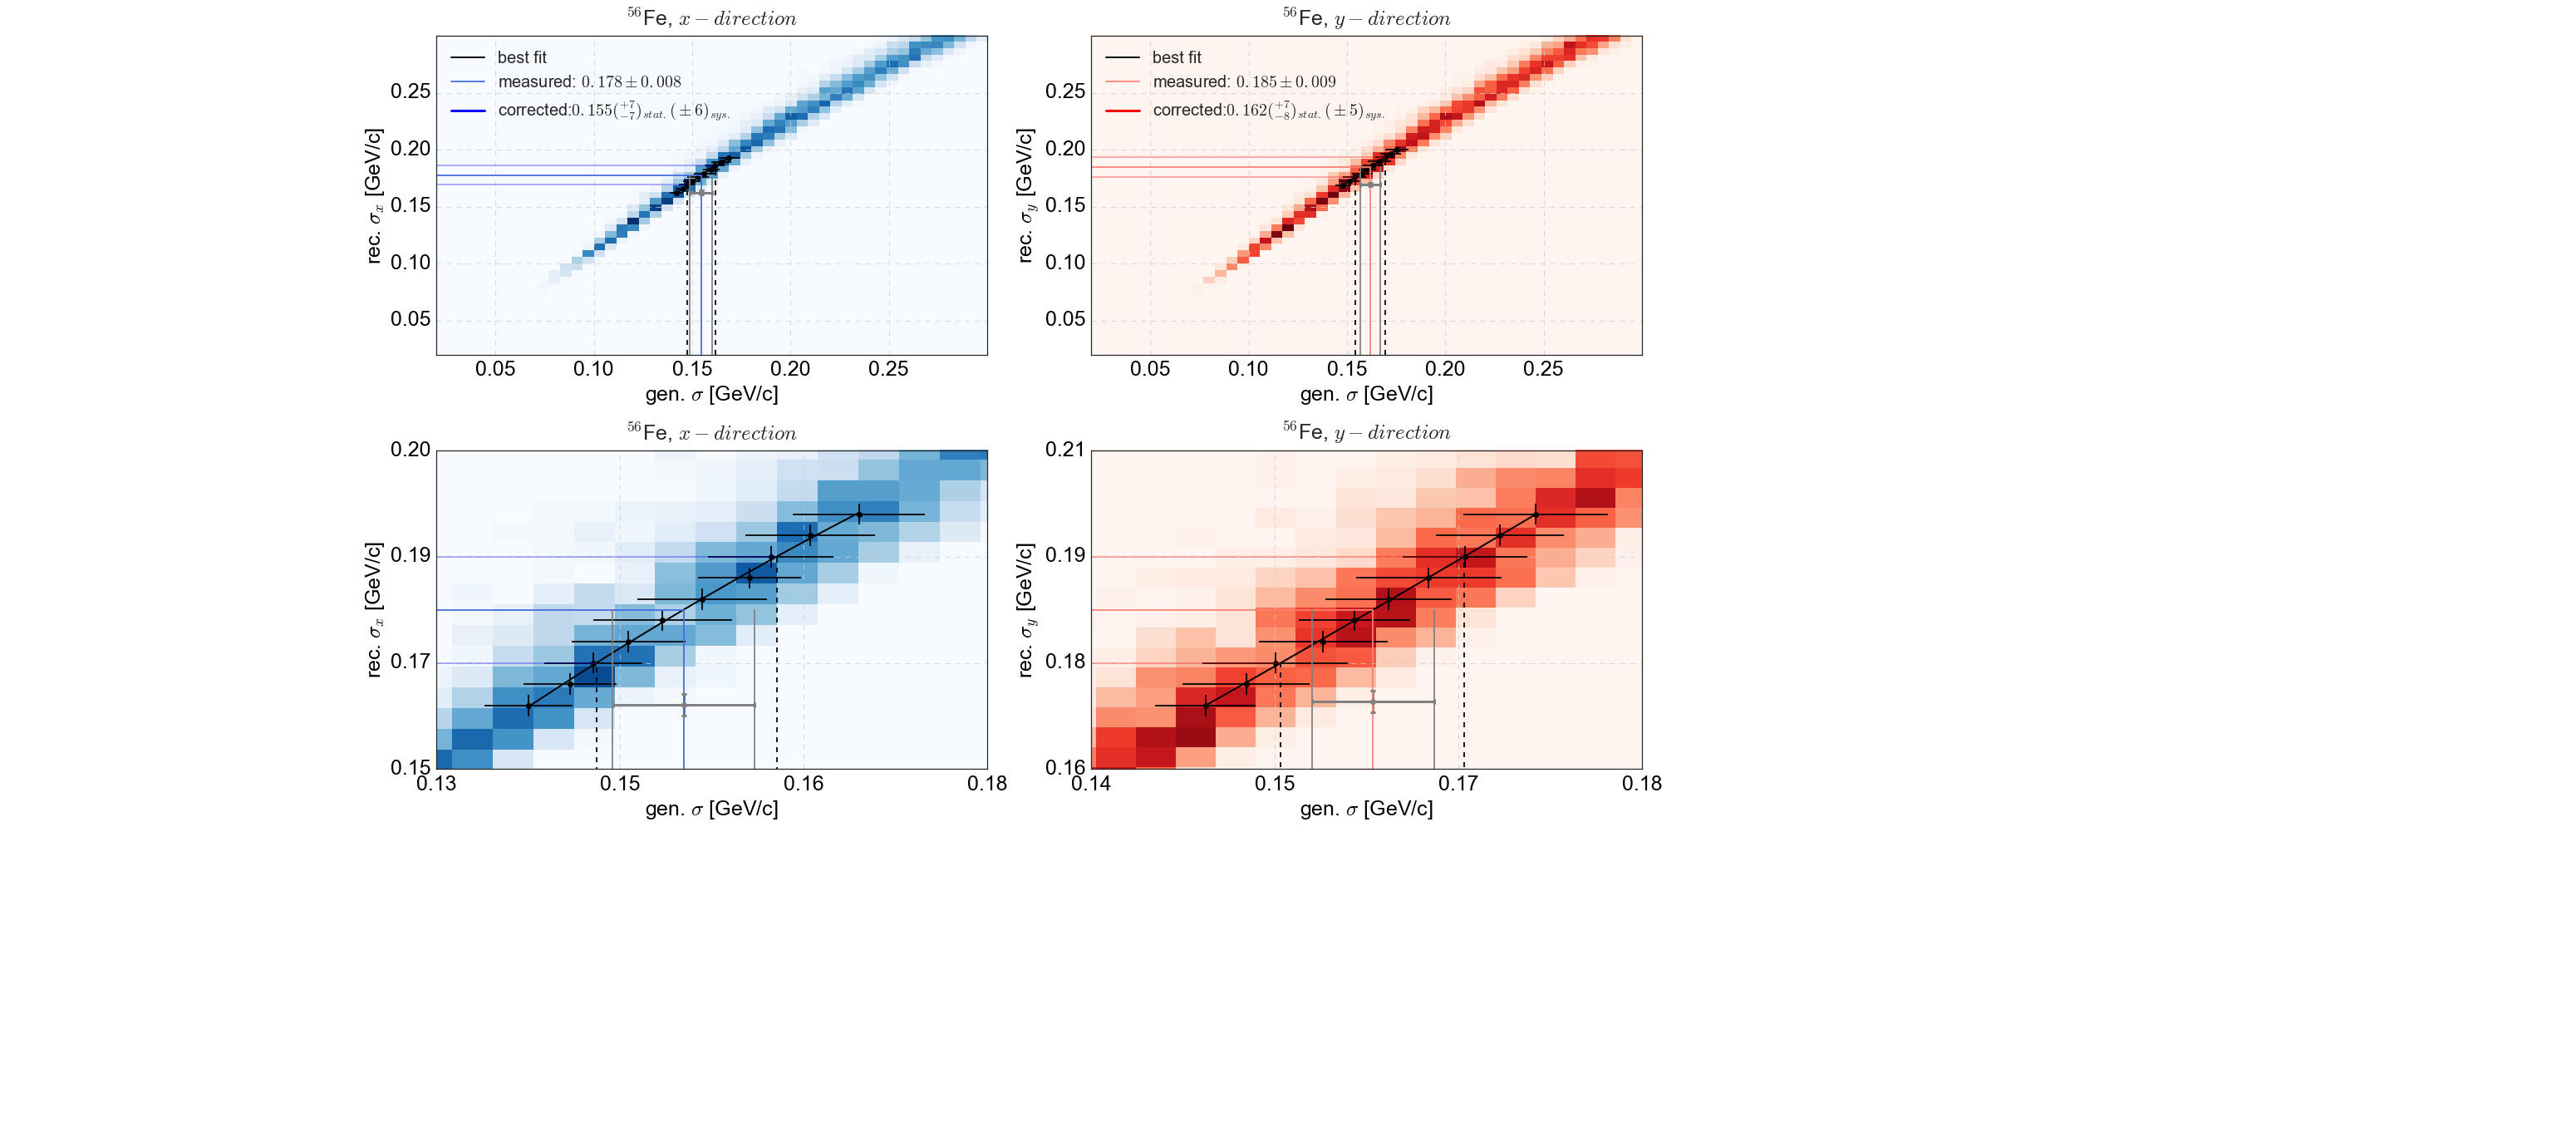

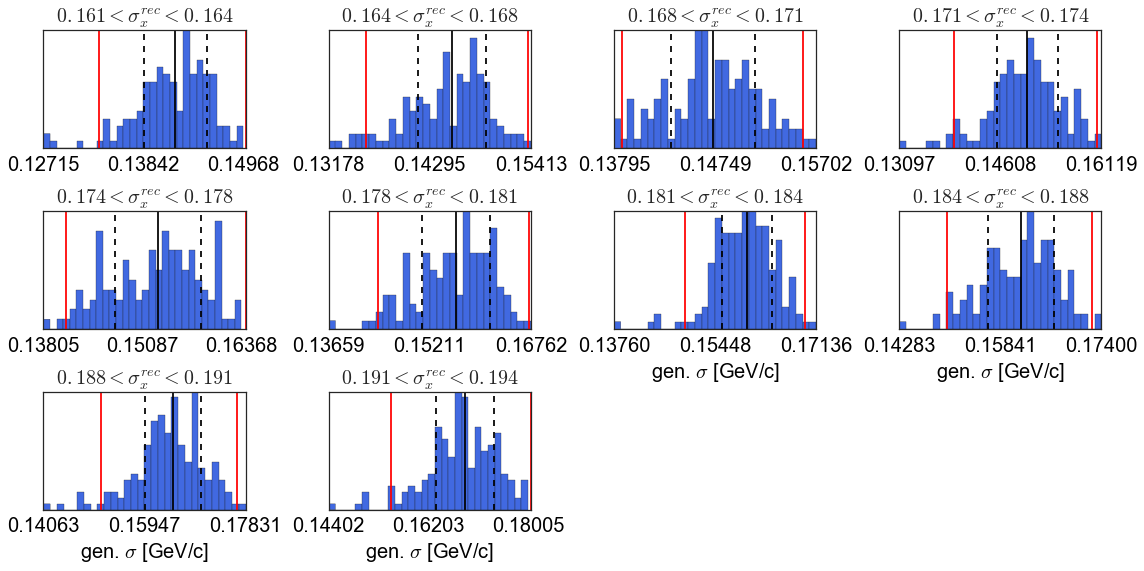

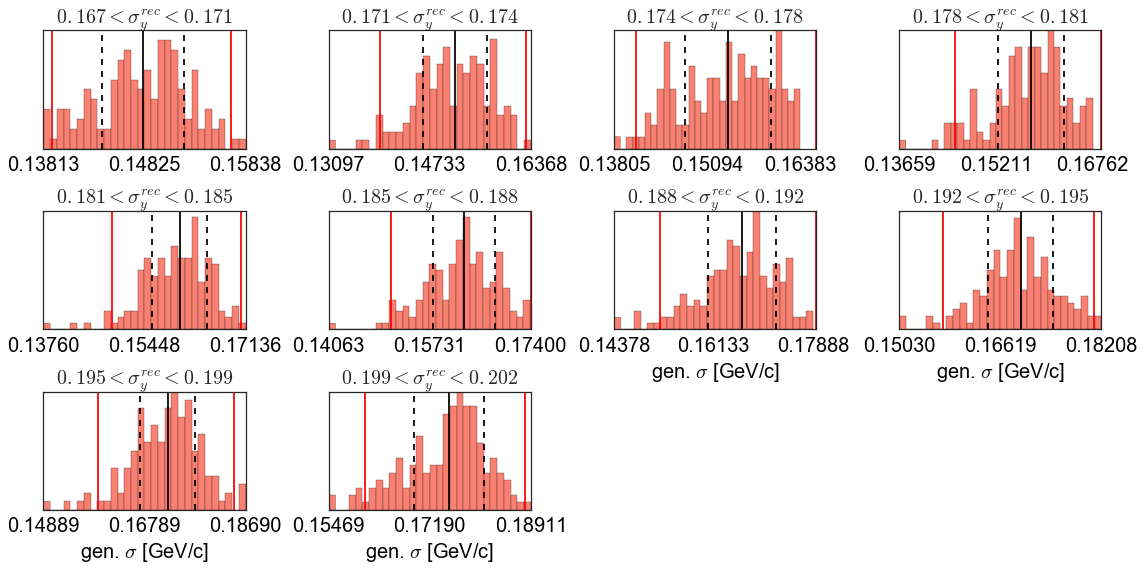

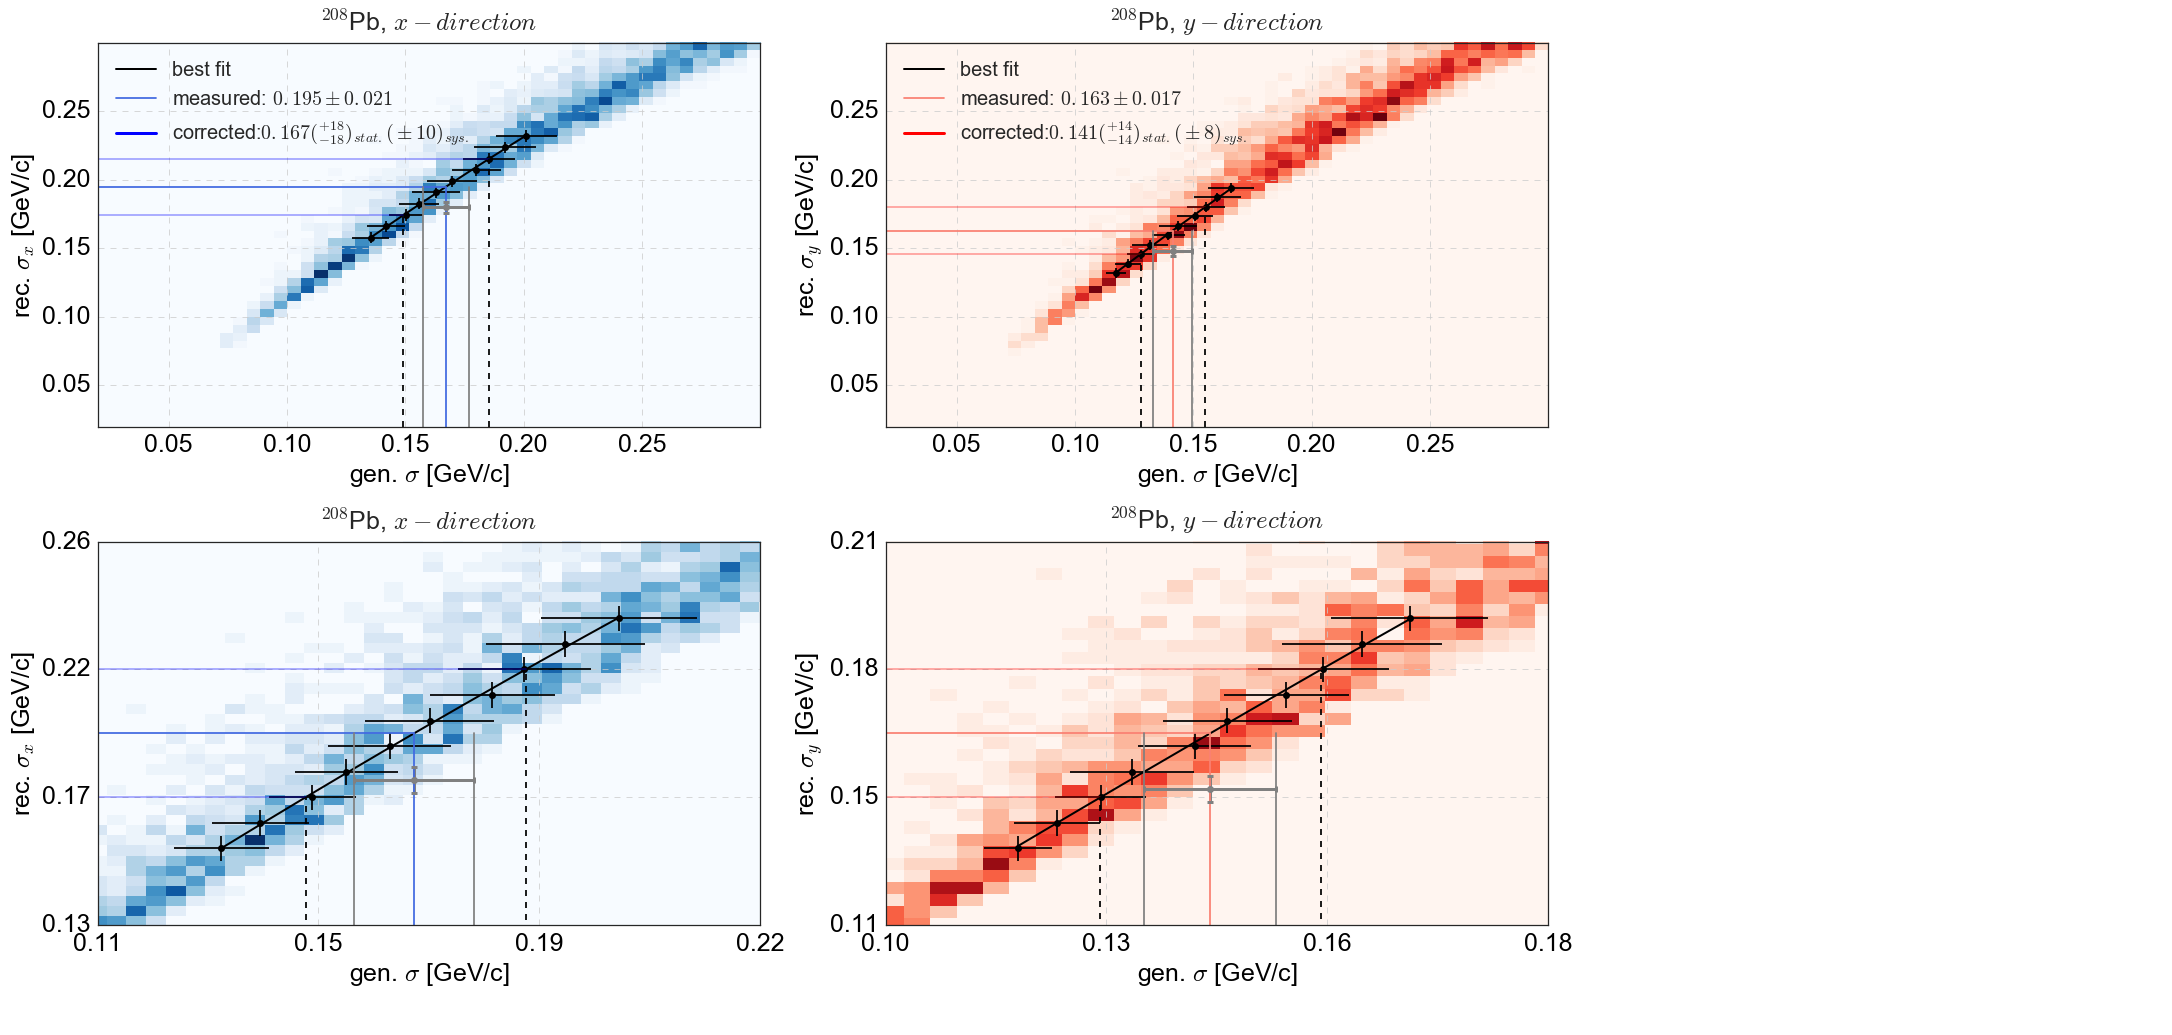

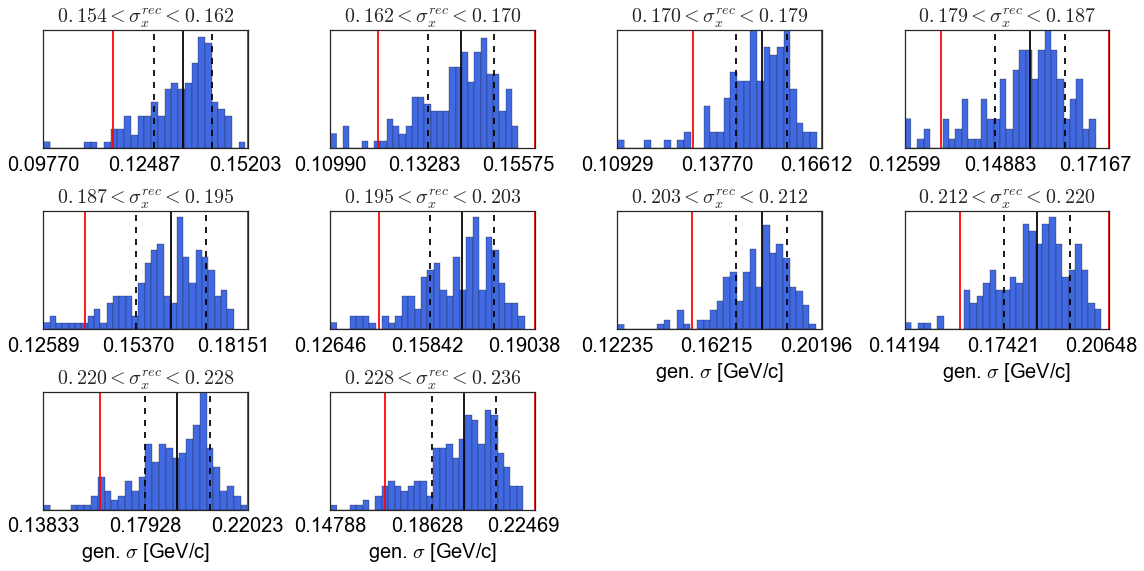

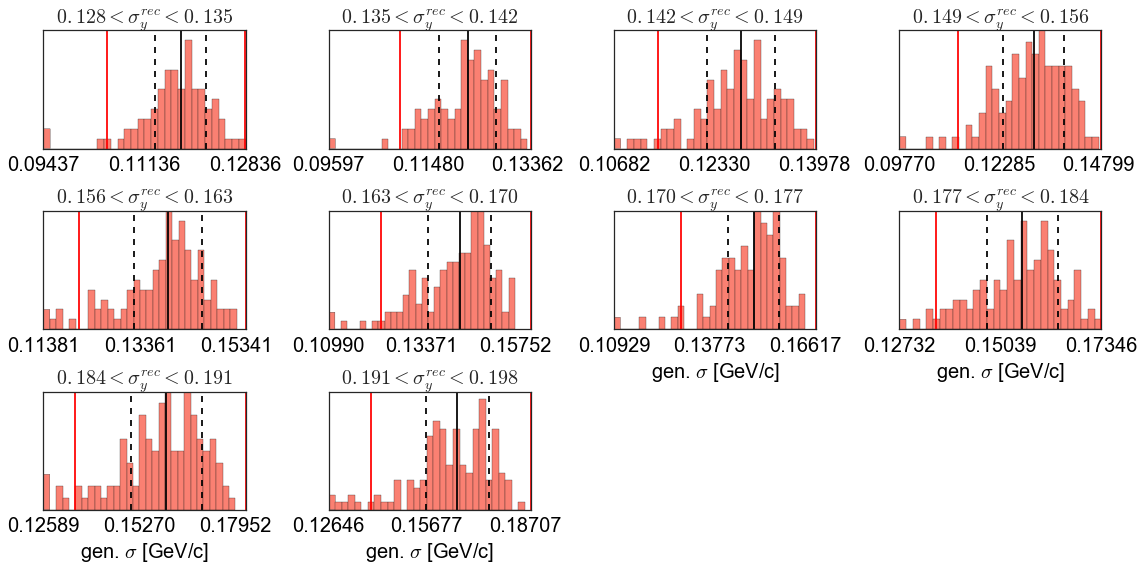

In [25]:
poly_degree = 2 # fit polynomial degree
extraname='chi2_x_y_z<%g'%1.5
for i,(A,target) in enumerate(zip(As[0:],targets[0:])):
    test_name = "chi2red_"+target
    sims=simulation_results[test_name]        
    good_results = sims[(sims['gen_SigmaZ']>0)&(sims['rec_sigma_x']>0)&(sims['rec_sigma_y']>0)&(sims['rec_sigma_z']>0)
                        &(sims['rec_mean_x']>-0.9)&(sims['rec_mean_y']>-0.9)&(sims['rec_mean_x']>-0.9)
#                         &(sims['ks_local_Pval_z']>cut_Pval_z_min)
#                         &(sims['ks_gloabal_Pval_xyz_Fisher']>cut_Pval_xyz_min)
                        &(sims['chi2red_data_sim_x']<cut_chi2_x)
                        &(sims['chi2red_data_sim_y']<cut_chi2_y)
                        &(sims['chi2red_data_sim_z']<cut_chi2_z)
                       ]
    fig=plt.figure(figsize=(22,14))
    ax=fig.add_subplot(2,2,1)    
    plot_cm_direction_binned(sims=good_results, ax=ax,s=3,extraname=extraname
                                    ,poly_degree=poly_degree
                                    ,A=A,direction='x'
                                    ,colors=['blue','royalblue','Blues'],debug=0,do_add_1Ddist_in_slices=True)
    ax=fig.add_subplot(2,2,3)    
    plot_cm_direction_binned(sims=good_results, ax=ax,s=3,extraname=extraname
                                    ,poly_degree=poly_degree
                                    ,A=A,direction='x'
                                    ,colors=['blue','royalblue','Blues'],debug=0
                             ,do_zoom_in=True ,do_add_1Ddist_in_slices=False,do_add_legend=False)

    ax=fig.add_subplot(2,2,2)
    plot_cm_direction_binned(sims=good_results, ax=ax,s=3,extraname=extraname
                                    ,poly_degree=poly_degree if A!=12 else 1
                                    ,A=A,direction='y'
                                    ,colors=['red','salmon','Reds'],debug=0,do_add_1Ddist_in_slices=True)
    ax=fig.add_subplot(2,2,4)
    plot_cm_direction_binned(sims=good_results, ax=ax,s=3,extraname=extraname
                                    ,poly_degree=poly_degree if A!=12 else 1
                                    ,A=A,direction='y'
                                    ,colors=['red','salmon','Reds'],debug=0
                             ,do_zoom_in=True ,do_add_1Ddist_in_slices=False,do_add_legend=False)

    fig.subplots_adjust(bottom=-0.5,left=-0.2)
    fig.tight_layout() 

In [26]:
sample = cm_parameters_with_correction['PrecFiducials']
for direction in ['x','y']:
    sample['sigma_'+direction+extraname+'_final'] = sample['sigma_'+direction+'_corrected'+extraname]
    for updw in ['up','dw']:
        sample['sigma_'+direction+extraname+'_final_'+updw+'_err'] = sample['sigma_'+direction+'_corrected_'+updw+'_err_tot'+extraname]

corr_x = sample['sigma_x_corrected'+extraname]
Dcorr_x = sample['sigma_x_corrected_err_tot'+extraname]

corr_y = sample['sigma_y_corrected'+extraname]
Dcorr_y = sample['sigma_y_corrected_err_tot'+extraname]

# weighted average
corr_t = (corr_x/np.square(Dcorr_x)+corr_y/np.square(Dcorr_y))/( 1./np.square(Dcorr_x) + 1./np.square(Dcorr_y))
sample['sigma_t'+extraname+'_final'] = corr_t
    
Dsys_x = sample['sigma_x_corrected_err_sys'+extraname]
Dsys_y = sample['sigma_y_corrected_err_sys'+extraname]
Dsys_t = 0.5*( Dsys_x + Dsys_y )
# Dsys_t = np.sqrt(1./( 1./np.square(Dsys_x) + 1./np.square(Dsys_y) ))
sample['sigma_t'+extraname+'_final_err_sys'] = Dsys_t

for updw in ['up','dw']:            
    Dstat_x = sample['sigma_x_corrected_'+updw+'_err_stat'+extraname]
    Dstat_y = sample['sigma_y_corrected_'+updw+'_err_stat'+extraname]
    #     Dstat_t = 0.5*np.sqrt( np.square(Dstat_x) + np.square(Dstat_y) )
    Dstat_t = np.sqrt(1./( 1./np.square(Dstat_x) + 1./np.square(Dstat_y) ))
    sample['sigma_t'+extraname+'_final_'+updw+'_err_stat'] = Dstat_t

    Dtot_t = np.sqrt( np.square(Dstat_t) + np.square(Dsys_t) )
    sample['sigma_t'+extraname+'_final_'+updw+'_err_tot'] = Dtot_t
    sample['sigma_t'+extraname+'_final_'+updw+'_err'] = Dtot_t

sample['sigma_t'+extraname+'_final'] = corr_t

In [27]:
sample['sigma_t'+extraname+'_final']

0    0.141131
1    0.151275
2    0.158274
3    0.150966
Name: sigma_tchi2_x_y_z<1.5_final, dtype: float64

In [28]:
sample['sigma_tchi2_z<1.5_final']

KeyError: 'sigma_tchi2_z<1.5_final'

In [ ]:
ax = plot_needed_for_A_depdendence_sigma_t(ylim=(79,205),labels=dict({'$^4$He':(3.5,122),
                                            '$^{12}$C':(9,165), '$^{27}$Al':(21,182),
                                            '$^{56}$Fe':(45,192), '$^{208}$Pb':(158,188), }),do_Ciofi=True)

plot_data_assymetric( data=cm_parameters_with_correction['PrecFiducials'],direction='t',ax=ax, label="This work" , marker='o', markersize=20 )
plot_data_assymetric( data=cm_parameters_with_correction['PrecFiducials'],direction='t'+extraname,ax=ax
                     , Ashift=[0.5,3,5,10],label=r'$\chi^2_{red}(p_{cm}^{x},p_{cm}^{y},p_{cm}^{z})<%g$'%cut_chi2_z , marker='s', markersize=17,color='purple' )

plt.legend(fontsize=20,loc='upper left')
# measured
ax.plot(cm_pars['A'], 1000*cm_pars['sigma_t_before_acc_corr'] ,mec='red' , marker='^' ,mfc='none',lw = 2, mew = 2, ms = 20, linewidth=0, label='This work, no acceptance corr.')

ax.legend(fontsize=25,loc='lower right')
plt.tight_layout()
plt.savefig(figures_path +'results_chi2_cut_xyz.pdf')

# compare methods to combine the systematical uncertainties in $x$ an $y$ directions
average vs. quadratic sum

In [40]:
sample = cm_parameters_with_correction['PrecFiducials']
extraname = ''

Dsys_x = sample['sigma_x_corrected_err_sys'+extraname]
Dsys_y = sample['sigma_y_corrected_err_sys'+extraname]

Dsys_t_average = 0.5*( Dsys_x + Dsys_y )
sample['sigma_t'+extraname+'_average_err_sys'] = Dsys_t_average

Dsys_t_quadraticsum = np.sqrt(1./( 1./np.square(Dsys_x) + 1./np.square(Dsys_y) ))
sample['sigma_t'+extraname+'_quadraticsum_err_sys'] = Dsys_t_quadraticsum



for updw in ['up','dw']:            
    Dstat_x = sample['sigma_x_corrected_'+updw+'_err_stat'+extraname]
    Dstat_y = sample['sigma_y_corrected_'+updw+'_err_stat'+extraname]
    Dstat_t = np.sqrt(1./( 1./np.square(Dstat_x) + 1./np.square(Dstat_y) ))

    Dtot_t_sys_average = np.sqrt( np.square(Dstat_t) + np.square(Dsys_t_average) )
    sample['sigma_t'+extraname+'_sys_average_'+updw+'_err_tot'] = Dtot_t_sys_average
    Dtot_t_sys_quadraticsum = np.sqrt( np.square(Dstat_t) + np.square(Dsys_t_quadraticsum) )
    sample['sigma_t'+extraname+'_sys_quadraticsum_'+updw+'_err_tot'] = Dtot_t_sys_quadraticsum


In [41]:
sample[['sigma_x_corrected','sigma_x_corrected_err_sys'
        ,'sigma_y_corrected','sigma_y_corrected_err_sys'
        ,'sigma_t_final'
        ,'sigma_t_average_err_sys','sigma_t_quadraticsum_err_sys'        
        ,'sigma_t_sys_average_up_err_tot','sigma_t_sys_average_dw_err_tot'        
        ,'sigma_t_sys_quadraticsum_up_err_tot','sigma_t_sys_quadraticsum_dw_err_tot'        
       ]].astype(float)

sigma_x_corrected  sigma_x_corrected_err_sys  sigma_y_corrected  \
0           0.141237                   0.003330           0.145789   
1           0.161313                   0.006974           0.150112   
2           0.155854                   0.004908           0.162722   
3           0.171296                   0.012080           0.145780   

   sigma_y_corrected_err_sys  sigma_t_final  sigma_t_average_err_sys  \
0                   0.003732       0.143455                 0.003531   
1                   0.006980       0.155257                 0.006977   
2                   0.005753       0.159052                 0.005330   
3                   0.010055       0.155679                 0.011068   

   sigma_t_quadraticsum_err_sys  sigma_t_sys_average_up_err_tot  \
0                      0.002485                        0.005478   
1                      0.004934                        0.010765   
2                      0.003734                        0.007448   
3                      0.007728                        0.015949   

   sigma_t_sys_average_dw_err_tot  sigma_t_sys_quadraticsum_up_err_tot  \
0                        0.005453                             0.004870   
1                        0.010678                             0.009567   
2                        0.007344                             0.006404   
3                        0.015610                             0.013842   

   sigma_t_sys_quadraticsum_dw_err_tot  
0                             0.004842  
1                             0.009470  
2                             0.006281  
3                             0.013450